<a href="https://www.kaggle.com/code/jatintec/data-science-championship?scriptVersionId=176338928" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW

import os
from transformers import AutoTokenizer
from transformers import AutoModel
import itertools
import random

from tqdm.auto import tqdm
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import StratifiedKFold
from torch.optim.lr_scheduler import ReduceLROnPlateau

for dirname, _, filenames in os.walk('/kaggle/input/patent-classifier'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# EDA

## Loading data

In [2]:
train_path = "/kaggle/input/data-science-student-championship/train.csv"
test_path = "/kaggle/input/data-science-student-championship/test.csv"
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
train_df.head()

Label                                            Content
0      2  second counting input 5 2 which receives inter...
1      4  extremely low temperature of the chips in cold...
2      3  of the basic ammonium salt of the carboxyl ate...
3      9  18 u2033 is provided which is axially supporte...
4      2  to an u201c inner surface u201d means the surf...

In [3]:
# # Distribution of labels
# plt.figure(figsize=(10, 6))
# sns.countplot(x='Label', data=train_df, palette='Set2')
# plt.title('Distribution of Patent Categories')
# plt.xlabel('Category Label')
# plt.ylabel('Number of Patents')
# plt.show()

In [4]:
# # Text length distribution
# train_df['text_length'] = train_df['Content'].apply(len)
# plt.figure(figsize=(10, 6))
# sns.histplot(train_df['text_length'], bins=30, kde=True, color='blue')
# plt.title('Distribution of Content Lengths')
# plt.xlabel('Length of Content')
# plt.ylabel('Frequency')
# plt.show()

# # You might also want to look at boxplots to identify outliers in text lengths
# plt.figure(figsize=(10, 6))
# sns.boxplot(x='Label', y='text_length', data=train_df, palette='Set1')
# plt.title('Box Plot of Abstract Lengths by Patent Category')
# plt.xlabel('Category Label')
# plt.ylabel('Length of Abstract')
# plt.show()

In [5]:
# from sklearn.feature_extraction.text import CountVectorizer

# # Function to plot most common words
# def plot_most_common_words(corpus, n_features=20):
#     vectorizer = CountVectorizer(stop_words='english', max_features=n_features)
#     X = vectorizer.fit_transform(corpus)
#     sum_words = X.sum(axis=0) 
#     words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
#     words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
#     words, counts = zip(*words_freq)
#     plt.figure(figsize=(10, 6))
#     sns.barplot(x=list(counts), y=list(words))
#     plt.title('Most Common Words in Patent Abstracts')
#     plt.xlabel('Frequency')
#     plt.ylabel('Words')
#     plt.show()
    
# # Apply this function to the Abstract column
# plot_most_common_words(train_df['Content'])
# plt.show()

In [6]:
# max_=0
# sum_=0
# for content in train_df["Content"]:
#     number_of_words = len(list(content.split(" ")))
#     if number_of_words>max_:
#         max_ = number_of_words
#     sum_ += number_of_words
# print(f"Max tokens: {max_}, Average tokens: {sum_/len(train_df['Content'])}")

In [7]:
# word_counts = [len(text.split()) for text in train_df["Content"]]

# # Calculate mean and standard deviation
# mean_word_count = np.mean(word_counts)
# std_word_count = np.std(word_counts)

# # Plotting using sns.histplot
# plt.figure(figsize=(10, 6))
# sns.histplot(word_counts, kde=True, color='blue', stat='density')
# plt.title('Distribution of Word Counts in Train Corpus')
# plt.xlabel('Word Count')
# plt.ylabel('Density')

# # Optionally, add vertical lines for mean and standard deviations
# plt.axvline(mean_word_count, color='red', linestyle='--', label=f'Mean: {mean_word_count:.2f}')
# plt.axvline(mean_word_count + std_word_count, color='green', linestyle='--', label=f'Mean + 1 STD: {mean_word_count + std_word_count:.2f}')
# plt.axvline(mean_word_count - std_word_count, color='green', linestyle='--', label=f'Mean - 1 STD: {mean_word_count - std_word_count:.2f}')

# plt.legend()
# plt.show()

In [8]:
# max_=0
# sum_=0
# for content in test_df["Content"]:
#     number_of_words = len(list(content.split(" ")))
#     if number_of_words>max_:
#         max_ = number_of_words
#     sum_ += number_of_words
# print(f"Max tokens: {max_}, Average tokens: {sum_/len(test_df['Content'])}")

In [9]:
# word_counts = [len(text.split()) for text in test_df["Content"]]

# # Calculate mean and standard deviation
# mean_word_count = np.mean(word_counts)
# std_word_count = np.std(word_counts)

# # Plotting using sns.histplot
# plt.figure(figsize=(10, 6))
# sns.histplot(word_counts, kde=True, color='blue', stat='density')
# plt.title('Distribution of Word Counts in Test Corpus')
# plt.xlabel('Word Count')
# plt.ylabel('Density')

# # Optionally, add vertical lines for mean and standard deviations
# plt.axvline(mean_word_count, color='red', linestyle='--', label=f'Mean: {mean_word_count:.2f}')
# plt.axvline(mean_word_count + std_word_count, color='green', linestyle='--', label=f'Mean + 1 STD: {mean_word_count + std_word_count:.2f}')
# plt.axvline(mean_word_count - std_word_count, color='green', linestyle='--', label=f'Mean - 1 STD: {mean_word_count - std_word_count:.2f}')

# plt.legend()
# plt.show()

In [10]:
# for label in (1, 2, 3, 4, 5, 6, 7, 8, 9):
#     train_word_freq = {}
#     for content in train_df[train_df['Label']==label]['Content']:
#         for word in content.split():
#             train_word_freq[word] = train_word_freq.get(word, 0) + 1
#     # Sort the dictionary by frequency
#     sorted_word_freq = sorted(train_word_freq.items(), key=lambda x: x[1], reverse=True)
#     print(f"Top 10 words with there frequinces: {sorted_word_freq[:10]}, Unique word count {len(sorted_word_freq)}")

In [11]:
# test_word_freq = {}
# for content in test_df['Content']:
#     for word in content.split():
#         test_word_freq[word] = test_word_freq.get(word, 0) + 1

# # Sort the dictionary by frequency
# sorted_word_freq = sorted(test_word_freq.items(), key=lambda x: x[1], reverse=True)
# print(f"Top 10 words with there frequinces: {sorted_word_freq[:10]}, Unique word count {len(sorted_word_freq)}")

In [12]:
# # Identify common words and compute their frequencies
# common_words_freq = {word: (train_word_freq[word], test_word_freq[word]) 
#                      for word in train_word_freq if word in test_word_freq}

# # Sort common words by their cumulative frequency (train + test)
# sorted_common_words_freq = sorted(common_words_freq.items(), 
#                                   key=lambda x: x[1][0] + x[1][1], 
#                                   reverse=True)

In [13]:
# # Display the top 10 common words with their frequencies
# print(f"Top 10 common words with their frequencies: {sorted_common_words_freq[:10]}")
# print(f"Total unique common words: {len(sorted_common_words_freq)}")

In [14]:
# stop_words = set(stopwords.words('english'))
# lemmatizer = WordNetLemmatizer()
# def preprocess_text(text):
#         # Lemmatize text and split into words
#         lemmatized_words = [lemmatizer.lemmatize(word.lower()) for word in text.split()]
#         # Remove stopwords and filter out less frequent words
#         filtered_words = [word for word in lemmatized_words if word not in stop_words and word in vocab]
#         # Rejoin words into a processed string
#         return ' '.join(filtered_words)

In [15]:
# word_counts = [len(preprocess_text(text).split()) for text in train_df["Content"]]
# # Calculate mean and standard deviation
# mean_word_count = np.mean(word_counts)
# std_word_count = np.std(word_counts)

# # Plotting using sns.histplot
# plt.figure(figsize=(10, 6))
# sns.histplot(word_counts, kde=True, color='blue', stat='density')
# plt.title('Distribution of Word Counts in Train Corpus')
# plt.xlabel('Word Count')
# plt.ylabel('Density')

# # Optionally, add vertical lines for mean and standard deviations
# plt.axvline(mean_word_count, color='red', linestyle='--', label=f'Mean: {mean_word_count:.2f}')
# plt.axvline(mean_word_count + std_word_count, color='green', linestyle='--', label=f'Mean + 1 STD: {mean_word_count + std_word_count:.2f}')
# plt.axvline(mean_word_count - std_word_count, color='green', linestyle='--', label=f'Mean - 1 STD: {mean_word_count - std_word_count:.2f}')

# plt.legend()
# plt.show()

In [16]:
# word_counts = [len(preprocess_text(text).split()) for text in test_df["Content"]]
# # Calculate mean and standard deviation
# mean_word_count = np.mean(word_counts)
# std_word_count = np.std(word_counts)

# # Plotting using sns.histplot
# plt.figure(figsize=(10, 6))
# sns.histplot(word_counts, kde=True, color='blue', stat='density')
# plt.title('Distribution of Word Counts in Test Corpus')
# plt.xlabel('Word Count')
# plt.ylabel('Density')

# # Optionally, add vertical lines for mean and standard deviations
# plt.axvline(mean_word_count, color='red', linestyle='--', label=f'Mean: {mean_word_count:.2f}')
# plt.axvline(mean_word_count + std_word_count, color='green', linestyle='--', label=f'Mean + 1 STD: {mean_word_count + std_word_count:.2f}')
# plt.axvline(mean_word_count - std_word_count, color='green', linestyle='--', label=f'Mean - 1 STD: {mean_word_count - std_word_count:.2f}')

# plt.legend()
# plt.show()

## Dataset Class

In [17]:
class BinaryTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512, is_train=True):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.is_train = is_train
        
        if self.is_train:
            # Adjust labels to zero-based index
            labels = [label - 1 for label in labels]
            
            # Label 1 for class 9, Label 0 for all other classes
            binary_labels = [1 if label == 8 else 0 for label in labels]
            
            # Identify indices for class 9 and others
            class_9_indices = [i for i, label in enumerate(binary_labels) if label == 1]
            other_class_indices = [i for i, label in enumerate(binary_labels) if label == 0]
            
            # Randomly sample from other classes to match the number of class 9 instances
            sampled_other_class_indices = np.random.choice(other_class_indices, len(class_9_indices), replace=False)
            
            # Combine the indices for balanced classes
            balanced_indices = np.concatenate([class_9_indices, sampled_other_class_indices])
            
            # Shuffle to mix class 9 and other class samples
            np.random.shuffle(balanced_indices)
            
            # Subset the texts and labels
            self.texts = [texts[i] for i in balanced_indices]
            self.labels = [binary_labels[i] for i in balanced_indices]
        else:
            self.texts = texts
            self.labels = [1 if label == 9 else 0 for label in labels]
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        item = {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
        }
        if self.is_train:
            label = self.labels[idx]
            item['labels'] = torch.tensor(label, dtype=torch.long)
        return item

In [18]:
# class TextDataset(Dataset):
#     def __init__(self, texts, labels=None, tokenizer=None, max_length=512, is_train=True):
#         self.texts = texts
#         self.labels = labels
#         self.is_train = is_train
#         self.tokenizer = tokenizer
#         self.max_length = max_length
#         if self.is_train:
#             self.labels = [label - 1 for label in self.labels]
    
#     def __len__(self):
#         return len(self.texts)
    
#     def __getitem__(self, idx):
#         text = self.texts[idx]
#         encoding = self.tokenizer(
#             text,
#             add_special_tokens=True,
#             max_length=self.max_length,
#             truncation=True,
#             padding='max_length',
#             return_attention_mask=True,
#             return_tensors='pt',
#         )
#         item = {
#             'input_ids': encoding['input_ids'].squeeze(),
#             'attention_mask': encoding['attention_mask'].squeeze(),
#         }
#         if self.is_train:
#             label = self.labels[idx]
#             item['labels'] = torch.tensor(label, dtype=torch.long)
#         return item

In [19]:
# # Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-small-en-v1.5")

# # Convert labels to integers if they're not already (replace 'Label' with your actual label column name)
# train_df['Label'] = train_df['Label'].astype(int)
# # Filter out rows where the label is 9
# train_df = train_df[train_df['Label'] != 9]

# train_dataset = TextDataset(
#     texts=train_df["Content"].to_list(),
#     labels=train_df["Label"].to_list(),
#     tokenizer=tokenizer,
#     max_length=256,
#     is_train=True
# )
# # Create DataLoader
# # train_loader = DataLoader(train_dataset, batch_size=16)

# # # Iterate through Binary DataLoader
# # for i, batch in enumerate(train_loader):
# #     input_ids = batch['input_ids']
# #     attention_mask = batch['attention_mask']
# #     labels = batch['labels']
    
# #     # Print out shapes and some example data
# #     print(f"Batch {i+1}")
# #     print(f"Input IDs shape: {input_ids.shape}")
# #     print(f"Attention Mask shape: {attention_mask.shape}")
# #     print(f"Labels shape: {labels.shape}")
# #     print(f"First input IDs: {input_ids[0][:12]}")
# #     print(f"First Attention Mask: {attention_mask[0][:12]}")
# #     print(f"Number of words", sum(attention_mask[0]))
# #     print(f"First Label: {labels[i]}\n")
# #     if i == 3:
# #         break
# # print(f"Length of dataset: ", len(train_dataset))

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [20]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = AutoModel.from_pretrained("BAAI/bge-large-en-v1.5").to(device)

# def get_embeddings(texts):
#     model.eval()
#     embeddings = []
#     # Wrap texts with tqdm for a progress bar
#     for text in tqdm(texts, desc="Extracting embeddings"):
#         encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=256)
#         # Send data to the device
#         encoded_input = {key: tensor.to(device) for key, tensor in encoded_input.items()}
        
#         with torch.no_grad():
#             output = model(**encoded_input)
#             embeddings.append(output.last_hidden_state[:,0,:].cpu().numpy())
    
#     return embeddings


# # Extract embeddings
# embeddings = get_embeddings(train_df["Content"].tolist())

In [21]:
# embeddings_2d = np.vstack([emb.reshape(-1) for emb in embeddings])

In [22]:
# print("Shape of embeddings:", embeddings_2d.shape)

In [23]:
# from sklearn.cluster import KMeans

# num_clusters = 9  # Adjust this number as needed
# kmeans = KMeans(n_clusters=num_clusters)
# clusters = kmeans.fit_predict(embeddings_2d)

In [24]:
# from sklearn.metrics import confusion_matrix

# # Since clusters are not direct matches to labels, use confusion matrix to see alignment
# conf_matrix = confusion_matrix(train_df["Label"], clusters)

# print(conf_matrix)

In [25]:
# # Assuming 'conf_matrix' is already calculated from the previous step
# plt.figure(figsize=(10, 7))  # You can adjust the size as needed
# sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
# plt.show()

In [26]:
train_df['Label'] = train_df['Label'].astype(int)

binary_dataset = BinaryTextDataset(
    texts=train_df["Content"].to_list(),
    labels=train_df["Label"].to_list(),
    tokenizer=tokenizer,
    max_length=256,
    is_train=True
)

In [27]:
# labels = [binary_dataset[i]['labels'].item() for i in range(len(binary_dataset))]

# # Count each class occurrence
# label_counts = Counter(labels)

# print("Label counts:", label_counts)

In [28]:
# Create Dataset
# test_dataset = TextDataset(
#     texts=test_df["Content"].to_list(),
#     tokenizer=tokenizer,
#     max_length=256,
#     is_train=False
# )
# test_loader = DataLoader(test_dataset, batch_size=16)
# Iterate through Binary DataLoader
# for i, batch in enumerate(test_loader):
#     input_ids = batch['input_ids']
#     attention_mask = batch['attention_mask']
    
#     print(f"Batch {i+1}")
#     print(f"Binary Input IDs shape: {input_ids.shape}")
#     print(f"Binary Attention Mask shape: {attention_mask.shape}")
#     print(f"Binary First input IDs: {input_ids[0][:12]}")
#     print(f"Binary First Attention Mask: {attention_mask[0][:12]}")
#     print(f"Number of words", sum(attention_mask[0]))
    
#     if i == 3:
#         break
# print(f"Length of dataset: ", len(test_dataset))

## Define Model

In [29]:
scibert = AutoModel.from_pretrained("BAAI/bge-small-en-v1.5")
scibert.config.hidden_size

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

384

In [30]:
# class SciBertEmbedder(nn.Module):
#     def __init__(self):
#         super(SciBertEmbedder, self).__init__()
#         self.scibert = AutoModel.from_pretrained("BAAI/bge-small-en-v1.5")

#     def forward(self, input_ids, attention_mask=None):
#         with torch.no_grad():
#             outputs = self.scibert(input_ids=input_ids, attention_mask=attention_mask)
#         return outputs[1]  # Output the [CLS] token embeddings

# class Classifier(nn.Module):
#     def __init__(self, hidden_dim, output_dim, dropout_rate):
#         super(Classifier, self).__init__()
#         self.scibert = AutoModel.from_pretrained("BAAI/bge-small-en-v1.5")
#         self.dropout = nn.Dropout(dropout_rate)
#         self.fc1 = nn.Linear(self.scibert.config.hidden_size, hidden_dim * 2)
#         self.ln1 = nn.LayerNorm(hidden_dim * 2)  # Layer Normalization after the first linear layer
#         self.fc2 = nn.Linear(hidden_dim * 2, hidden_dim)
#         self.ln2 = nn.LayerNorm(hidden_dim)  # Layer Normalization after the second linear layer
#         self.fc3 = nn.Linear(hidden_dim, output_dim)
#         self.ln3 = nn.LayerNorm(output_dim)  # Layer Normalization at the output

#     def forward(self, input_ids, attention_mask=None):
#         outputs = self.scibert(input_ids=input_ids, attention_mask=attention_mask)
#         x = self.fc1(outputs[1])
#         x = self.ln1(x)  # Apply Layer Normalization
#         x = F.gelu(x)
#         x = self.dropout(x)
#         x = self.fc2(x)
#         x = self.ln2(x)  # Apply Layer Normalization
#         x = F.gelu(x)
#         x = self.dropout(x)
#         x = self.fc3(x)
#         x = self.ln3(x)  # Apply Layer Normalization before output
#         return x

# class SciBertClassifier(nn.Module):
#     def __init__(self, hidden_dim, output_dim, dropout_rate, device):
#         super(SciBertClassifier, self).__init__()
#         self.classifier = Classifier(hidden_dim, output_dim, dropout_rate).to(device)
#         self.device = device

#     def forward(self, input_ids, attention_mask):
#         output = self.classifier(input_ids.to(self.device), attention_mask.to(self.device))
#         return output

In [31]:
class BinaryClassifier(nn.Module):
    def __init__(self, hidden_dim, dropout_rate):
        super(BinaryClassifier, self).__init__()
        self.scibert = AutoModel.from_pretrained("BAAI/bge-small-en-v1.5")
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(self.scibert.config.hidden_size, hidden_dim * 2)
        self.fc2 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)  # Output dimension is 1 for binary classification

    def forward(self, input_ids, attention_mask=None):
        outputs = self.scibert(input_ids=input_ids, attention_mask=attention_mask)
        x = self.fc1(outputs[1])
        x = F.gelu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.gelu(x)    
        x = self.dropout(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)  # Sigmoid activation to output probabilities
        return x

class BinarySciBertClassifier(nn.Module):
    def __init__(self, hidden_dim, dropout_rate, device):
        super(BinarySciBertClassifier, self).__init__()
        self.classifier = BinaryClassifier(hidden_dim, dropout_rate).to(device)
        self.device = device

    def forward(self, input_ids, attention_mask):
        output = self.classifier(input_ids.to(self.device), attention_mask.to(self.device))
        return output

In [32]:
# scibert = AutoModel.from_pretrained("BAAI/bge-large-en-v1.5")
# scibert.to(device)
# progress_bar = tqdm(train_loader, desc=f"Test out")
# for batch in progress_bar:
#     input_ids = batch['input_ids'].to(device)
#     attention_mask = batch['attention_mask'].to(device)
#     labels = batch['labels'].to(device)
#     out = scibert(input_ids, attention_mask)
#     print(out)

## Load model

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [34]:
# from sklearn.utils.class_weight import compute_class_weight

# targets = train_df["Label"]
# # Assuming 'targets' contains your labels for the dataset
# class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(targets), y=targets)
# class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

In [35]:
# class_weights_tensor

In [36]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = range(1, 3)

In [37]:
from sklearn.metrics import balanced_accuracy_score
def calculate_balanced_accuracy(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_true = []

    with torch.no_grad():  # No need to track gradients for inference
        data_loader_tqdm = tqdm(data_loader, desc=f"Calculating Balanced Accuracy")
        for batch in data_loader_tqdm:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            _, predicted_labels = torch.max(outputs, dim=1)

            # Move predicted and true labels to CPU and then convert to numpy for sklearn compatibility
            all_preds.extend(predicted_labels.cpu().numpy())
            all_true.extend(labels.cpu().numpy())

    # Calculate the balanced accuracy score
    balanced_accuracy = balanced_accuracy_score(all_true, all_preds)
    return balanced_accuracy, np.array(all_preds), np.array(all_true)

In [38]:
def calculate_binary_balanced_accuracy(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_true = []

    with torch.no_grad():  # No need to track gradients for inference
        data_loader_tqdm = tqdm(data_loader, desc="Calculating Balanced Accuracy")
        for batch in data_loader_tqdm:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            # Convert probabilities to class predictions using 0.5 as threshold
            predicted_labels = (outputs.squeeze() > 0.5).long()  # .squeeze() in case your output has an unnecessary extra dimension

            # Move predicted and true labels to CPU and then convert to numpy for sklearn compatibility
            all_preds.extend(predicted_labels.cpu().numpy())
            all_true.extend(labels.cpu().numpy())

    # Calculate the balanced accuracy score
    balanced_accuracy = balanced_accuracy_score(all_true, all_preds)
    return balanced_accuracy, np.array(all_preds), np.array(all_true)

In [39]:
class SmoothCrossEntropyLoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super(SmoothCrossEntropyLoss, self).__init__()
        self.smoothing = smoothing

    def forward(self, input, target):
        log_prob = F.log_softmax(input, dim=-1)
        weights = input.new_ones(input.size()) * self.smoothing / (input.size(-1) - 1.)
        weights.scatter_(-1, target.unsqueeze(-1), (1. - self.smoothing))
        loss = (-weights * log_prob).sum(dim=-1).mean()
        return loss

# Usage
loss_fn = SmoothCrossEntropyLoss(smoothing=0.1)

## Training Loop

### Binary

Fold 1/10


Training Epoch 1:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6923


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.5000
[[5364    0]
 [5365    0]]
Confusion matrix, without normalization


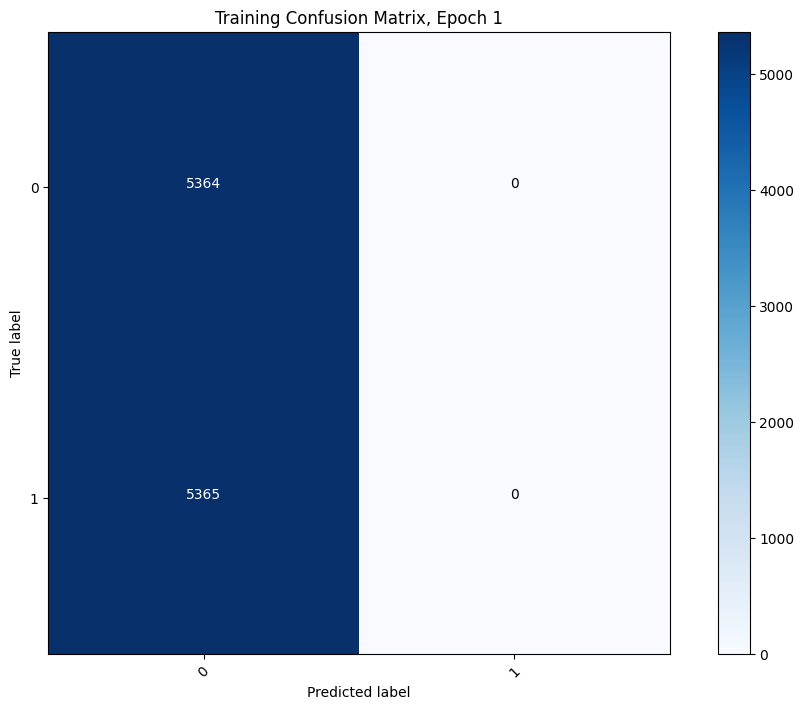

Validation Epoch 1:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6940


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5000
[[597   0]
 [596   0]]
Confusion matrix, without normalization


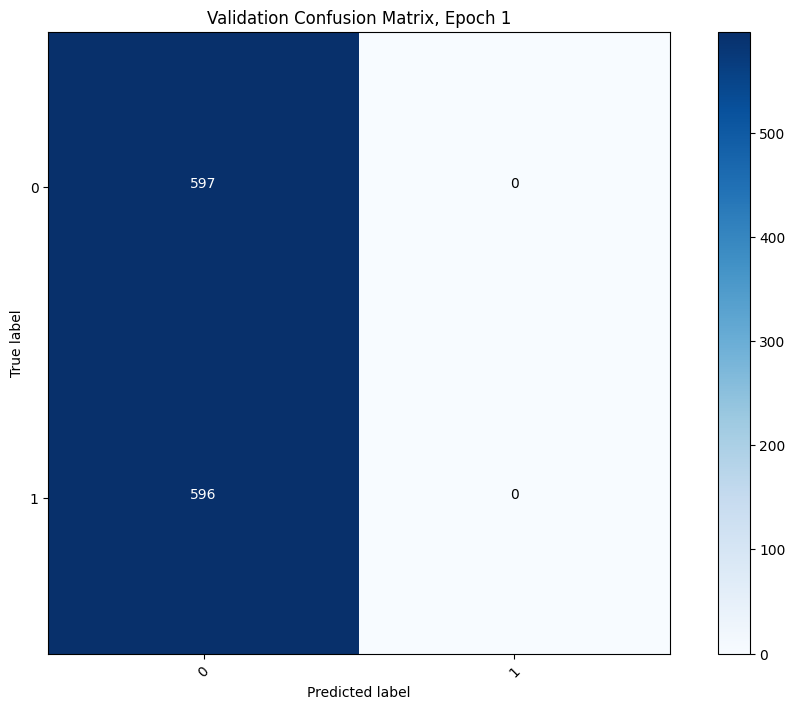

Training Epoch 2:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6936


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.5000
[[   0 5364]
 [   0 5365]]
Confusion matrix, without normalization


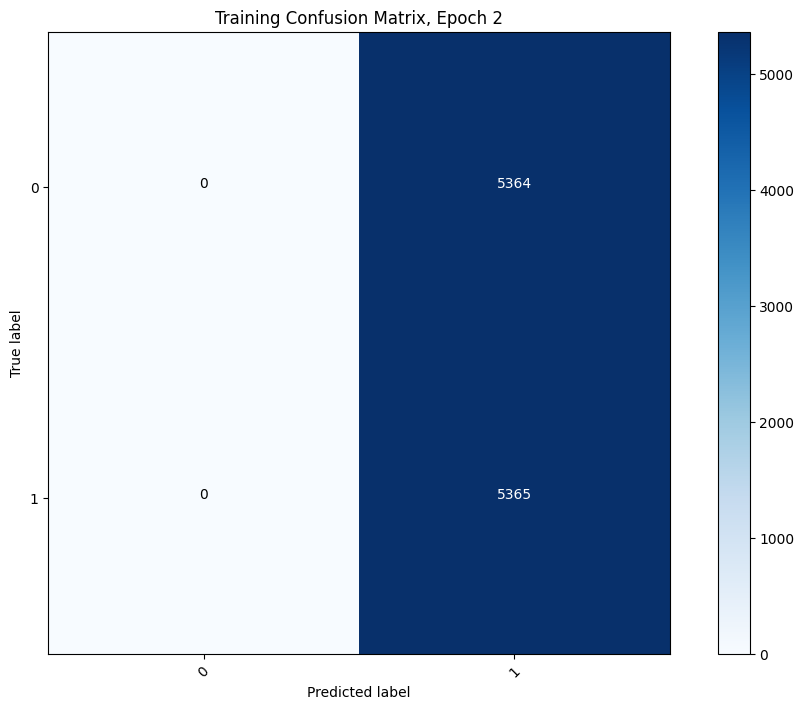

Validation Epoch 2:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6933


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5000
[[  0 597]
 [  0 596]]
Confusion matrix, without normalization


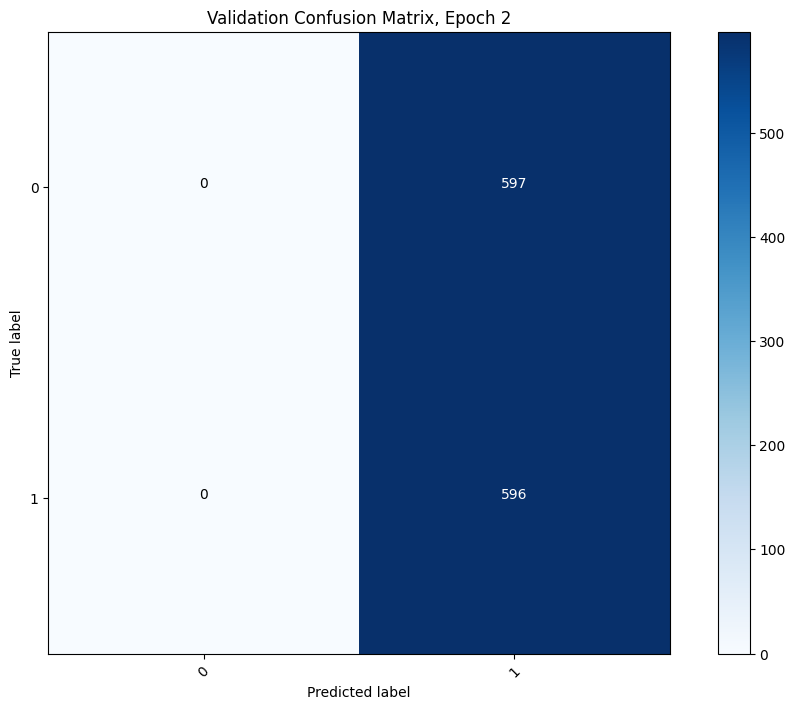

Training Epoch 3:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6933


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.5444
[[3240 2124]
 [2764 2601]]
Confusion matrix, without normalization


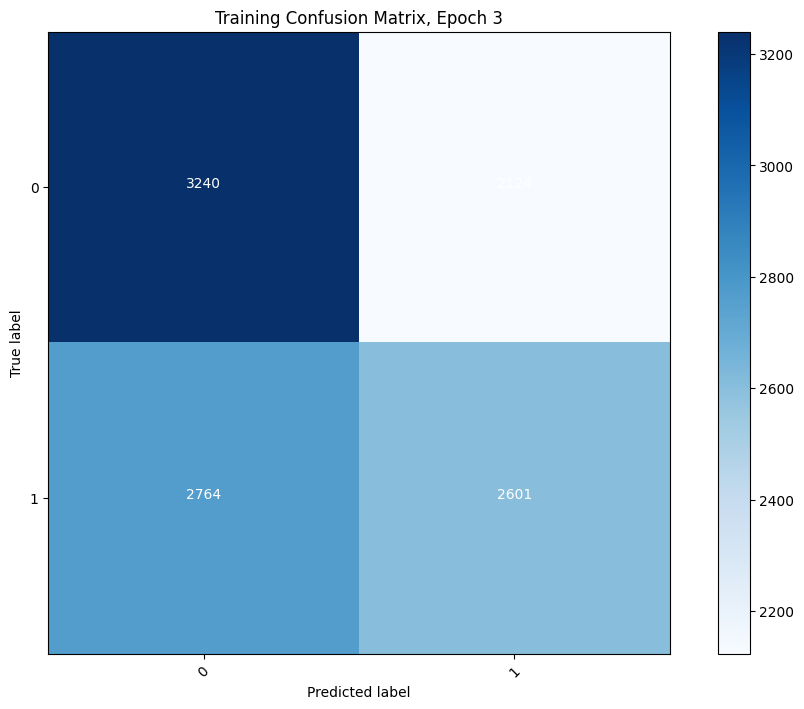

Validation Epoch 3:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6910


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5247
[[345 252]
 [315 281]]
Confusion matrix, without normalization


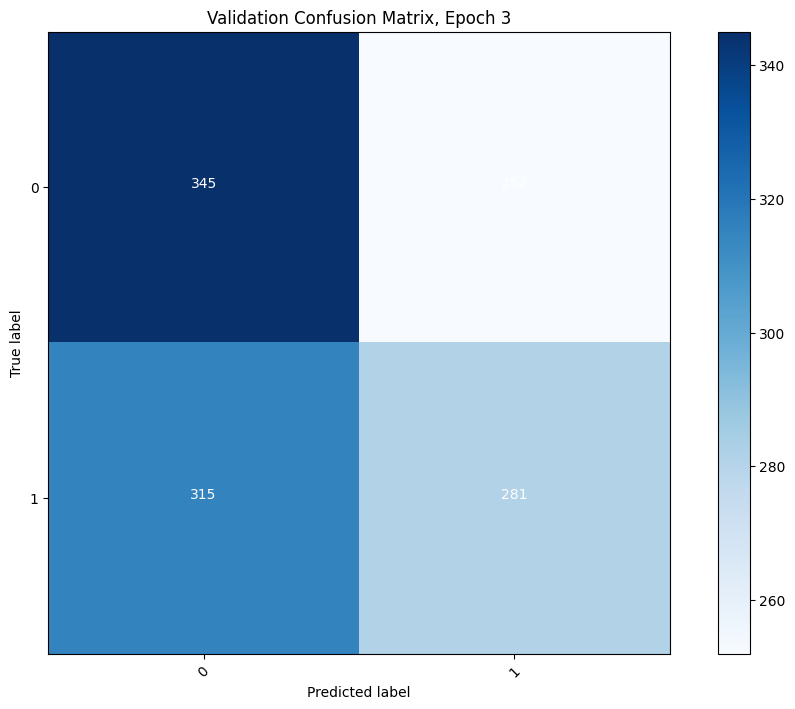

Training Epoch 4:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6935


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.5000
[[5364    0]
 [5365    0]]
Confusion matrix, without normalization


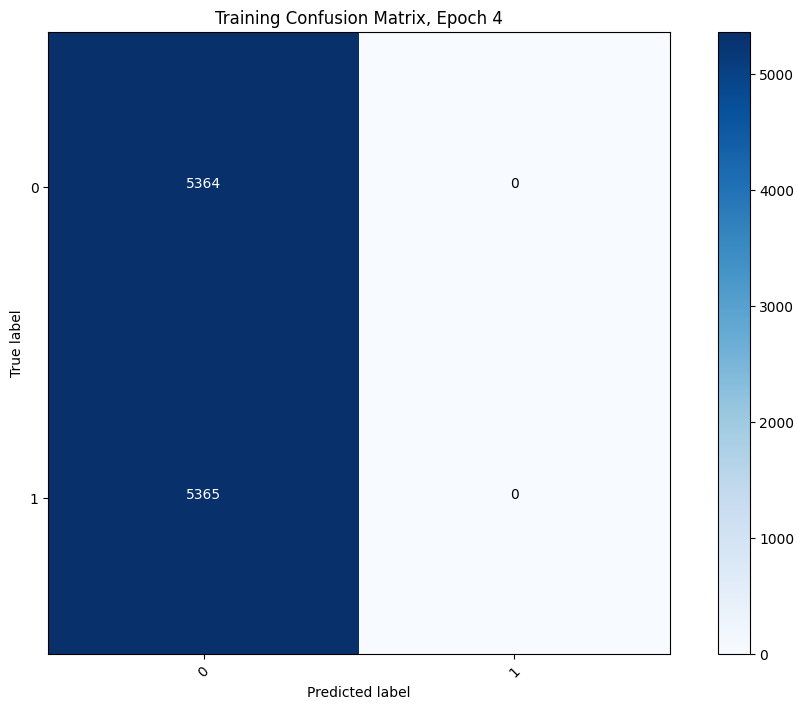

Validation Epoch 4:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6932


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5000
[[597   0]
 [596   0]]
Confusion matrix, without normalization


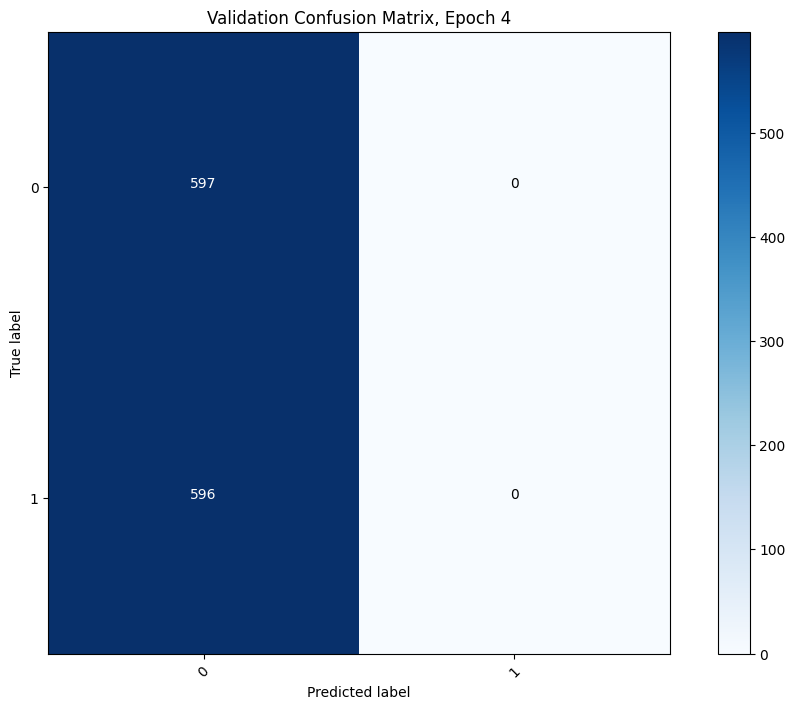

Training Epoch 5:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6935


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.5000
[[5364    0]
 [5365    0]]
Confusion matrix, without normalization


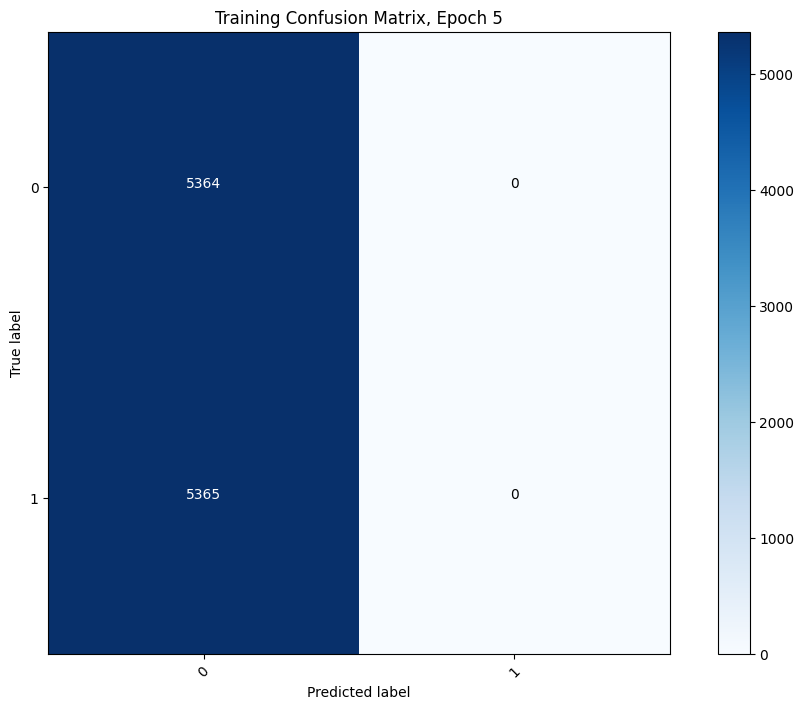

Validation Epoch 5:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6932


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5000
[[597   0]
 [596   0]]
Confusion matrix, without normalization


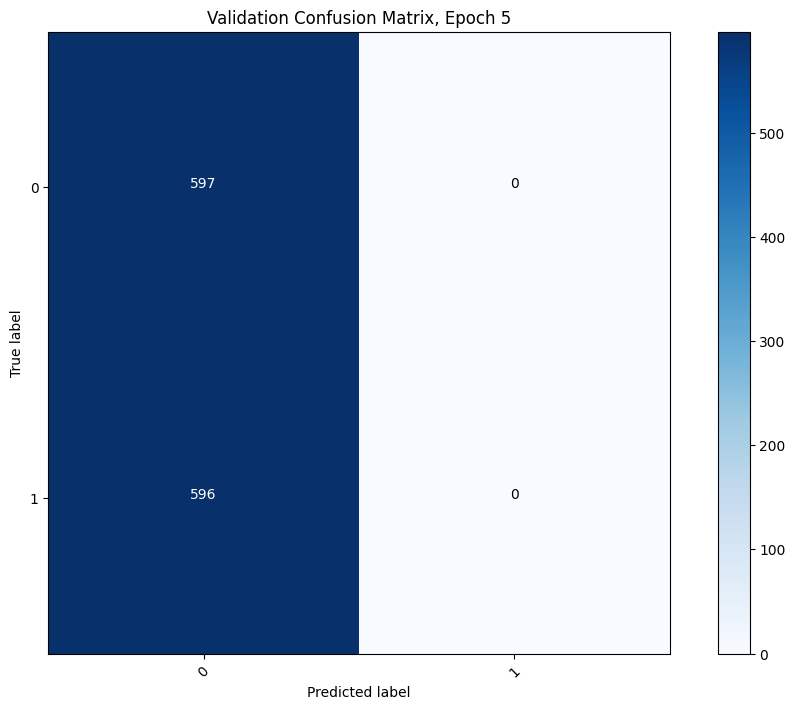

Training Epoch 6:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6931


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.5000
[[   0 5364]
 [   0 5365]]
Confusion matrix, without normalization


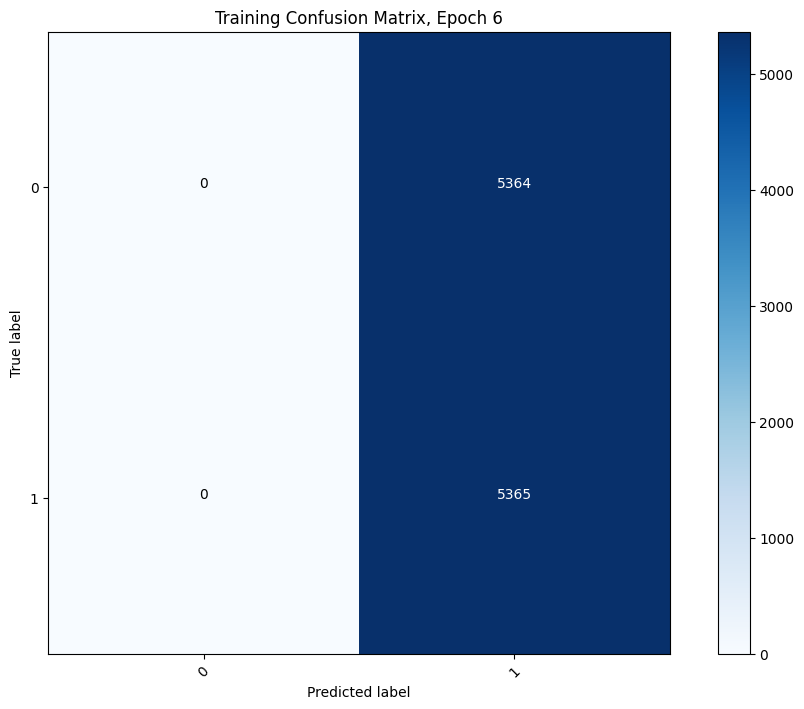

Validation Epoch 6:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6934


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5000
[[  0 597]
 [  0 596]]
Confusion matrix, without normalization


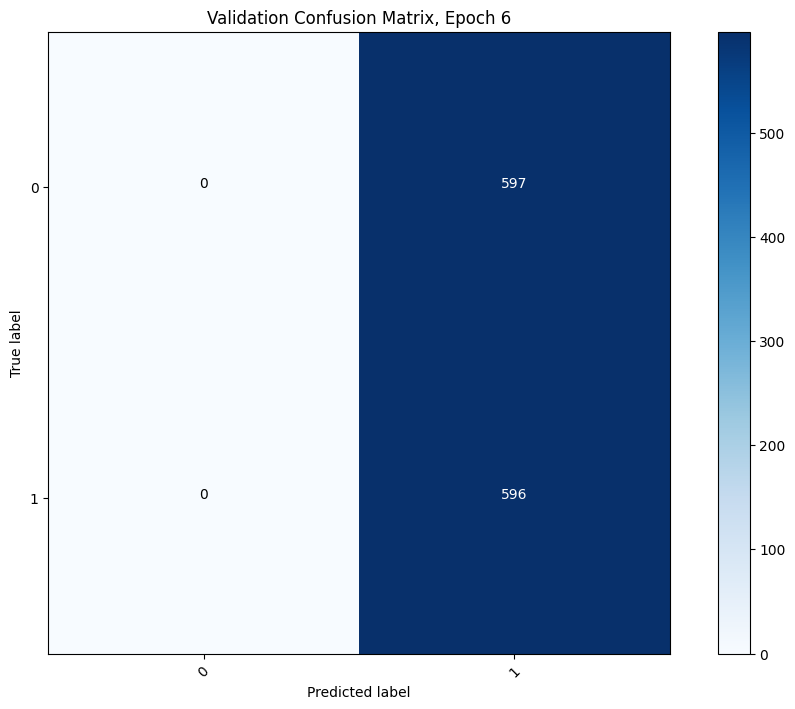

Early stopping triggered.
Fold 2/10


Training Epoch 1:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6934


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.5000
[[5365    0]
 [5364    0]]
Confusion matrix, without normalization


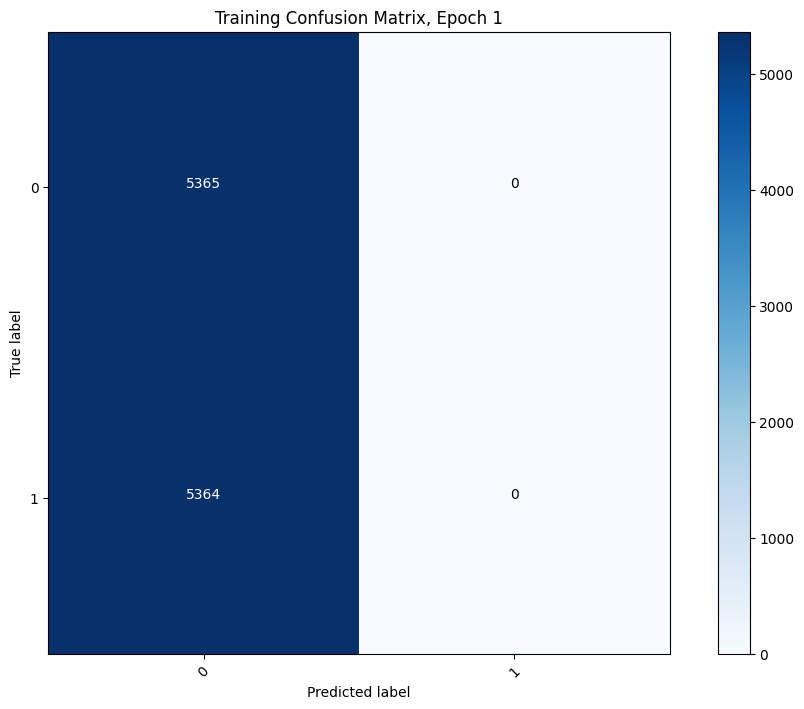

Validation Epoch 1:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6931


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5000
[[596   0]
 [597   0]]
Confusion matrix, without normalization


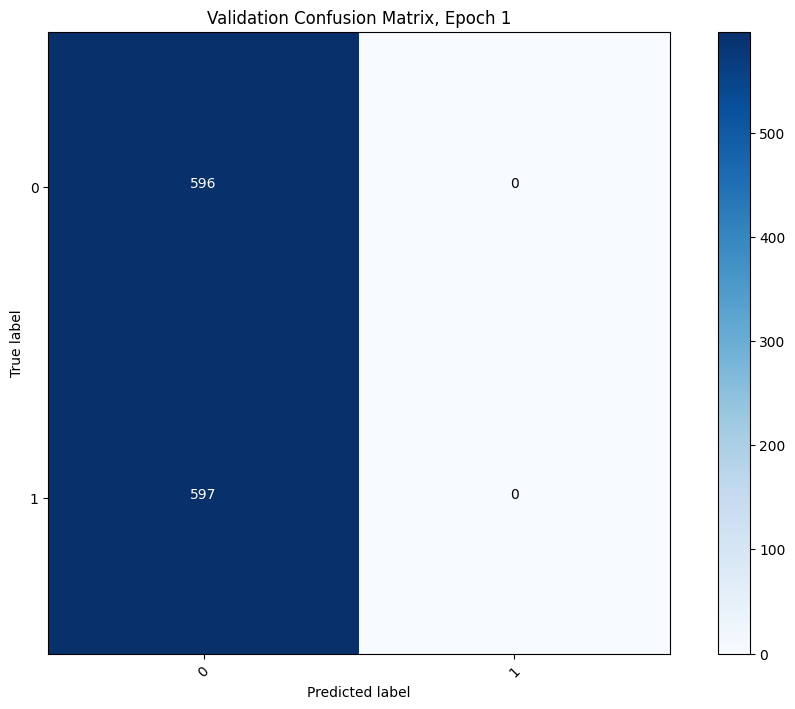

Training Epoch 2:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6936


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.5000
[[5365    0]
 [5364    0]]
Confusion matrix, without normalization


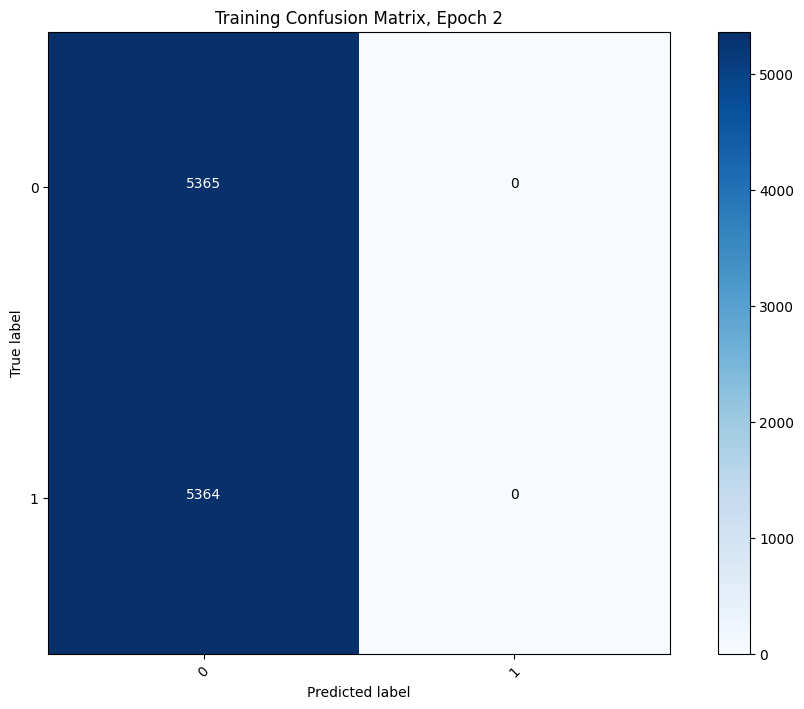

Validation Epoch 2:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6932


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5000
[[596   0]
 [597   0]]
Confusion matrix, without normalization


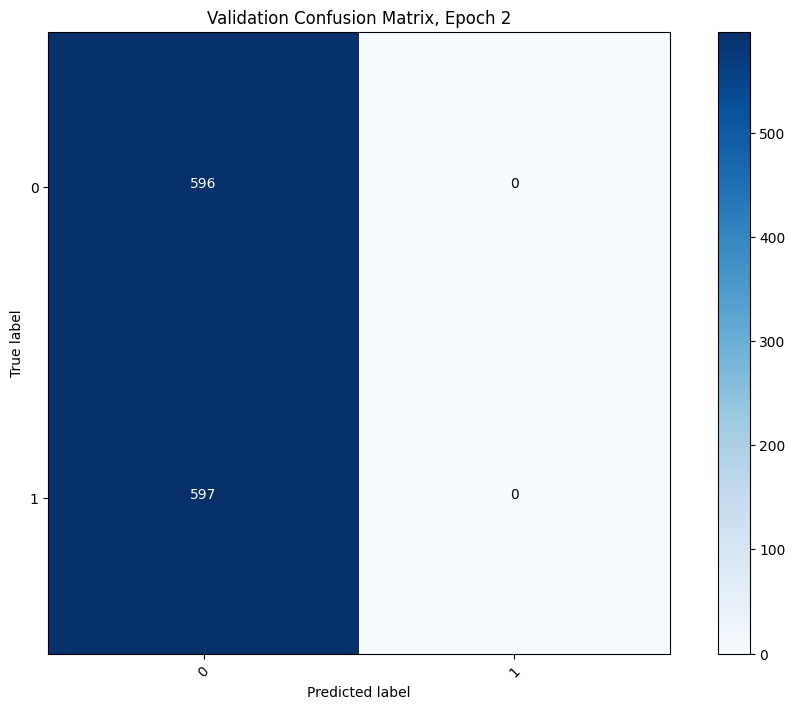

Training Epoch 3:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6932


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.5000
[[5365    0]
 [5364    0]]
Confusion matrix, without normalization


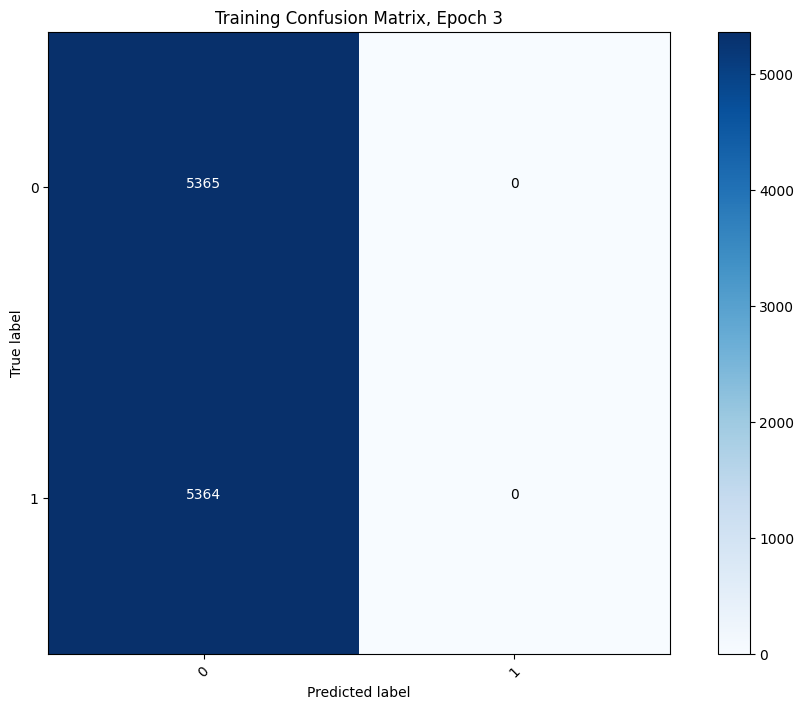

Validation Epoch 3:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6936


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5000
[[596   0]
 [597   0]]
Confusion matrix, without normalization


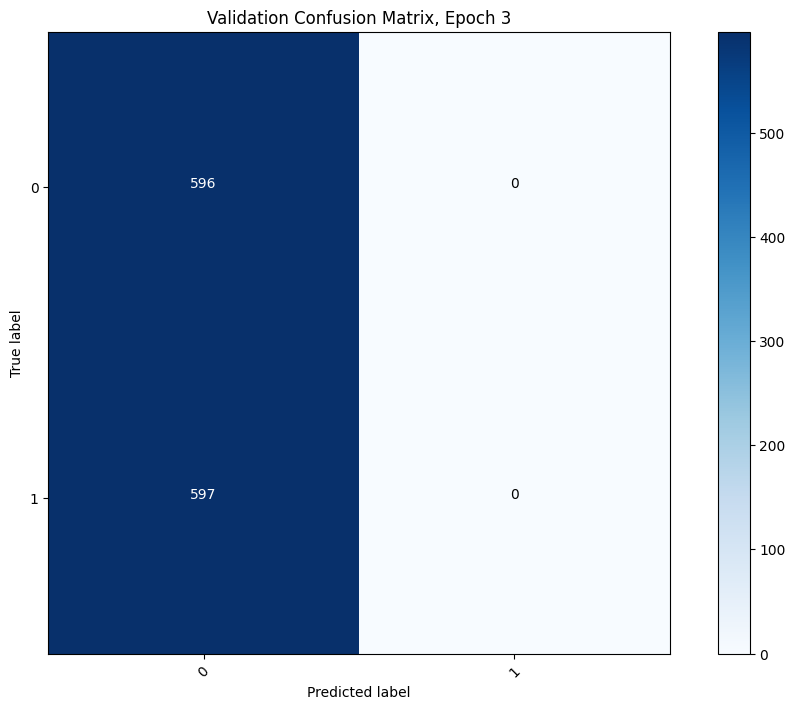

Training Epoch 4:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6933


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.5000
[[5365    0]
 [5364    0]]
Confusion matrix, without normalization


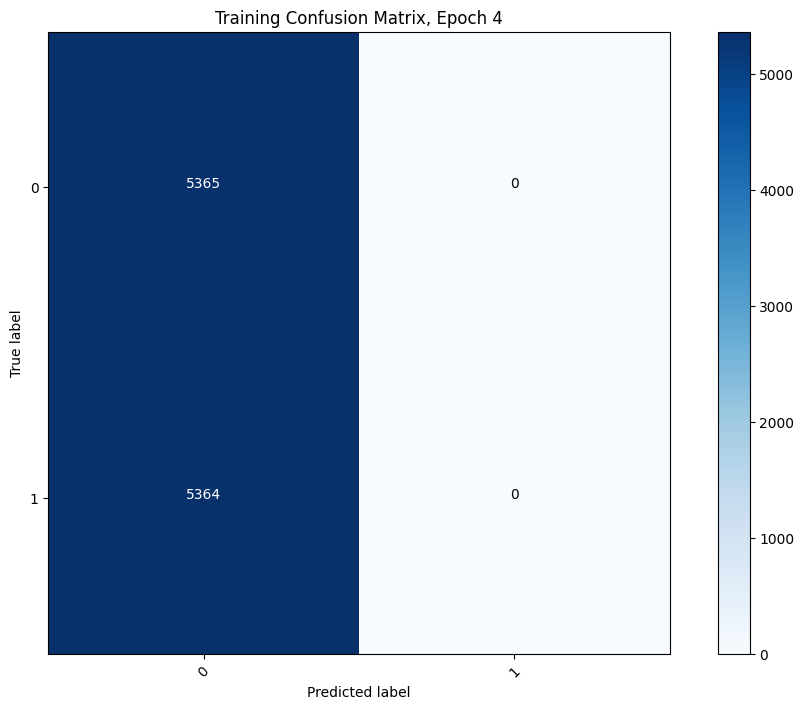

Validation Epoch 4:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6932


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5000
[[596   0]
 [597   0]]
Confusion matrix, without normalization


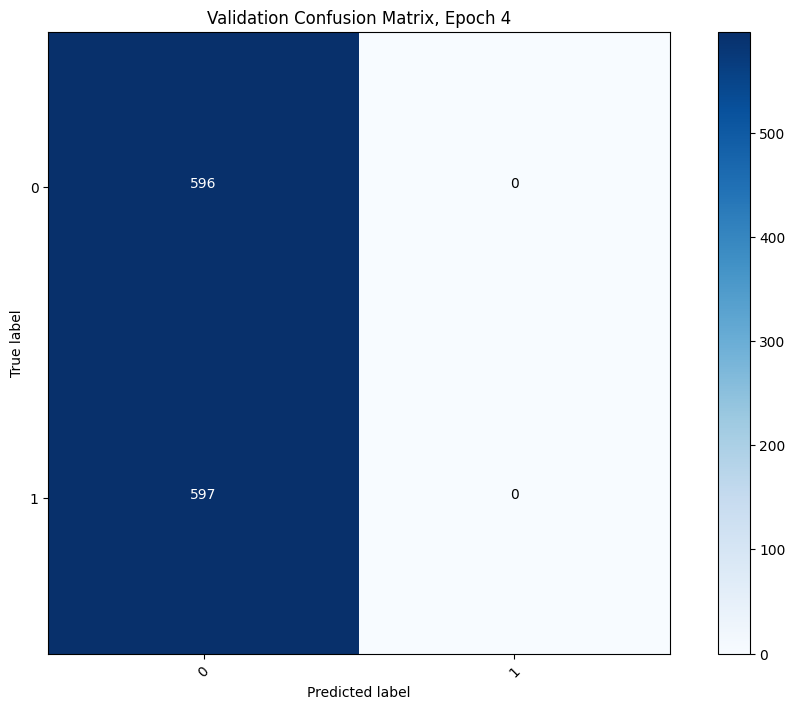

Early stopping triggered.
Fold 3/10


Training Epoch 1:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6925


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.5000
[[   0 5365]
 [   0 5365]]
Confusion matrix, without normalization


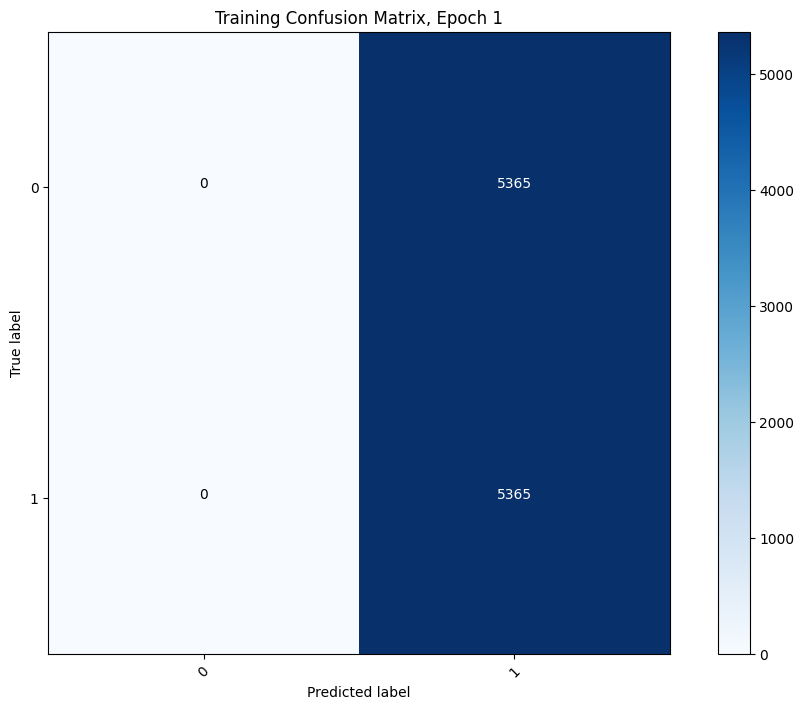

Validation Epoch 1:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6937


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5000
[[  0 596]
 [  0 596]]
Confusion matrix, without normalization


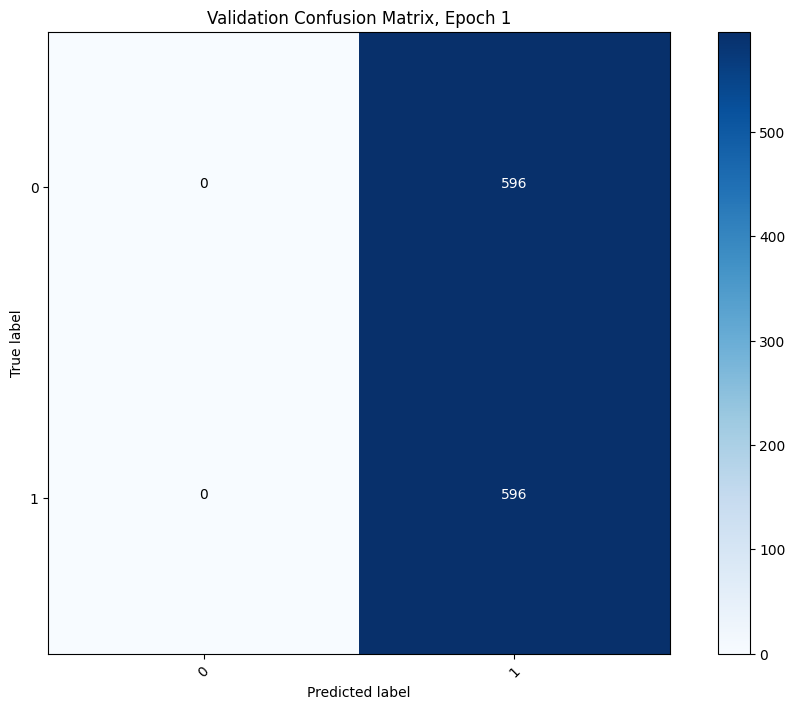

Training Epoch 2:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6934


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.5000
[[5365    0]
 [5365    0]]
Confusion matrix, without normalization


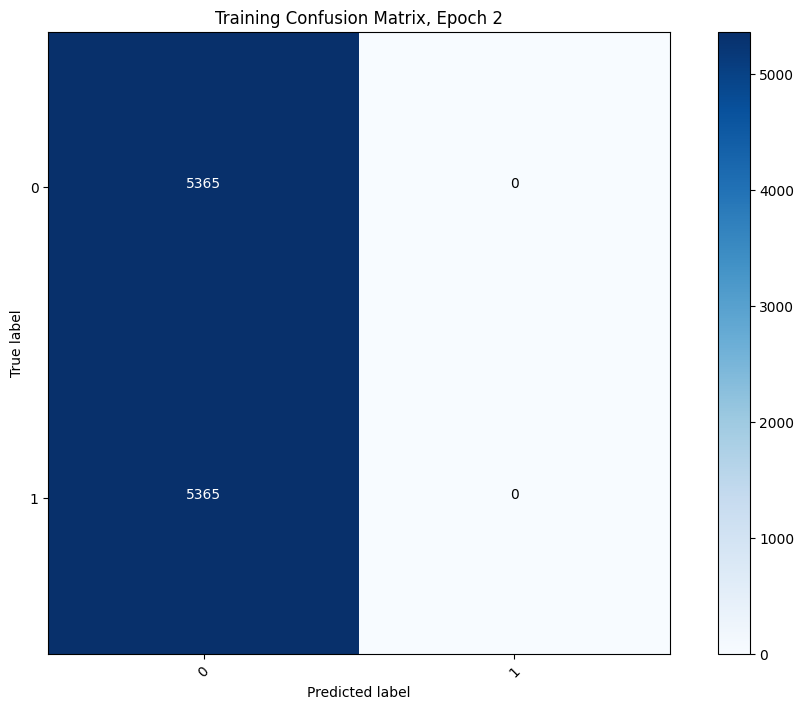

Validation Epoch 2:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6934


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5000
[[596   0]
 [596   0]]
Confusion matrix, without normalization


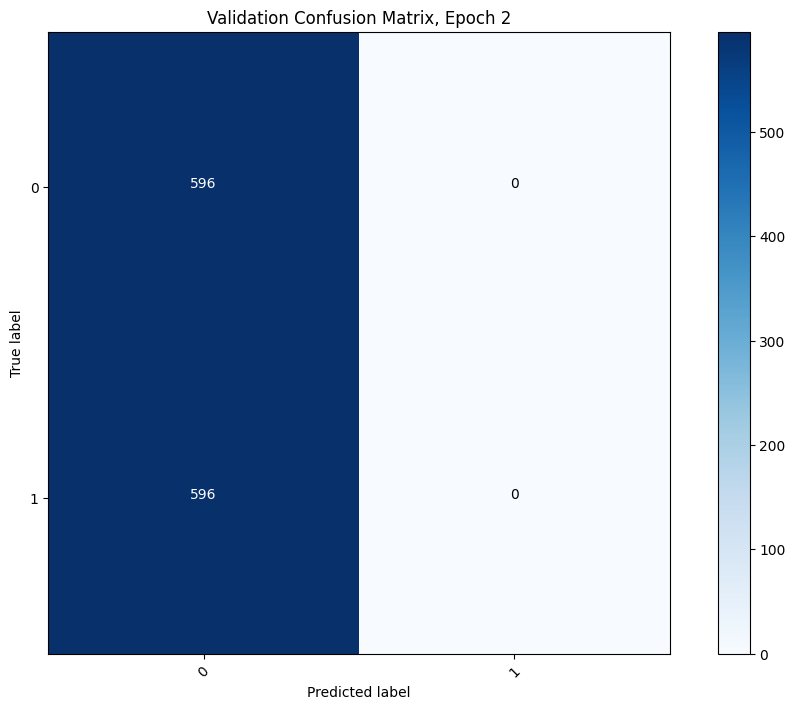

Training Epoch 3:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6934


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.5755
[[3558 1807]
 [2748 2617]]
Confusion matrix, without normalization


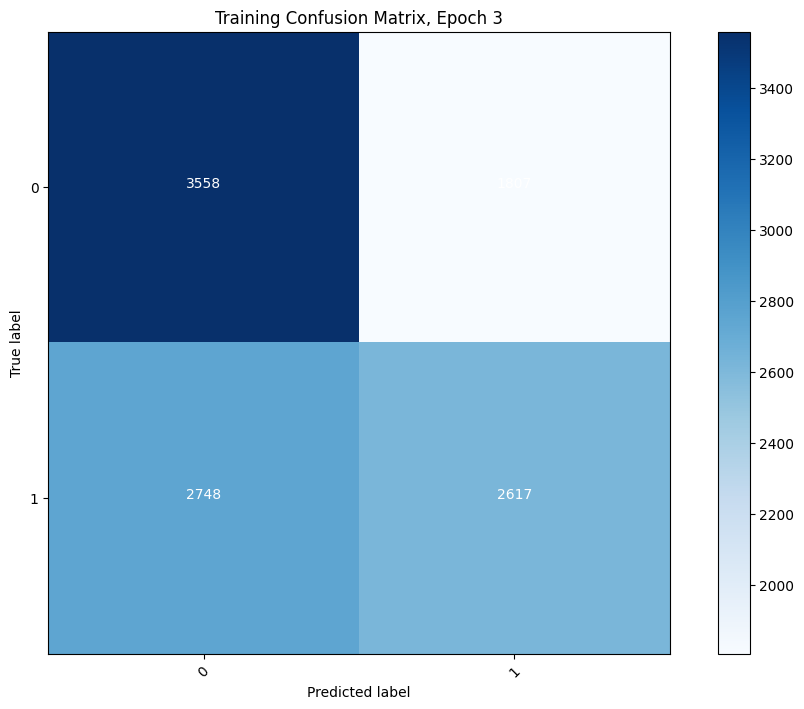

Validation Epoch 3:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6915


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5369
[[375 221]
 [331 265]]
Confusion matrix, without normalization


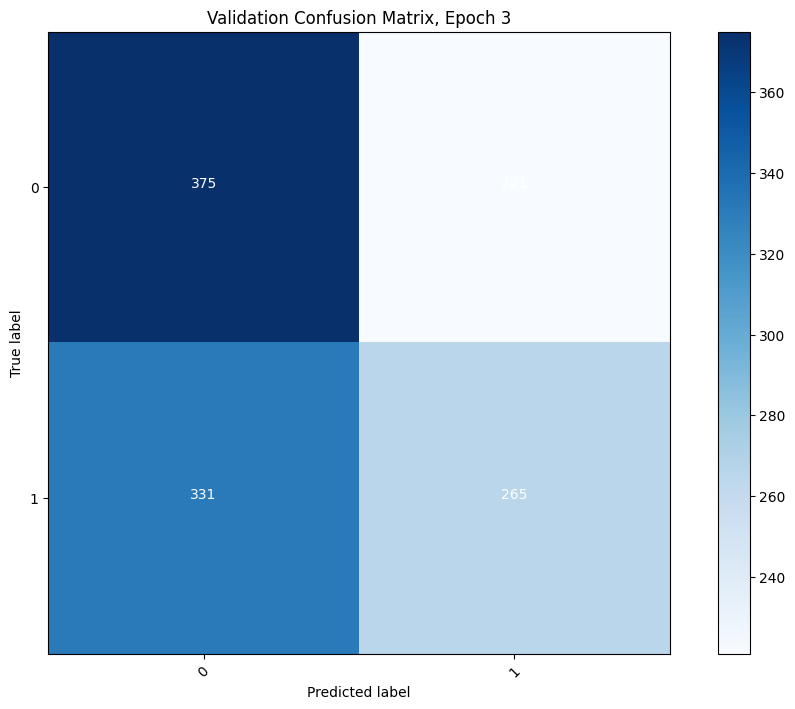

Training Epoch 4:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6933


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.5000
[[   0 5365]
 [   0 5365]]
Confusion matrix, without normalization


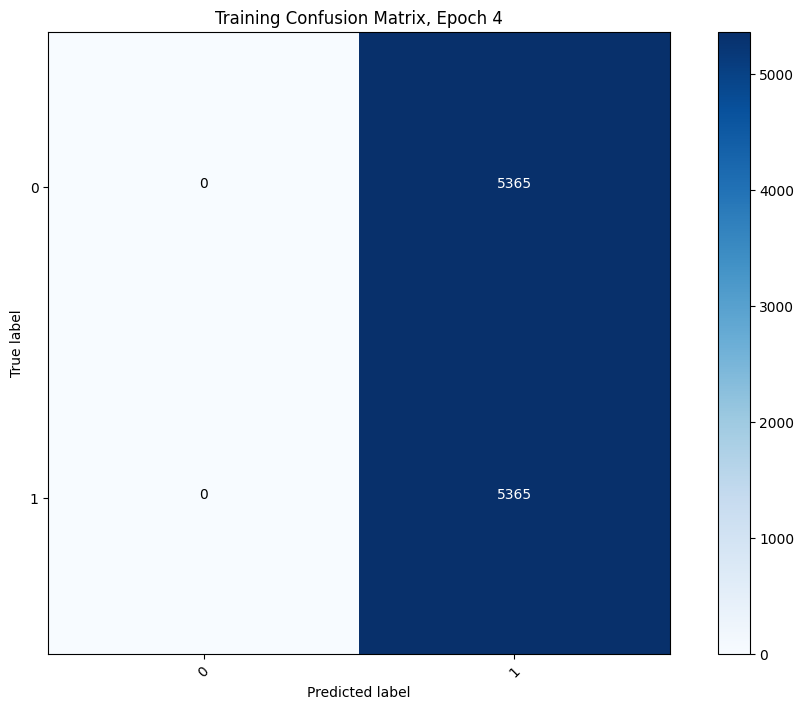

Validation Epoch 4:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6932


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5000
[[  0 596]
 [  0 596]]
Confusion matrix, without normalization


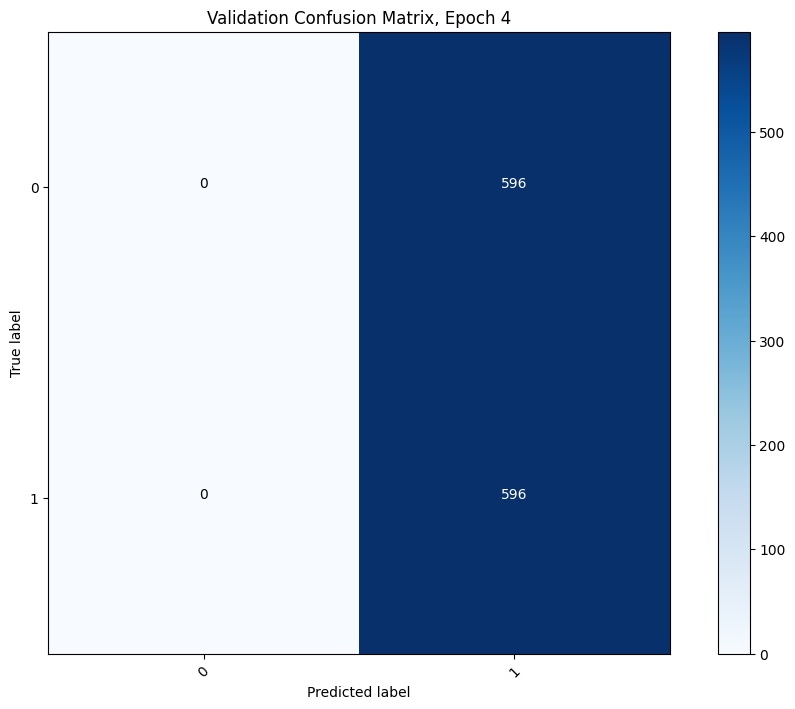

Training Epoch 5:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6933


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.5000
[[   0 5365]
 [   0 5365]]
Confusion matrix, without normalization


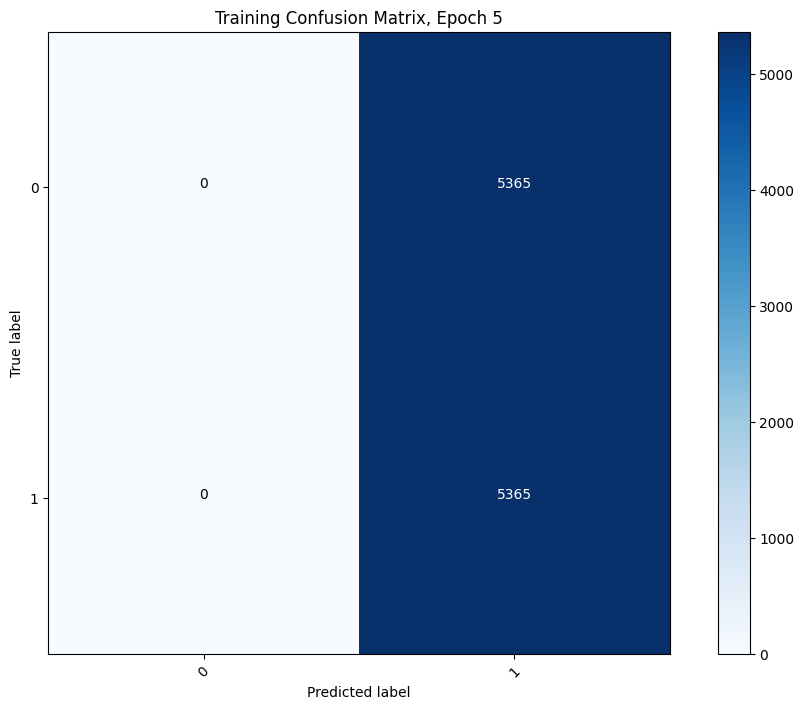

Validation Epoch 5:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6931


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5000
[[  0 596]
 [  0 596]]
Confusion matrix, without normalization


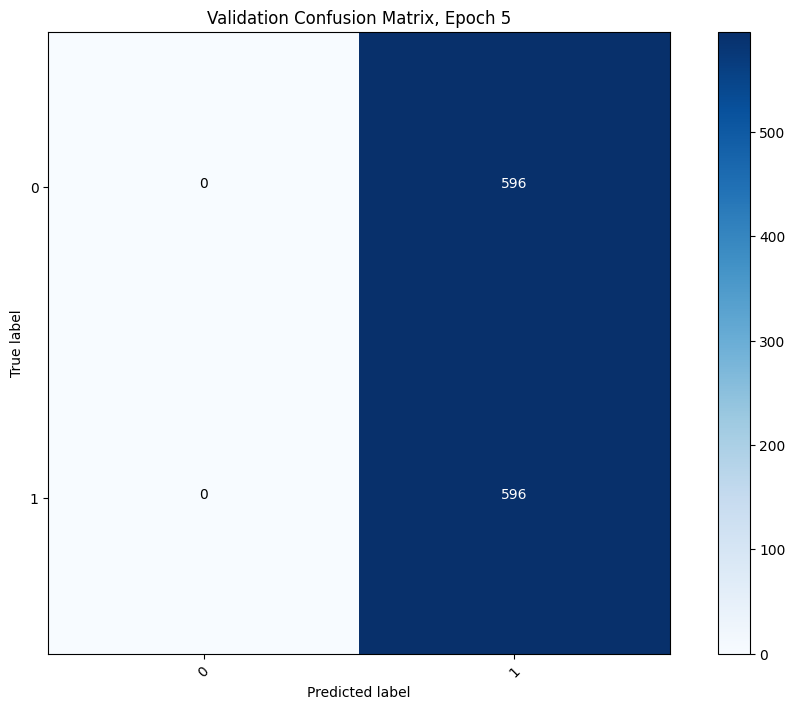

Training Epoch 6:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6932


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.5000
[[   0 5365]
 [   0 5365]]
Confusion matrix, without normalization


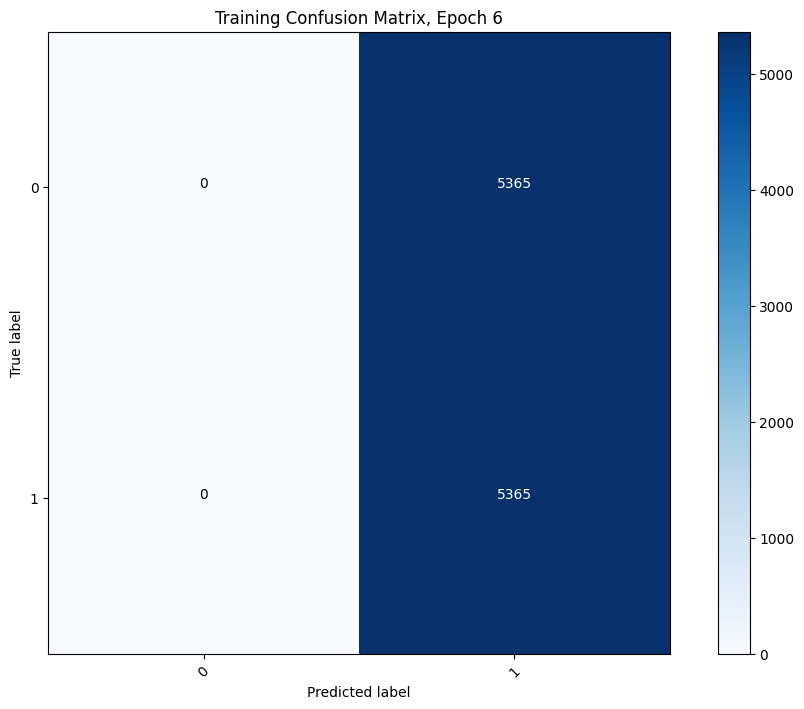

Validation Epoch 6:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6932


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5000
[[  0 596]
 [  0 596]]
Confusion matrix, without normalization


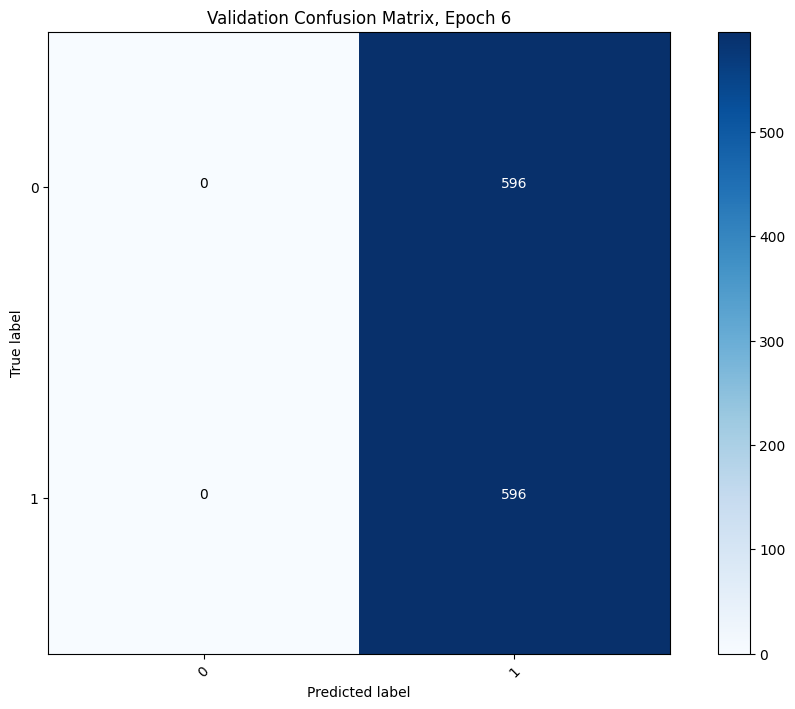

Early stopping triggered.
Fold 4/10


Training Epoch 1:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6858


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.6414
[[3212 2153]
 [1695 3670]]
Confusion matrix, without normalization


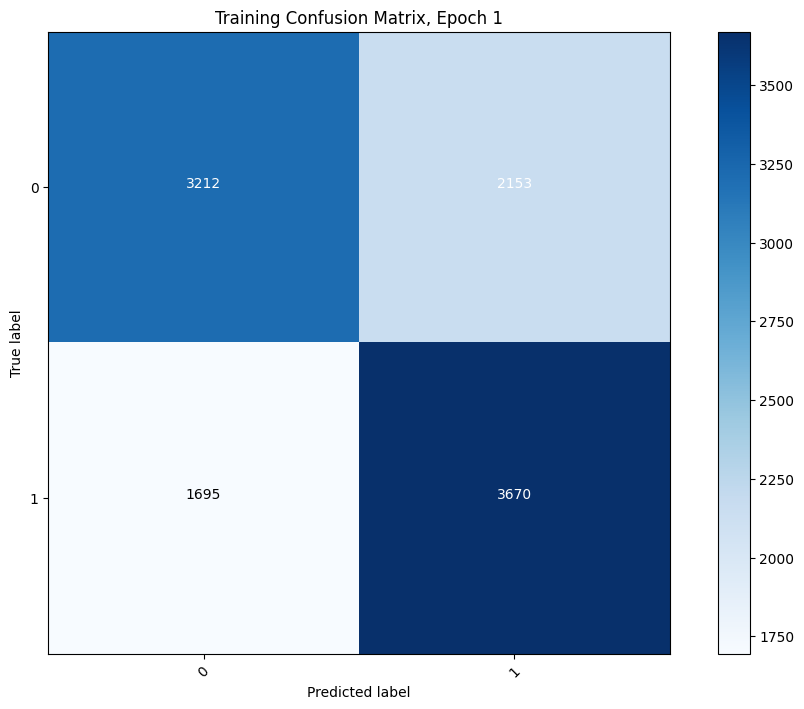

Validation Epoch 1:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6754


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5822
[[344 252]
 [246 350]]
Confusion matrix, without normalization


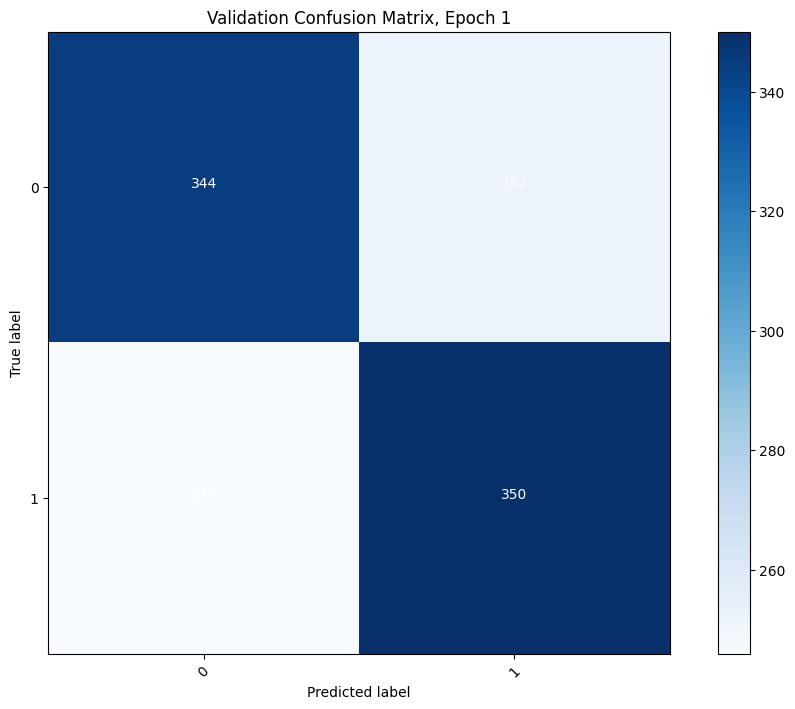

Training Epoch 2:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6475


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.6839
[[2499 2866]
 [ 526 4839]]
Confusion matrix, without normalization


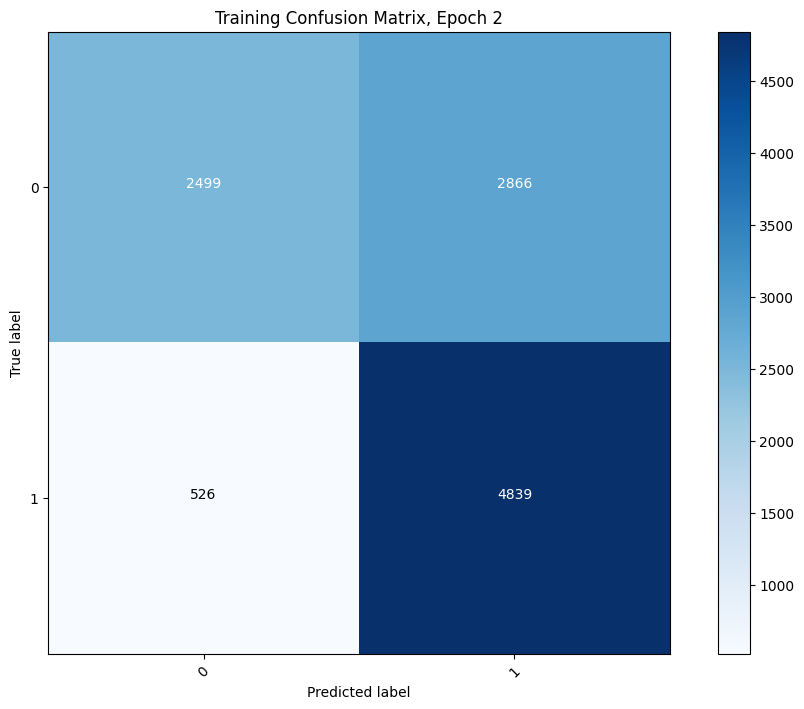

Validation Epoch 2:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6673


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5889
[[219 377]
 [113 483]]
Confusion matrix, without normalization


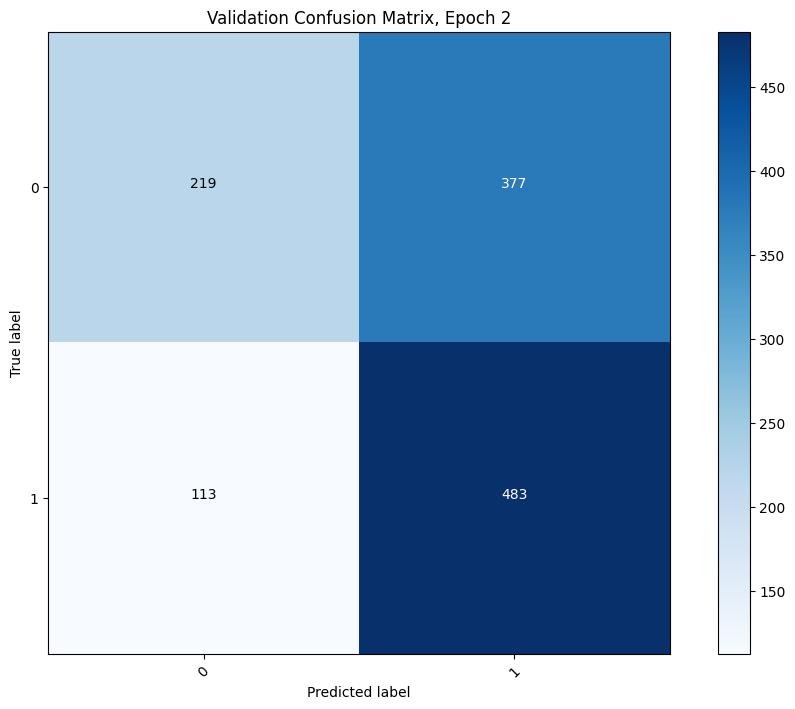

Training Epoch 3:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.5807


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.8164
[[4362 1003]
 [ 967 4398]]
Confusion matrix, without normalization


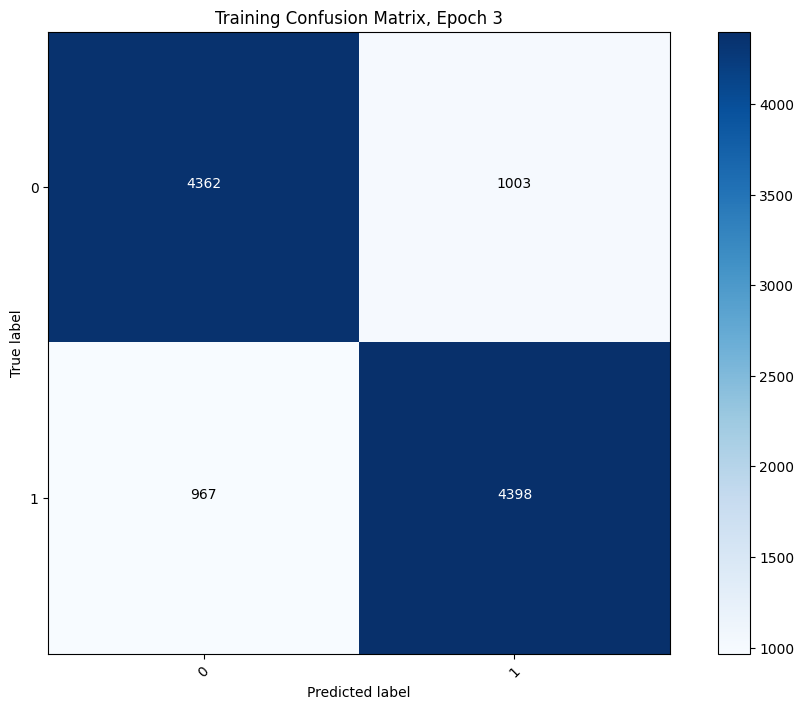

Validation Epoch 3:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6870


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.6124
[[385 211]
 [251 345]]
Confusion matrix, without normalization


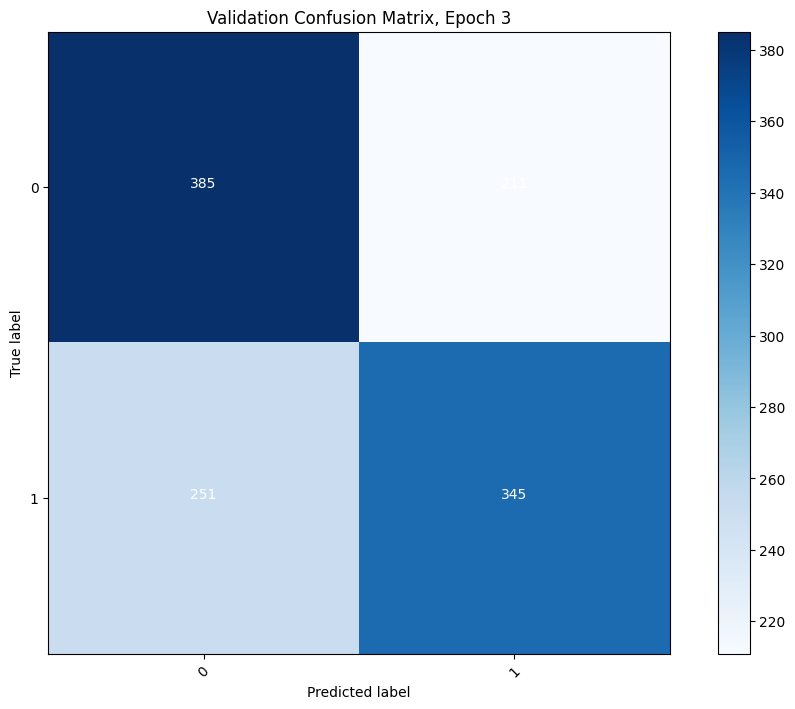

Training Epoch 4:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.4743


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.8690
[[4115 1250]
 [ 156 5209]]
Confusion matrix, without normalization


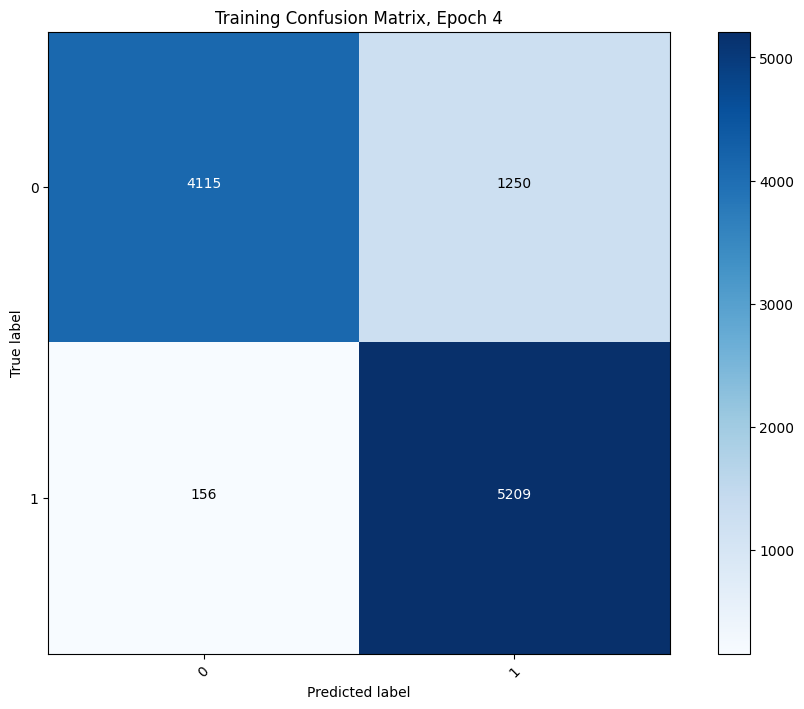

Validation Epoch 4:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.7870


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5923
[[274 322]
 [164 432]]
Confusion matrix, without normalization


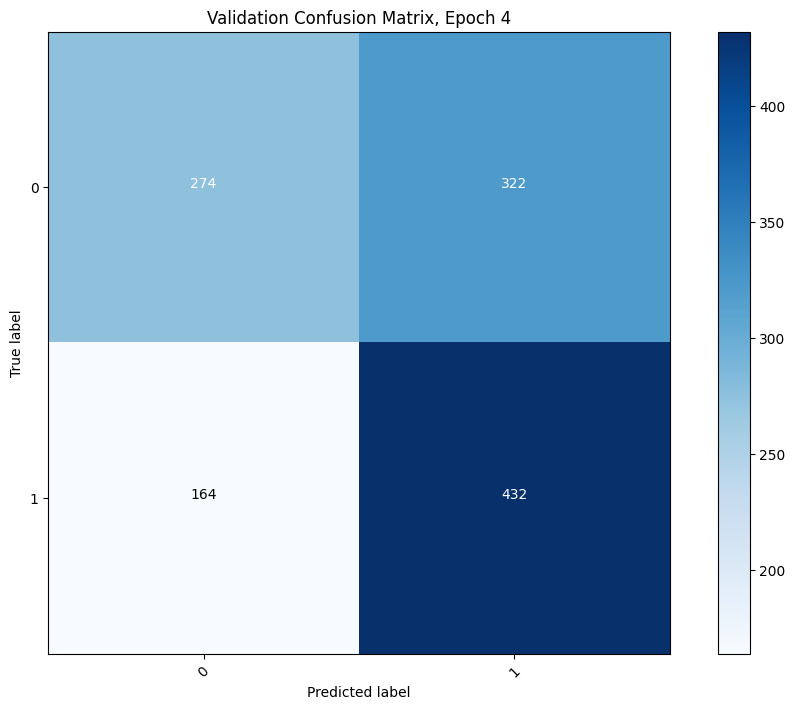

Training Epoch 5:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.3494


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.9377
[[4793  572]
 [  96 5269]]
Confusion matrix, without normalization


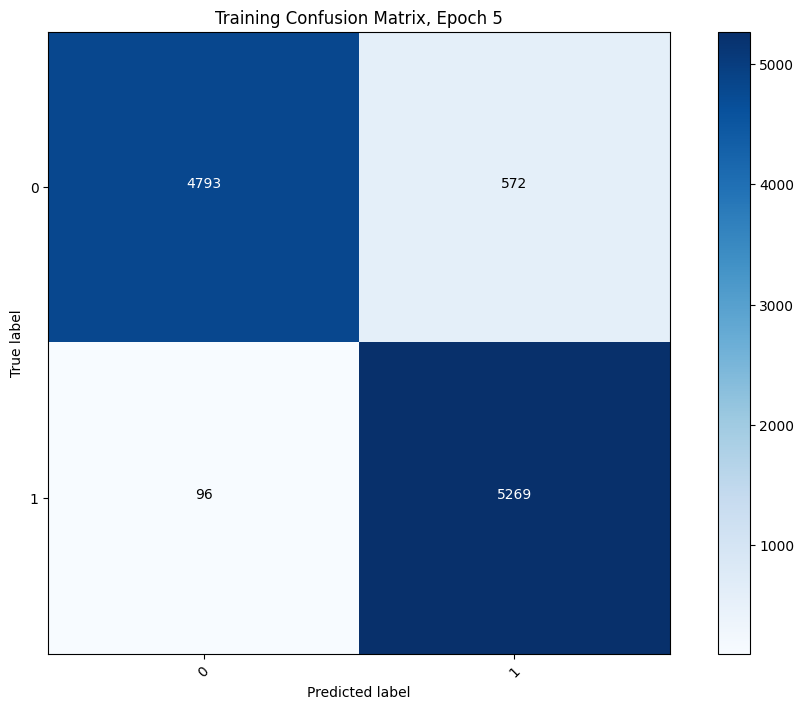

Validation Epoch 5:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.9683


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.6007
[[323 273]
 [203 393]]
Confusion matrix, without normalization


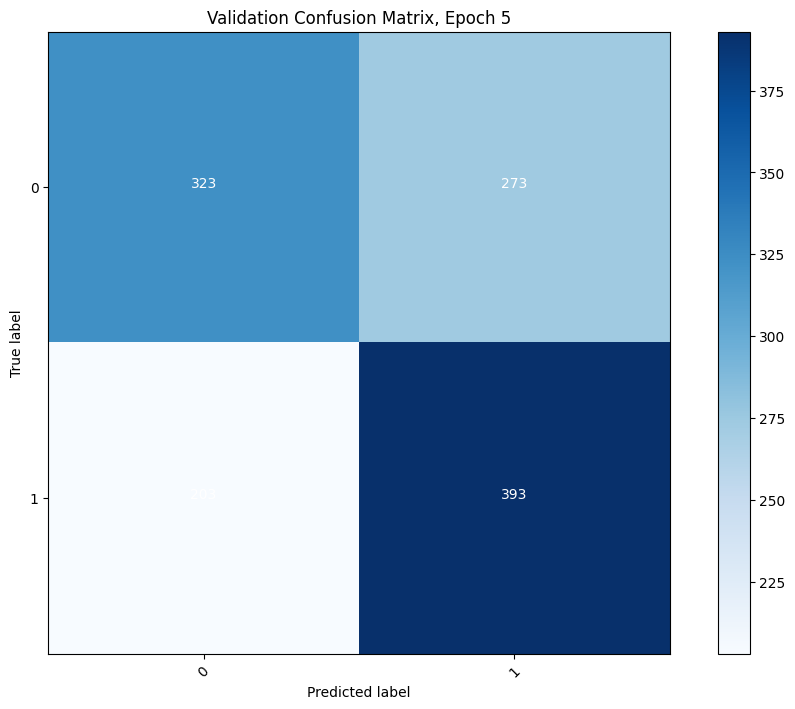

Early stopping triggered.
Fold 5/10


Training Epoch 1:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6921


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.5170
[[5203  162]
 [5021  344]]
Confusion matrix, without normalization


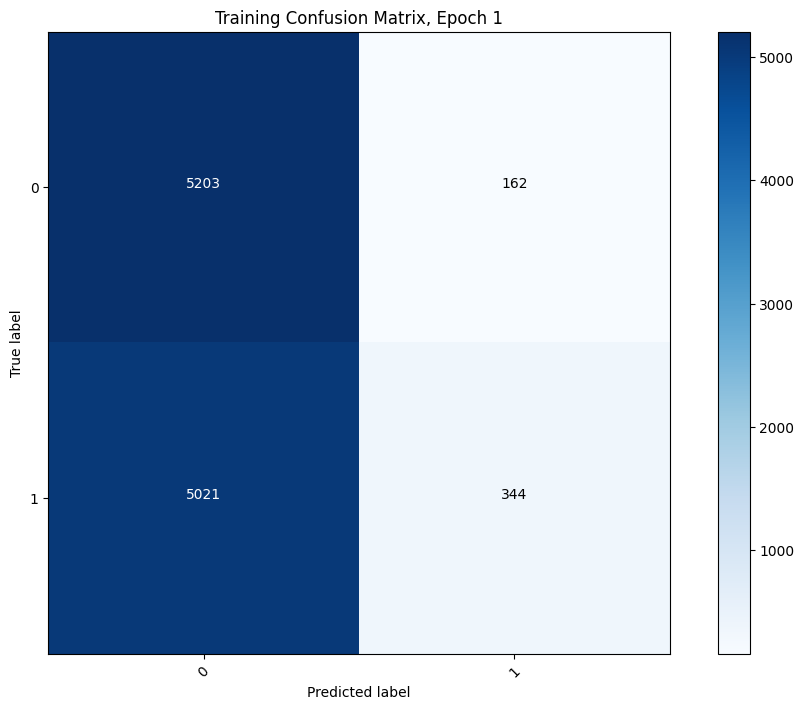

Validation Epoch 1:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6931


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5109
[[580  16]
 [567  29]]
Confusion matrix, without normalization


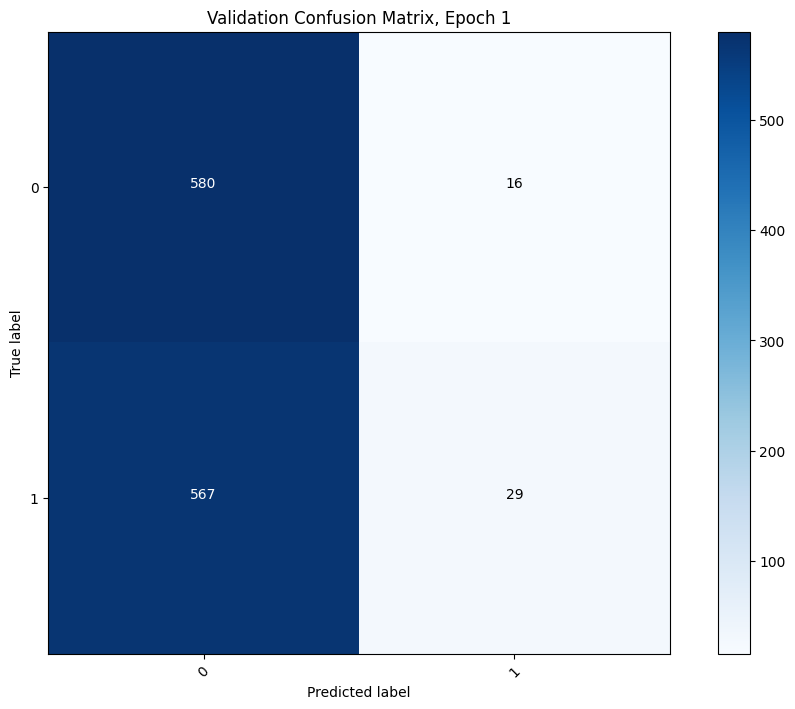

Training Epoch 2:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6927


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.5000
[[   0 5365]
 [   0 5365]]
Confusion matrix, without normalization


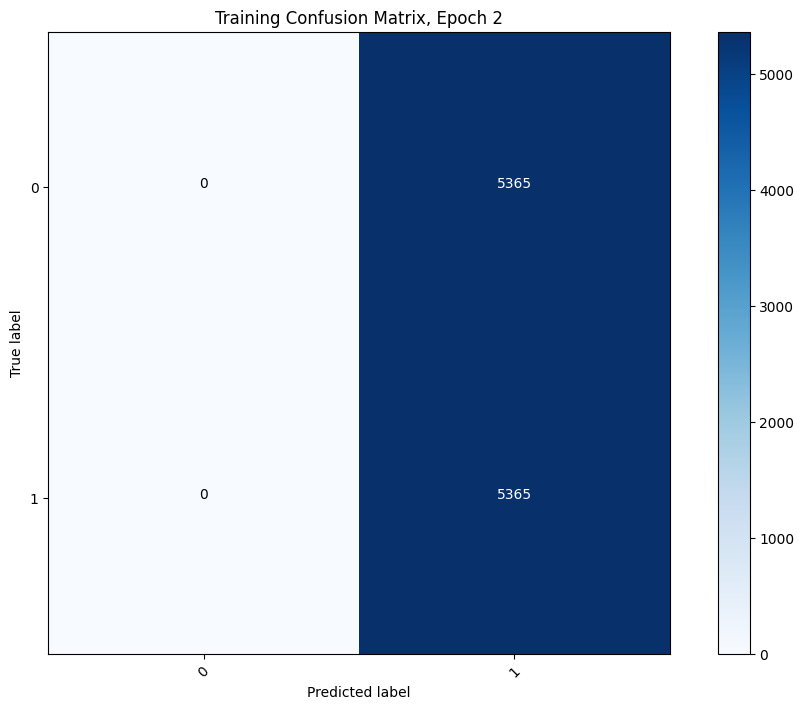

Validation Epoch 2:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6931


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5000
[[  0 596]
 [  0 596]]
Confusion matrix, without normalization


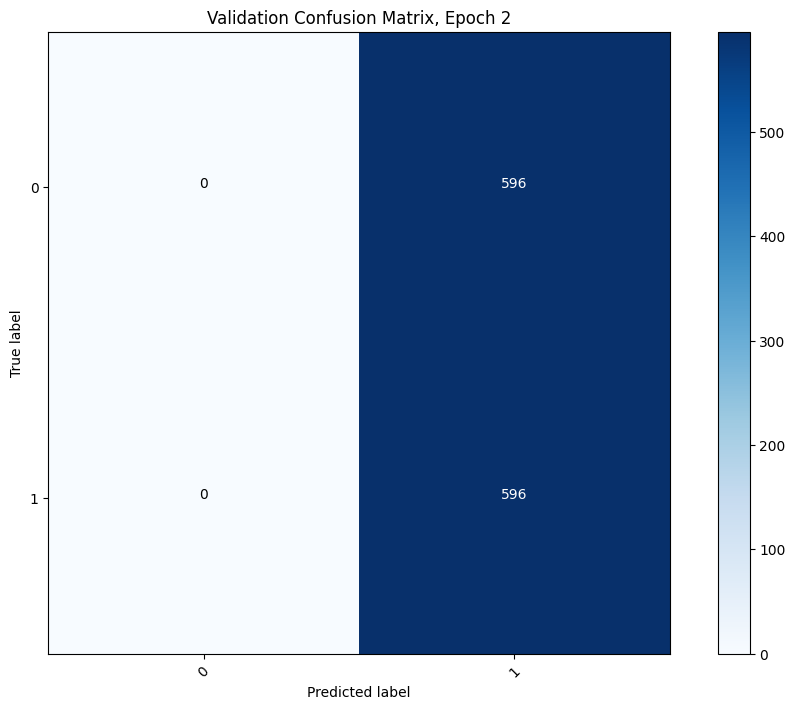

Training Epoch 3:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6936


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.5000
[[5365    0]
 [5365    0]]
Confusion matrix, without normalization


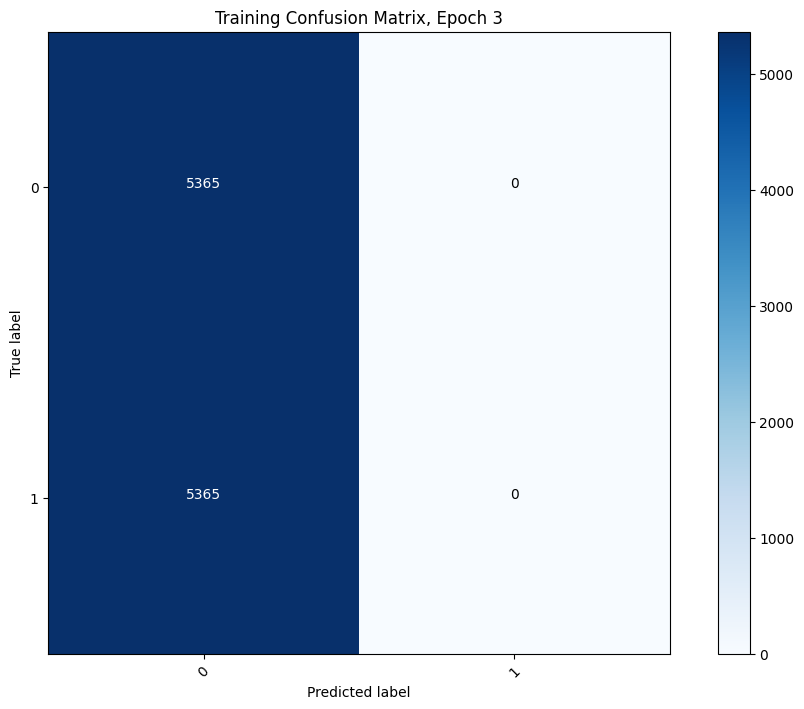

Validation Epoch 3:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6932


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5000
[[596   0]
 [596   0]]
Confusion matrix, without normalization


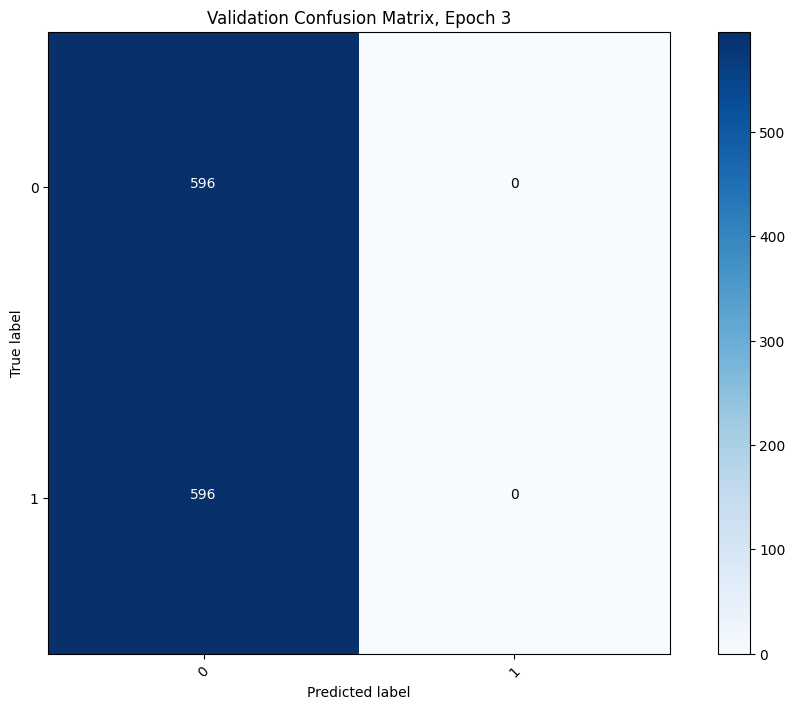

Training Epoch 4:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6931


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.5000
[[5365    0]
 [5365    0]]
Confusion matrix, without normalization


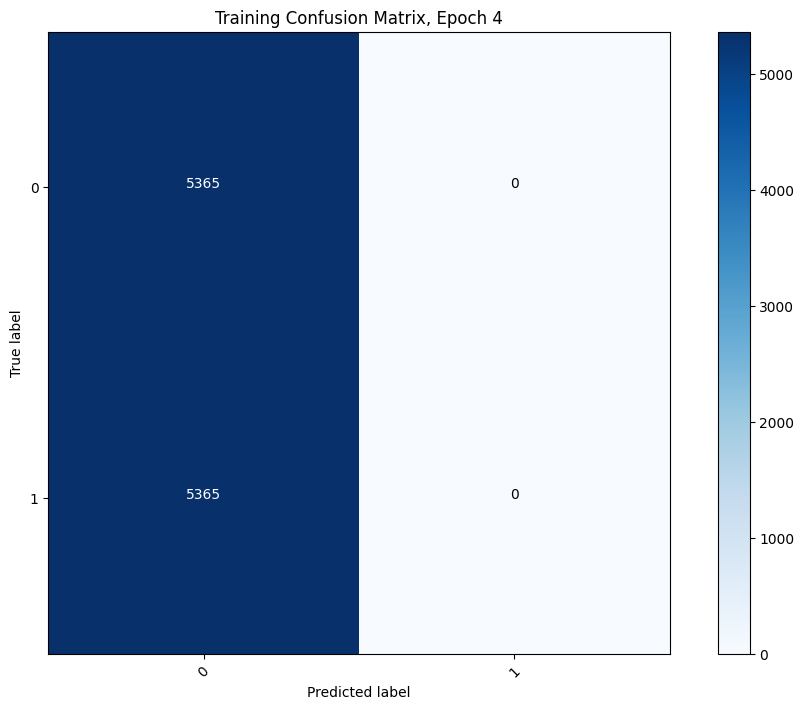

Validation Epoch 4:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6942


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5000
[[596   0]
 [596   0]]
Confusion matrix, without normalization


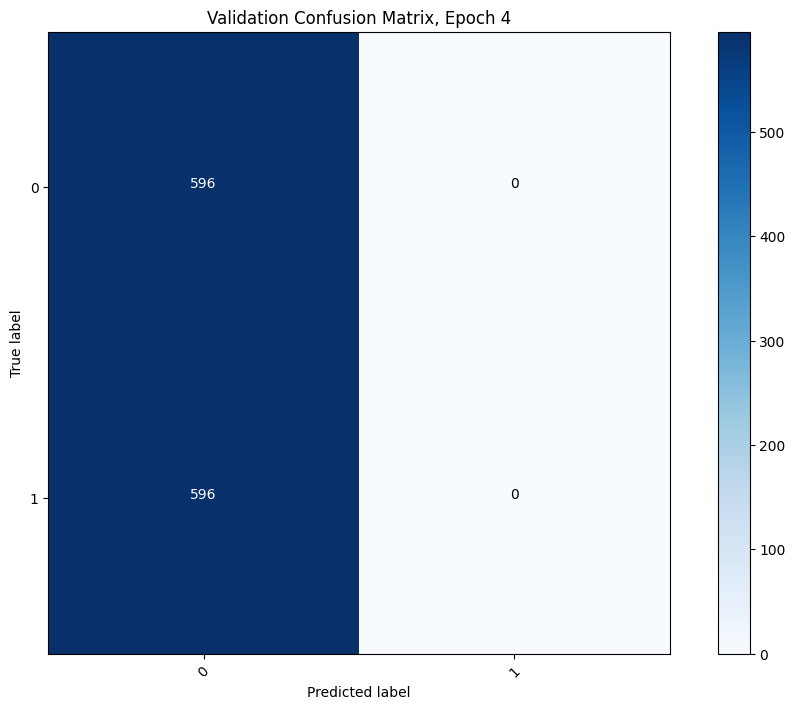

Early stopping triggered.
Fold 6/10


Training Epoch 1:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6856


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.6288
[[3196 2169]
 [1814 3551]]
Confusion matrix, without normalization


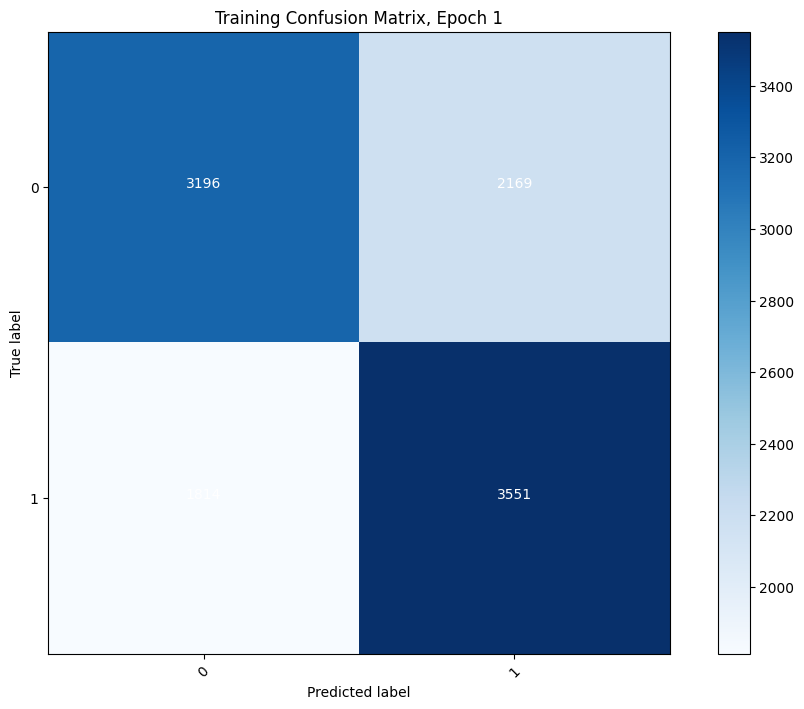

Validation Epoch 1:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6672


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.6065
[[344 252]
 [217 379]]
Confusion matrix, without normalization


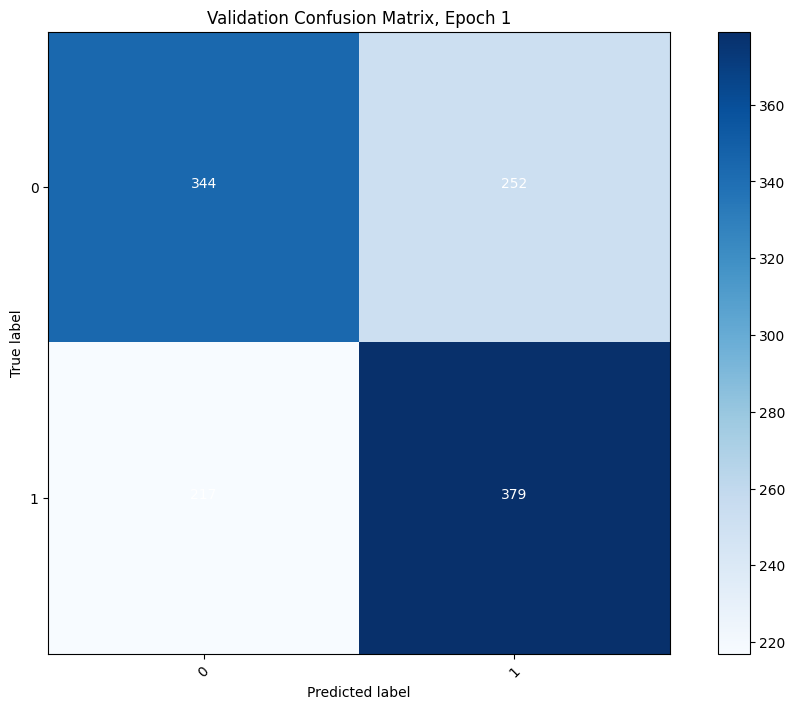

Training Epoch 2:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6545


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.7107
[[3833 1532]
 [1572 3793]]
Confusion matrix, without normalization


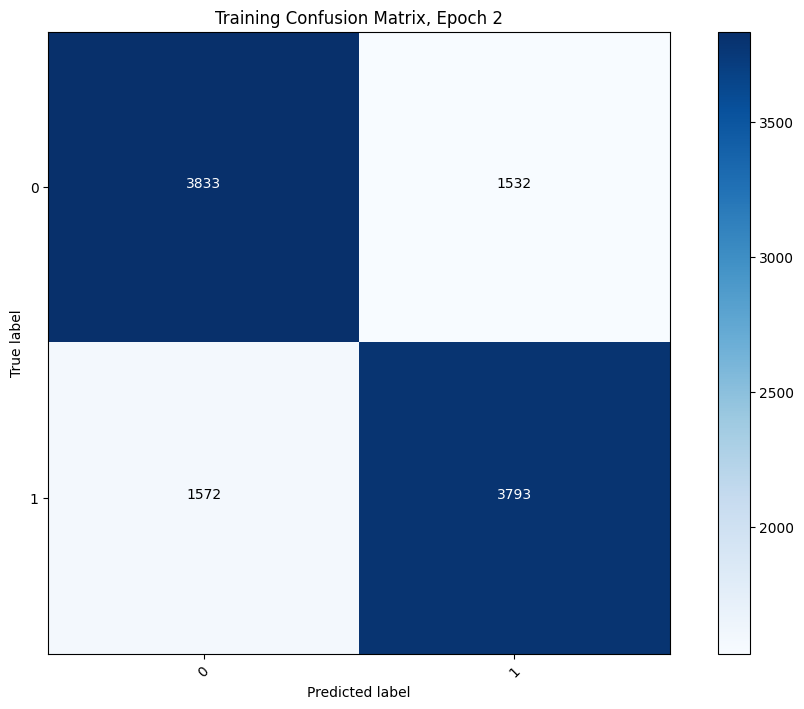

Validation Epoch 2:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6479


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.6208
[[378 218]
 [234 362]]
Confusion matrix, without normalization


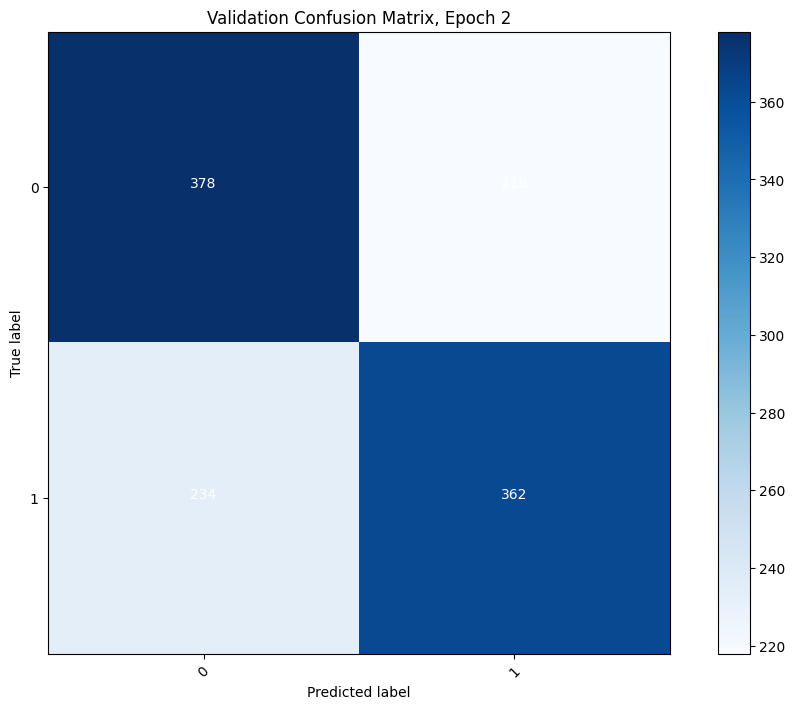

Training Epoch 3:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.5939


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.7986
[[4396  969]
 [1192 4173]]
Confusion matrix, without normalization


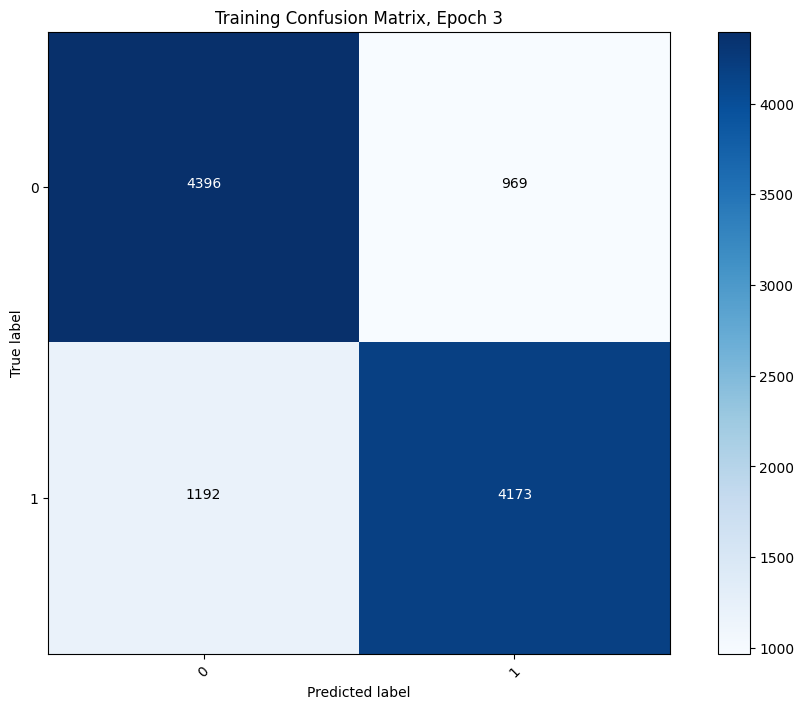

Validation Epoch 3:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6678


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.6292
[[407 189]
 [253 343]]
Confusion matrix, without normalization


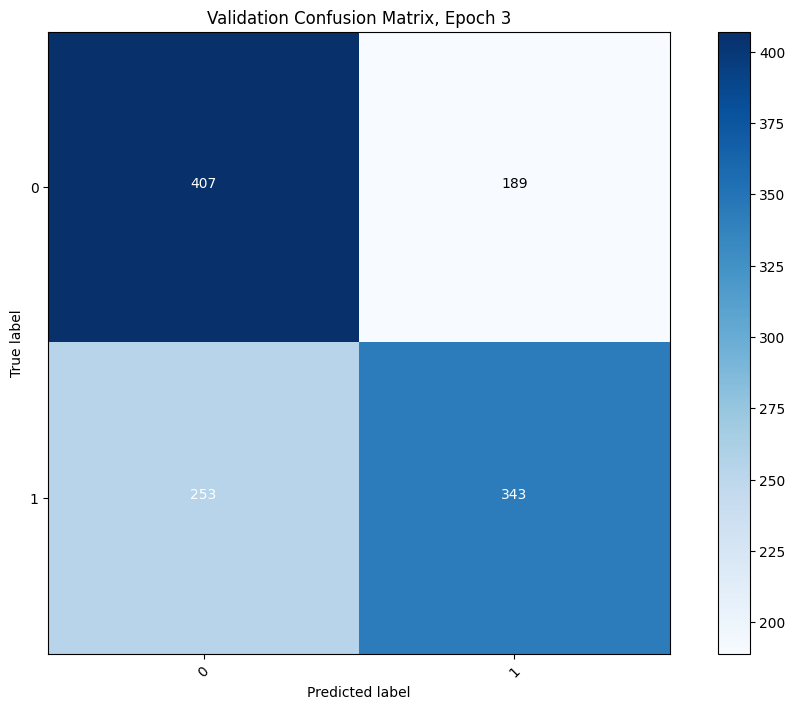

Training Epoch 4:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.4978


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.8890
[[4786  579]
 [ 612 4753]]
Confusion matrix, without normalization


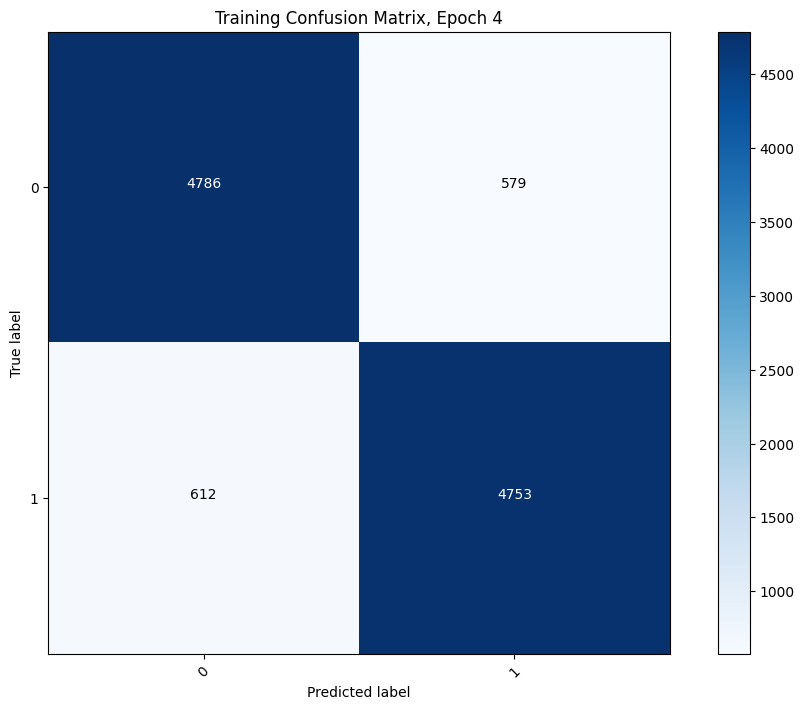

Validation Epoch 4:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.7142


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.6216
[[390 206]
 [245 351]]
Confusion matrix, without normalization


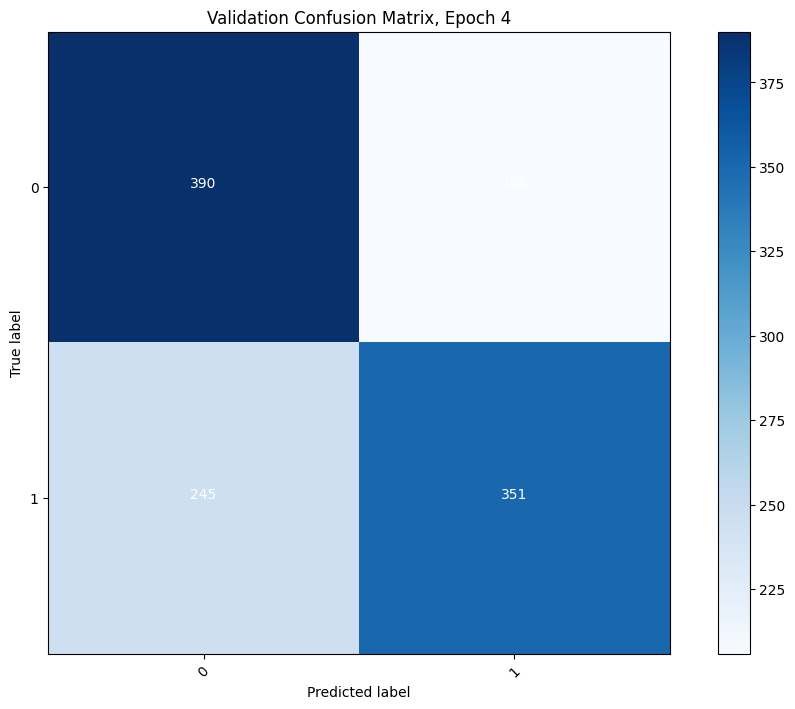

Training Epoch 5:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.3726


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.9337
[[4805  560]
 [ 151 5214]]
Confusion matrix, without normalization


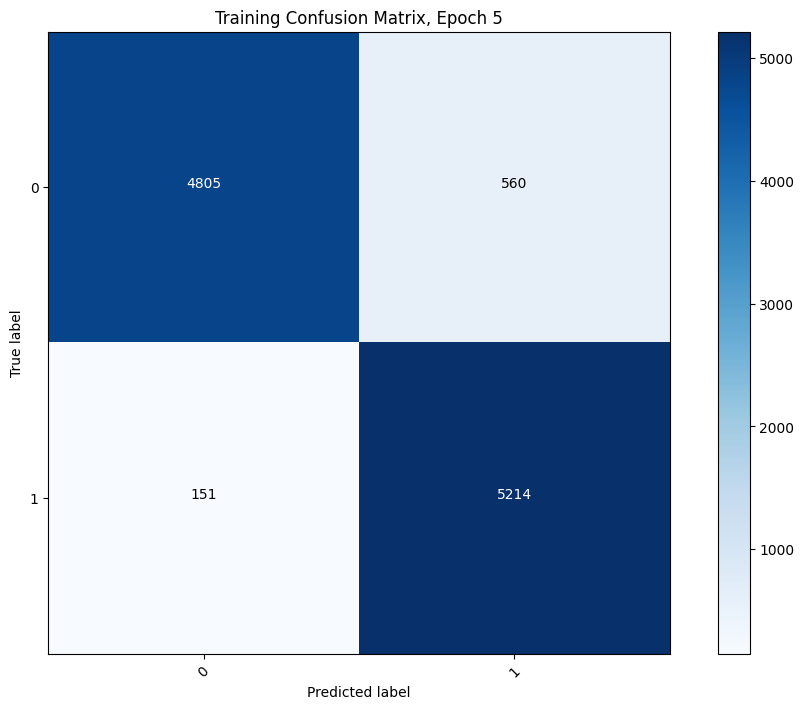

Validation Epoch 5:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.8199


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.6124
[[300 296]
 [166 430]]
Confusion matrix, without normalization


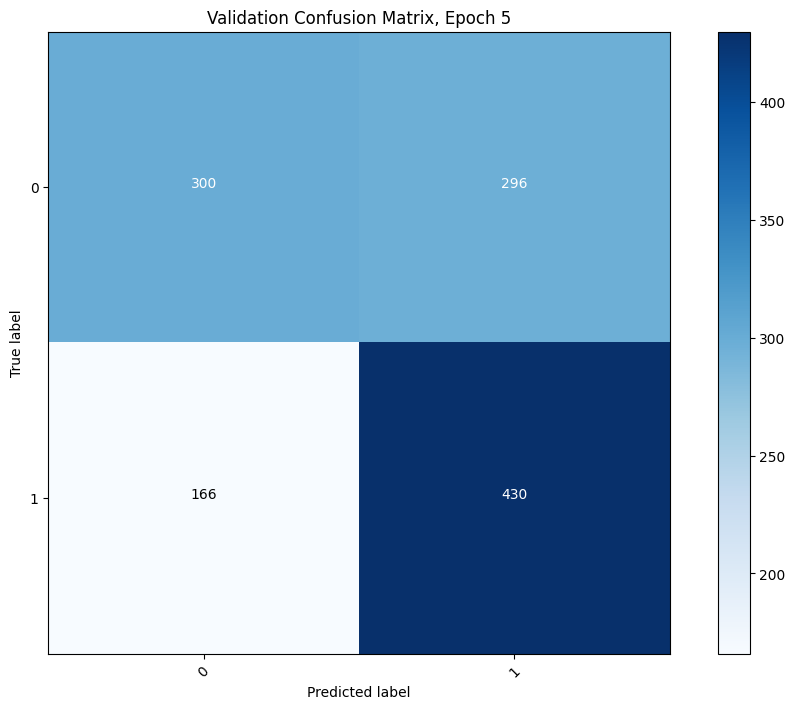

Early stopping triggered.
Fold 7/10


Training Epoch 1:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6924


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.5000
[[   0 5365]
 [   0 5365]]
Confusion matrix, without normalization


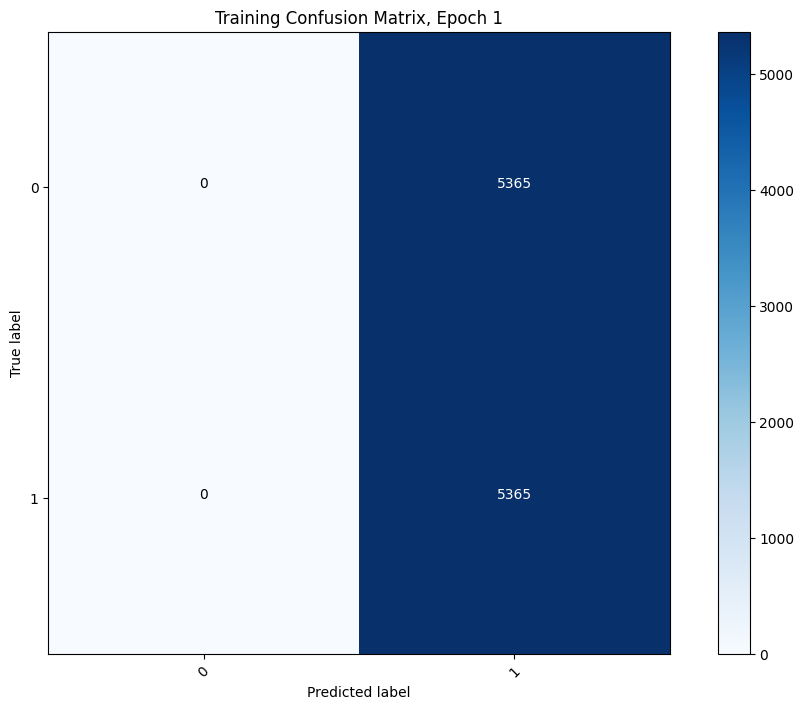

Validation Epoch 1:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6945


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5000
[[  0 596]
 [  0 596]]
Confusion matrix, without normalization


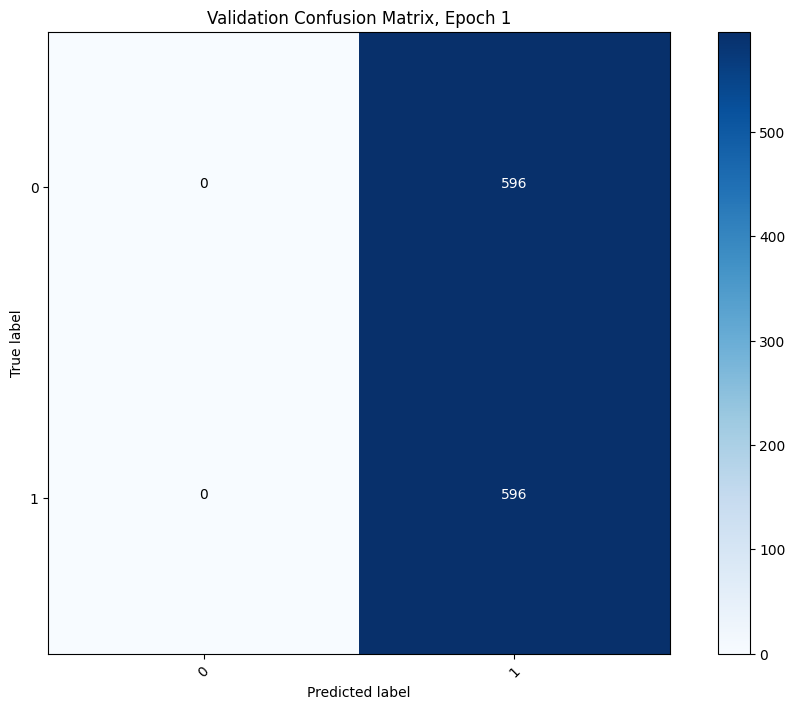

Training Epoch 2:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6928


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.4998
[[   0 5365]
 [   2 5363]]
Confusion matrix, without normalization


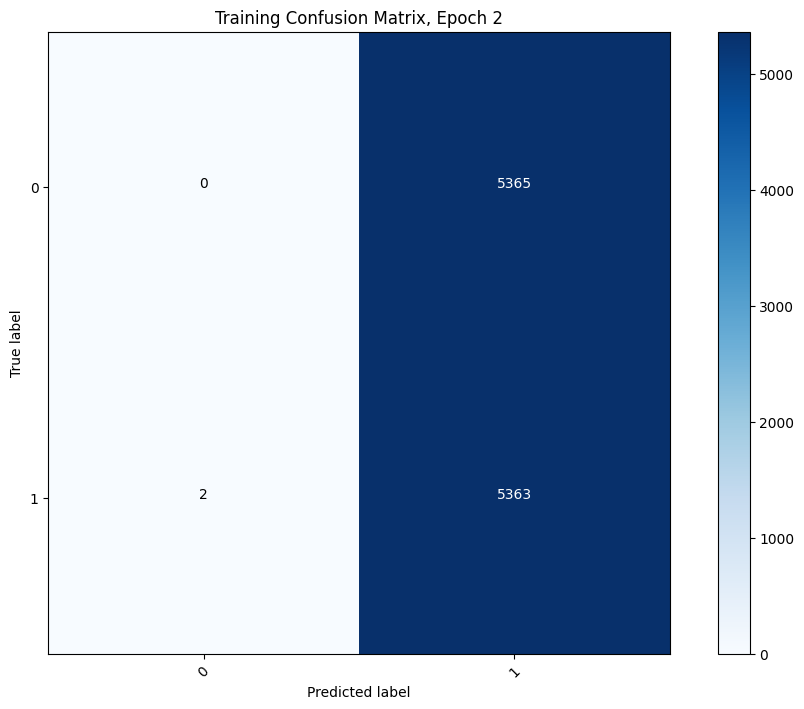

Validation Epoch 2:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6932


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5000
[[  1 595]
 [  1 595]]
Confusion matrix, without normalization


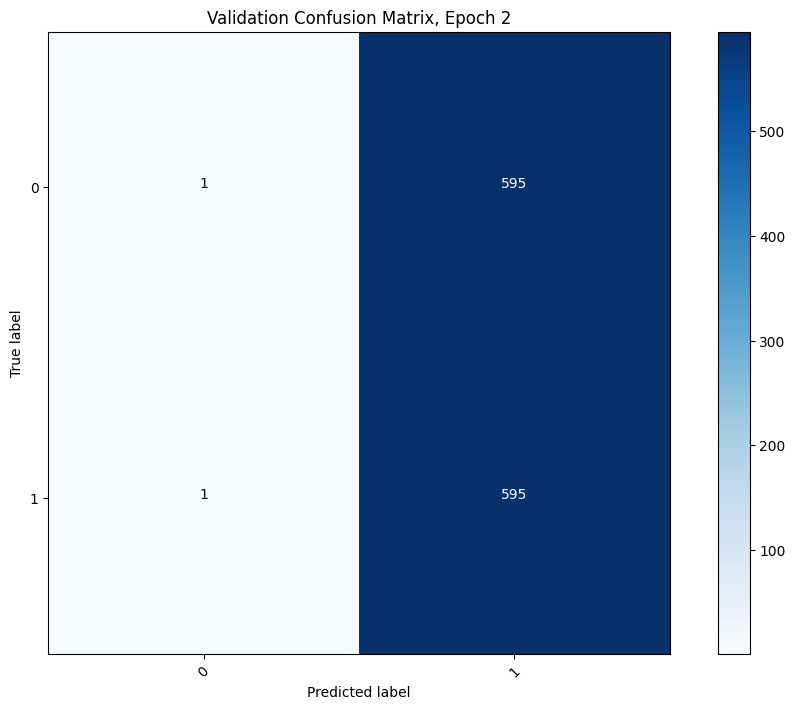

Training Epoch 3:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6935


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.5000
[[   1 5364]
 [   1 5364]]
Confusion matrix, without normalization


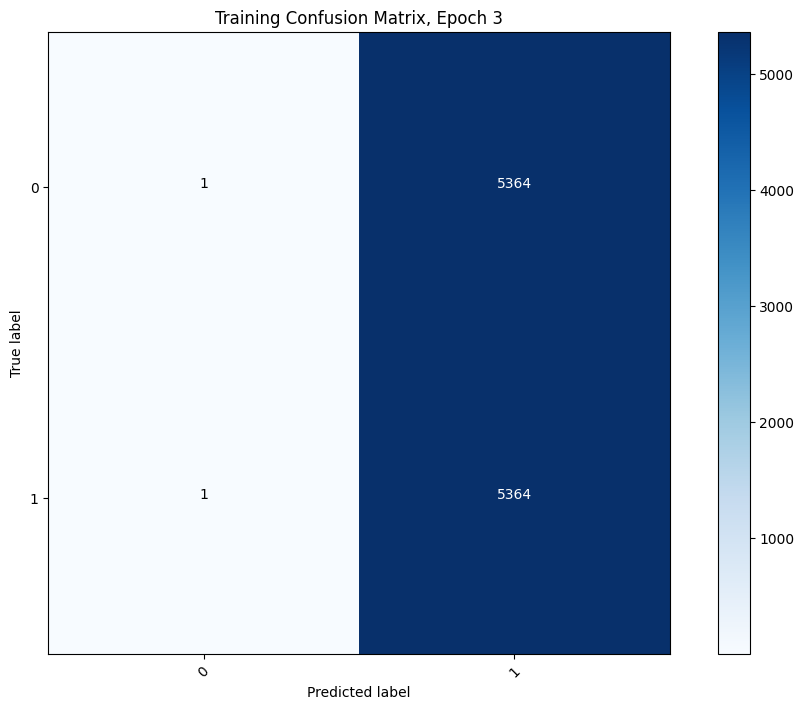

Validation Epoch 3:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6932


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5000
[[  1 595]
 [  1 595]]
Confusion matrix, without normalization


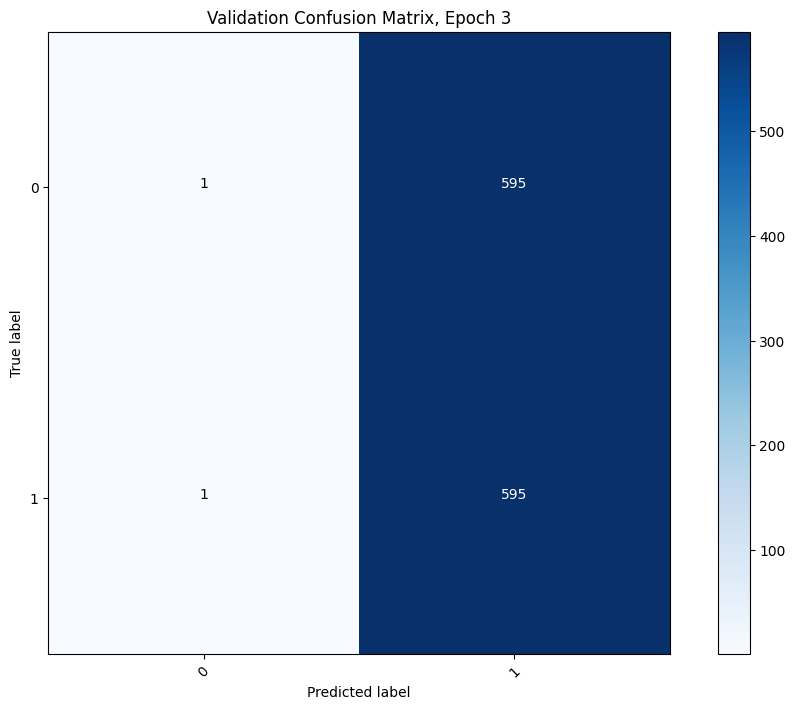

Training Epoch 4:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6934


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.5000
[[5365    0]
 [5365    0]]
Confusion matrix, without normalization


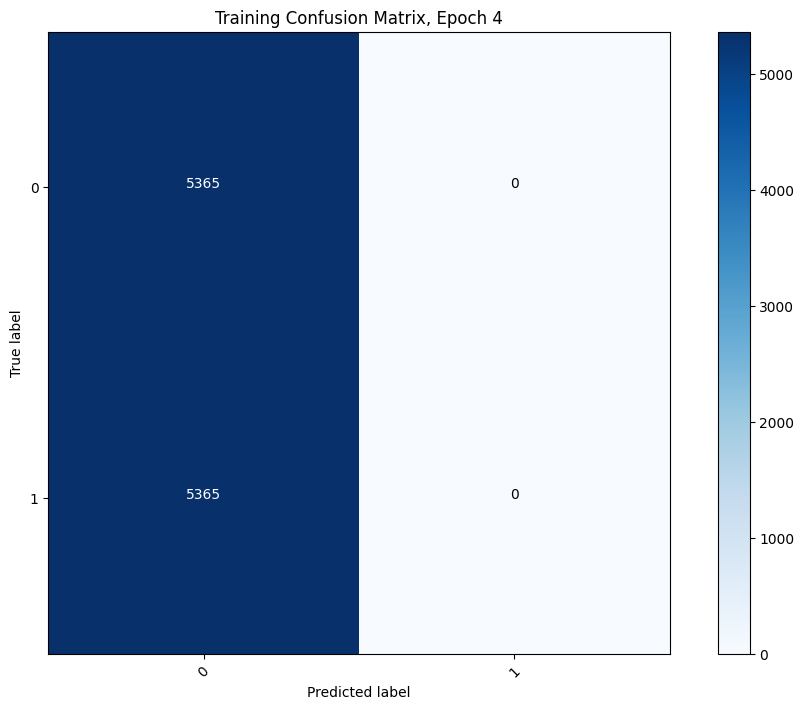

Validation Epoch 4:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6932


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5000
[[596   0]
 [596   0]]
Confusion matrix, without normalization


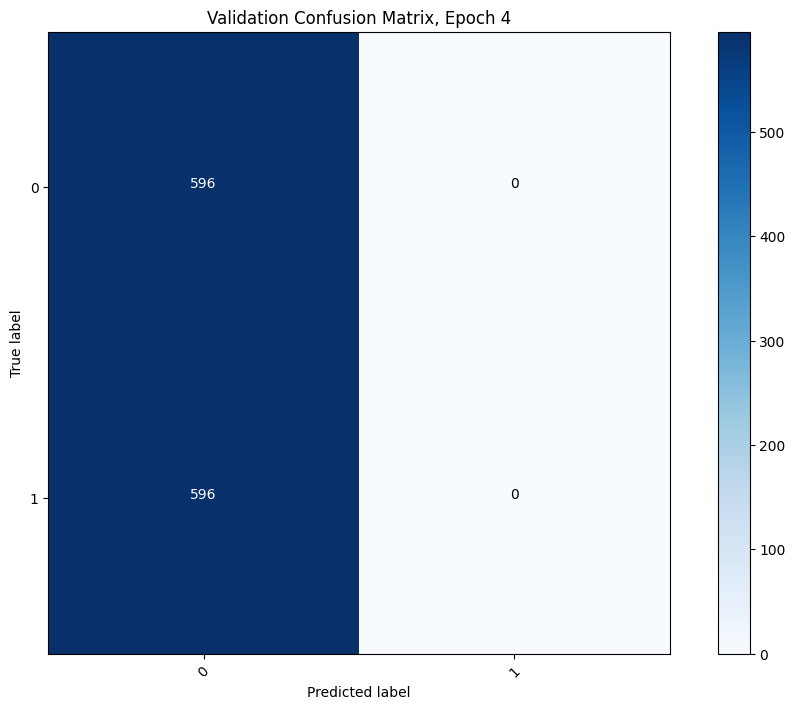

Training Epoch 5:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6933


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.5000
[[5365    0]
 [5365    0]]
Confusion matrix, without normalization


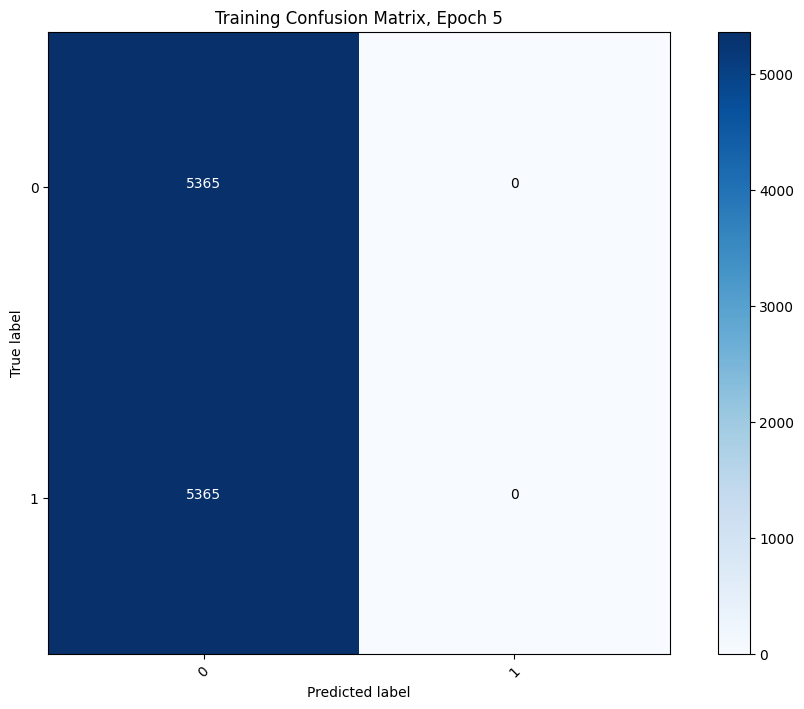

Validation Epoch 5:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6932


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5000
[[596   0]
 [596   0]]
Confusion matrix, without normalization


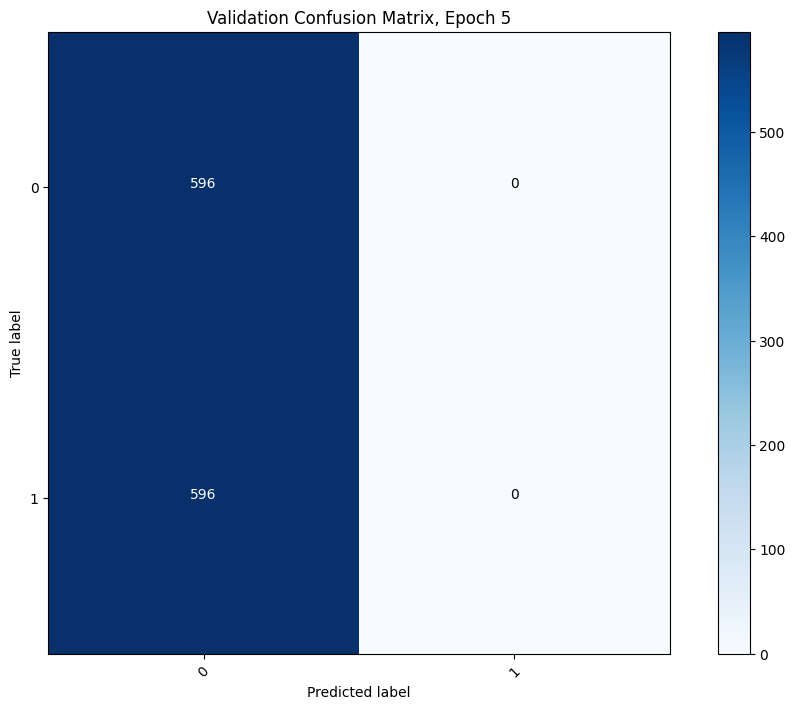

Training Epoch 6:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6934


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.5021
[[  40 5325]
 [  17 5348]]
Confusion matrix, without normalization


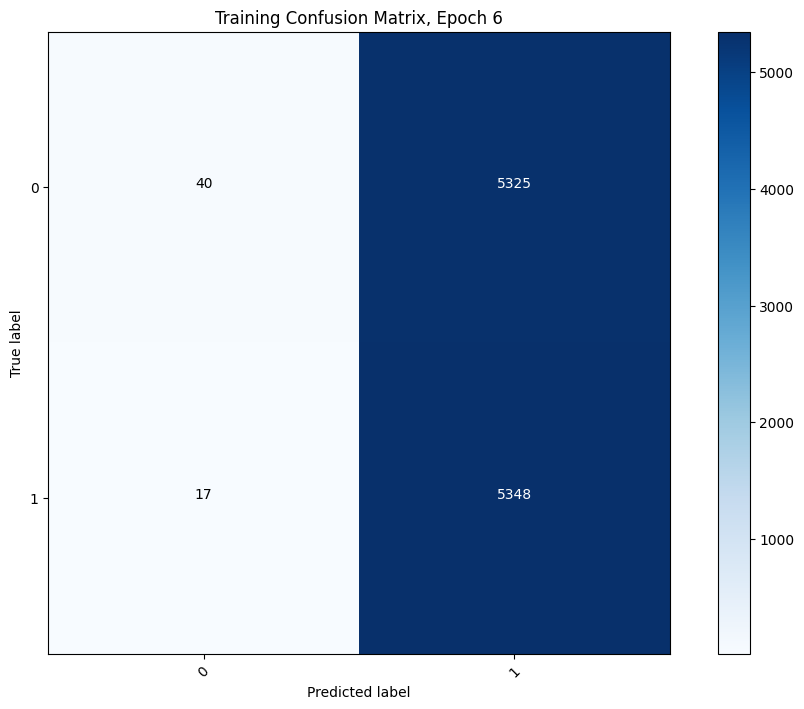

Validation Epoch 6:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6932


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.4983
[[  3 593]
 [  5 591]]
Confusion matrix, without normalization


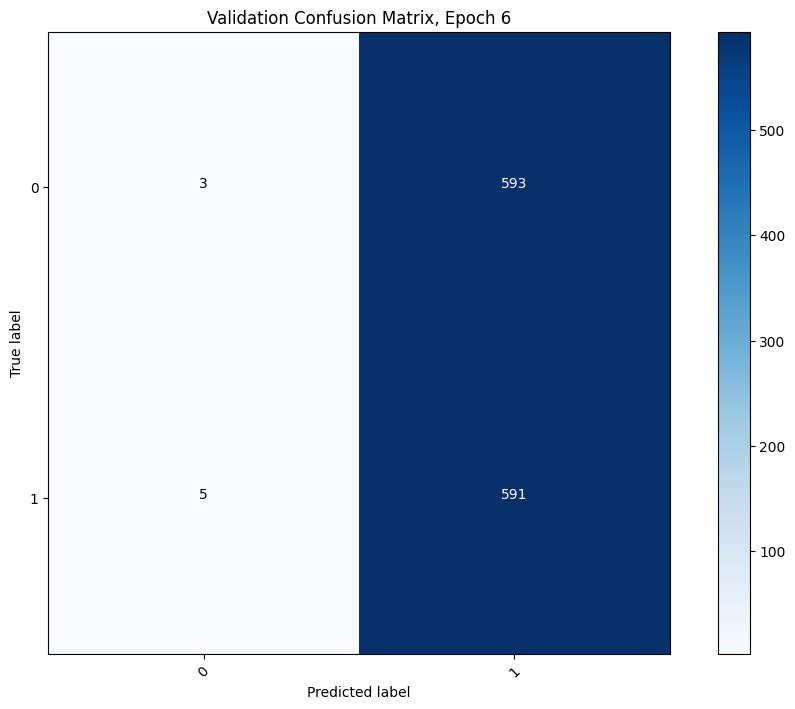

Epoch 00006: reducing learning rate of group 0 to 5.0000e-06.


Training Epoch 7:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6929


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.5236
[[2187 3178]
 [1934 3431]]
Confusion matrix, without normalization


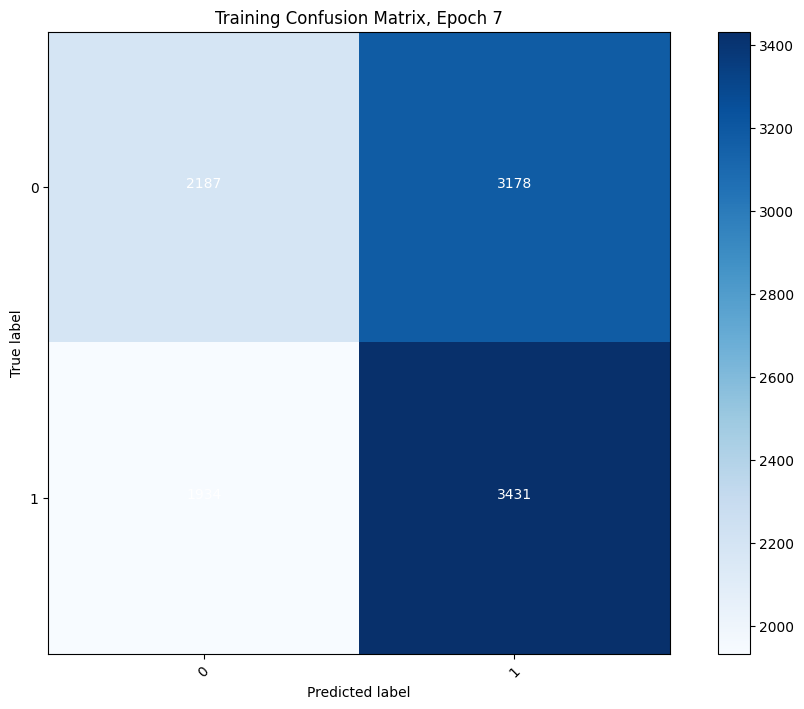

Validation Epoch 7:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6931


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5025
[[242 354]
 [239 357]]
Confusion matrix, without normalization


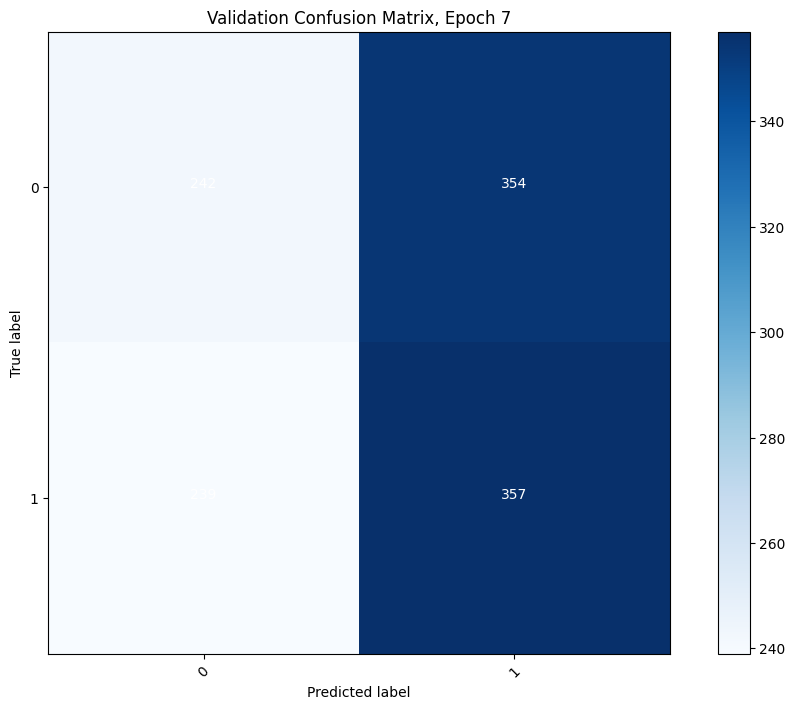

Training Epoch 8:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6833


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.6247
[[3665 1700]
 [2327 3038]]
Confusion matrix, without normalization


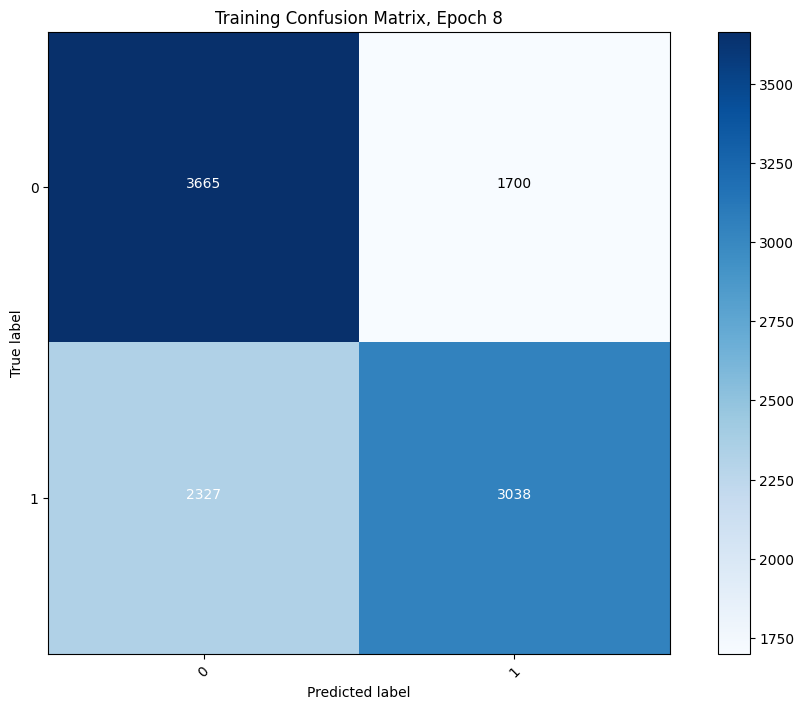

Validation Epoch 8:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6889


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5529
[[367 229]
 [304 292]]
Confusion matrix, without normalization


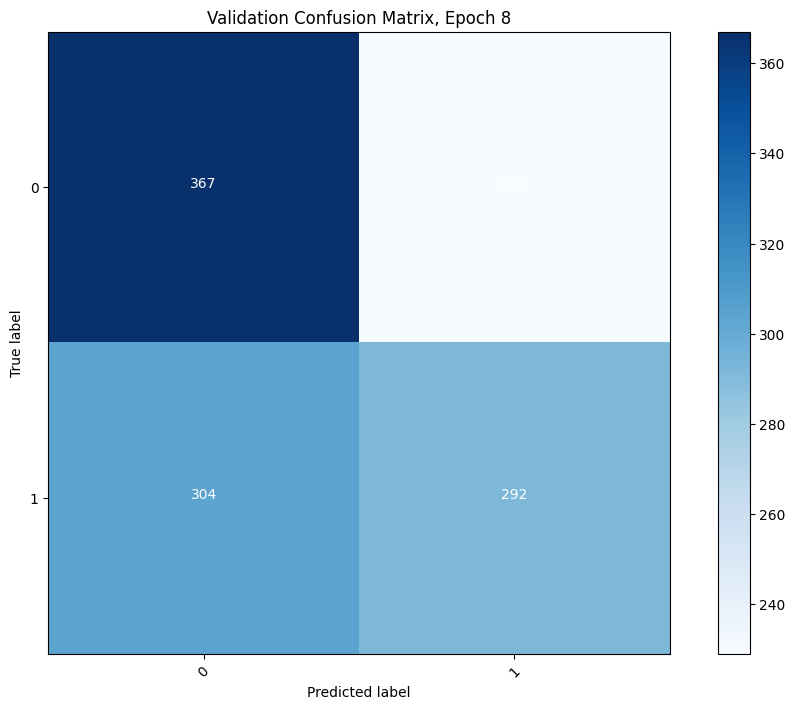

Training Epoch 9:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6599


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.6605
[[3581 1784]
 [1859 3506]]
Confusion matrix, without normalization


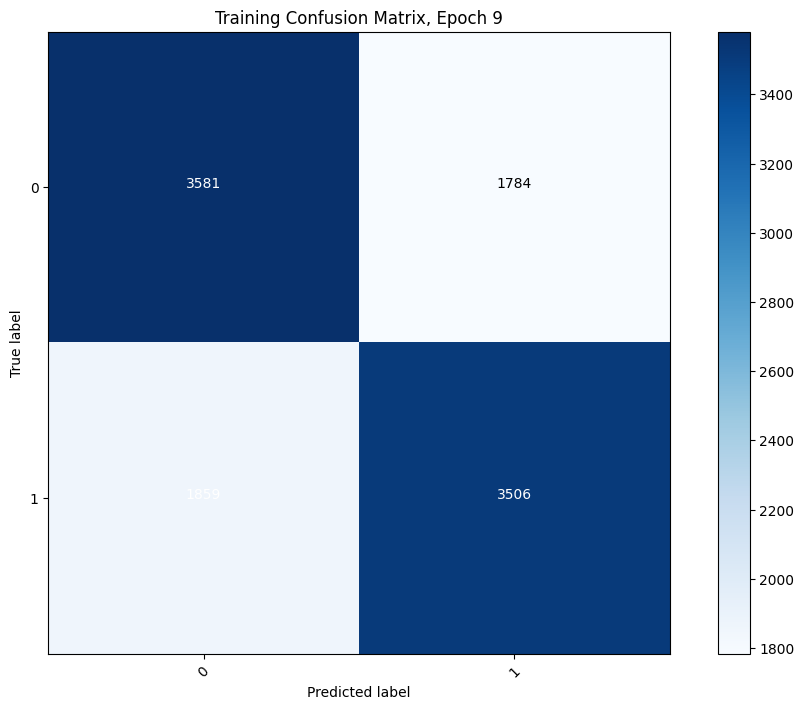

Validation Epoch 9:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6904


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5596
[[346 250]
 [275 321]]
Confusion matrix, without normalization


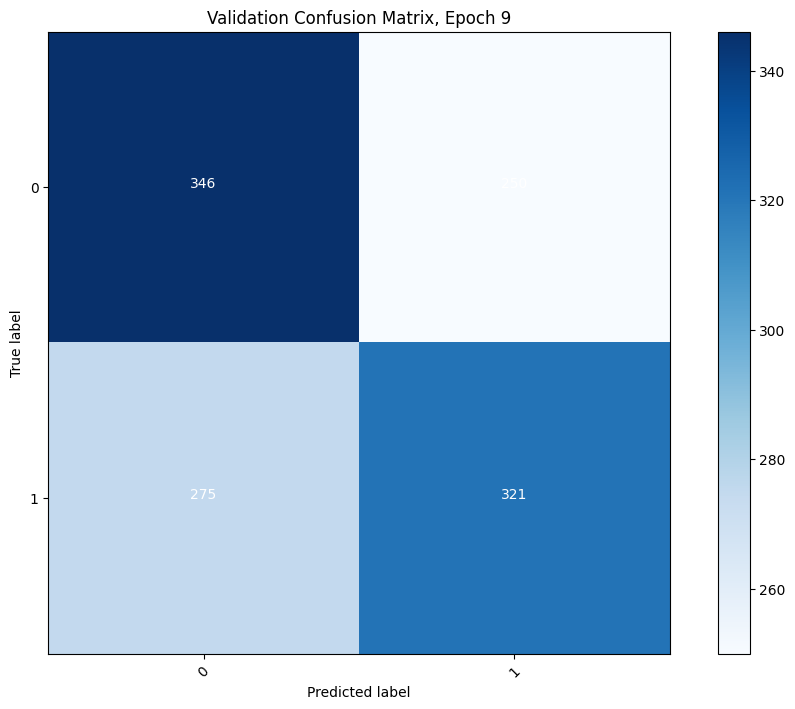

Training Epoch 10:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6353


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.7002
[[3332 2033]
 [1184 4181]]
Confusion matrix, without normalization


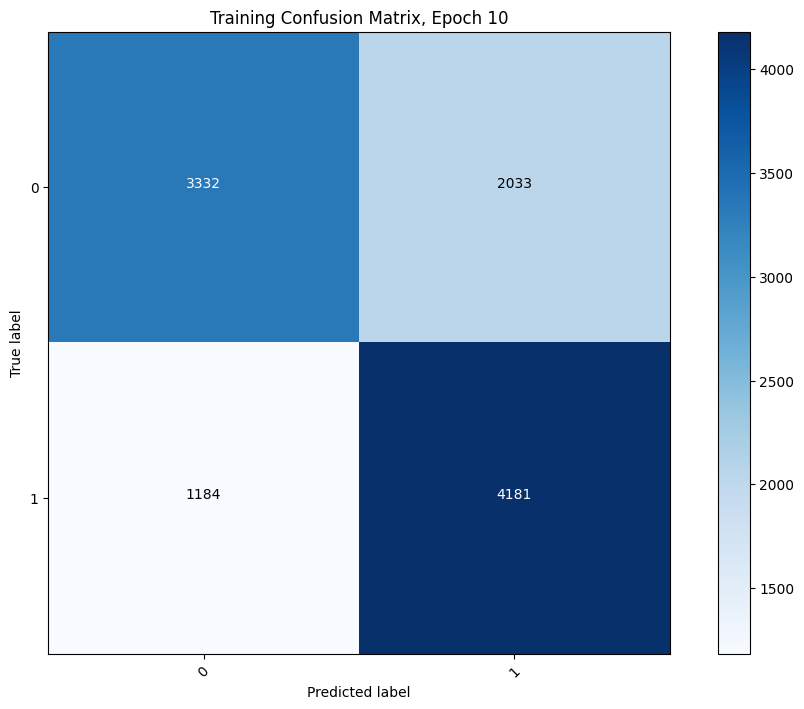

Validation Epoch 10:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6928


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5738
[[299 297]
 [211 385]]
Confusion matrix, without normalization


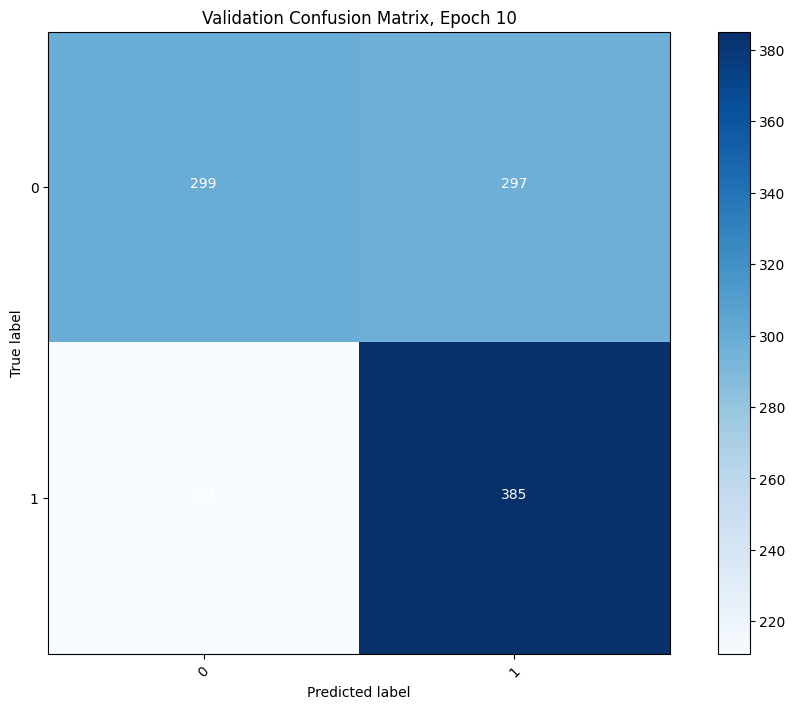

Training Epoch 11:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6125


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.7295
[[3725 1640]
 [1262 4103]]
Confusion matrix, without normalization


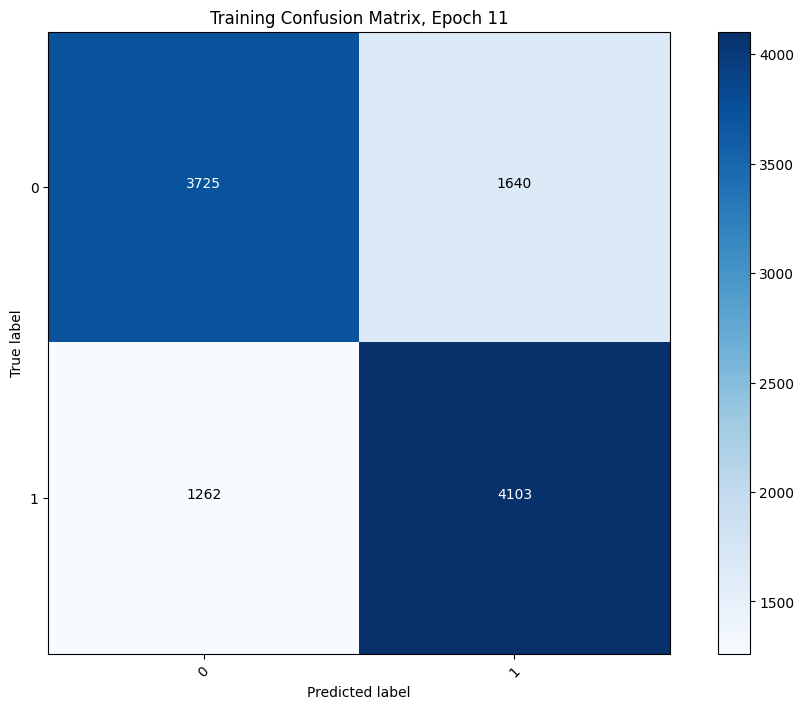

Validation Epoch 11:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.7106


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5705
[[325 271]
 [241 355]]
Confusion matrix, without normalization


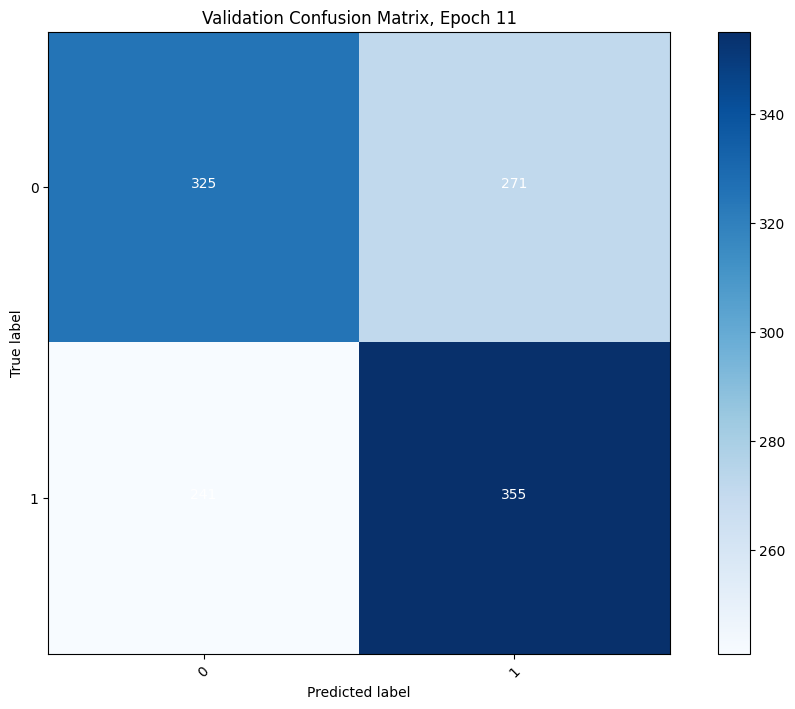

Early stopping triggered.
Fold 8/10


Training Epoch 1:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6935


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.5000
[[5365    0]
 [5365    0]]
Confusion matrix, without normalization


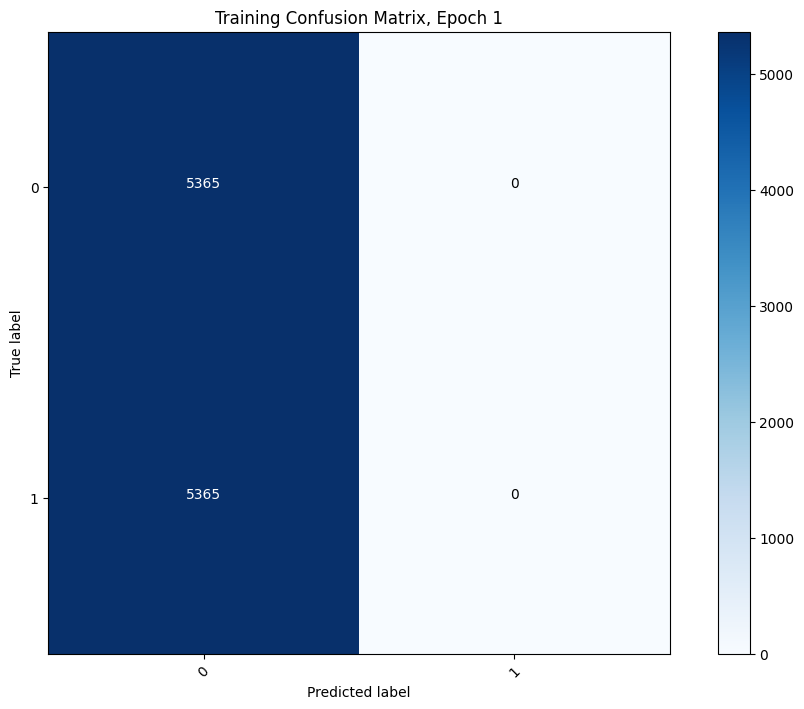

Validation Epoch 1:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6935


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5000
[[596   0]
 [596   0]]
Confusion matrix, without normalization


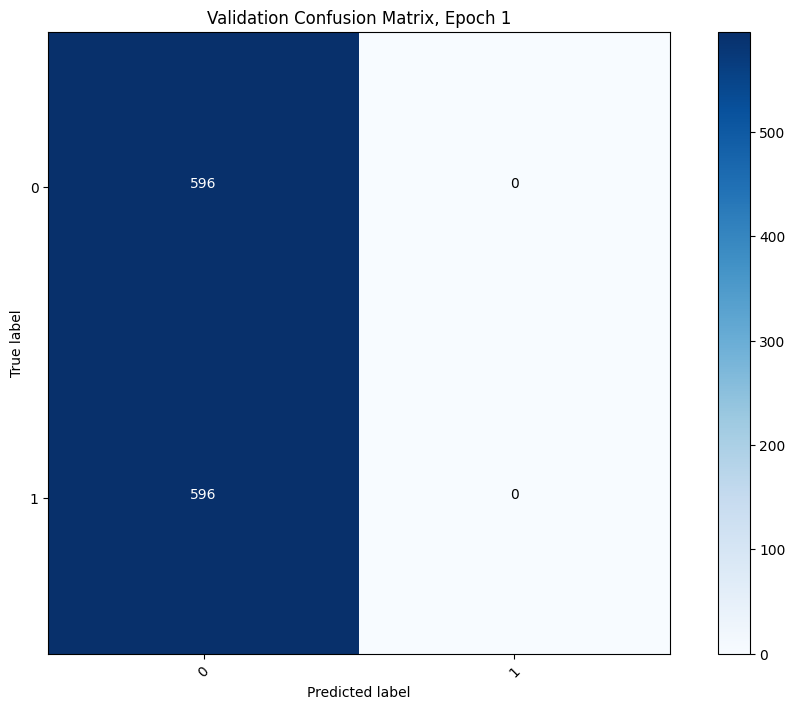

Training Epoch 2:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6934


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.5000
[[5365    0]
 [5365    0]]
Confusion matrix, without normalization


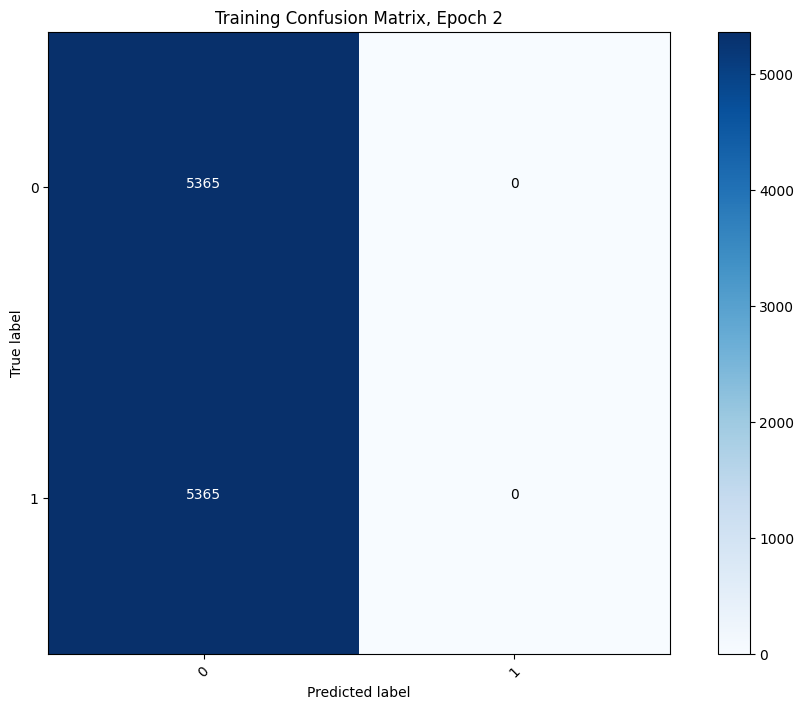

Validation Epoch 2:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6931


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5000
[[596   0]
 [596   0]]
Confusion matrix, without normalization


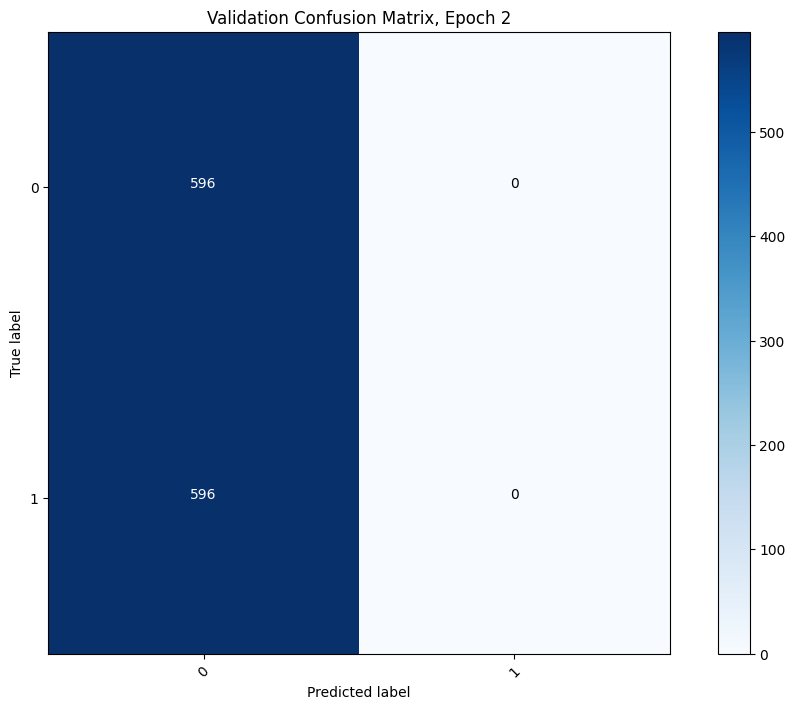

Training Epoch 3:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6933


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.5000
[[   0 5365]
 [   0 5365]]
Confusion matrix, without normalization


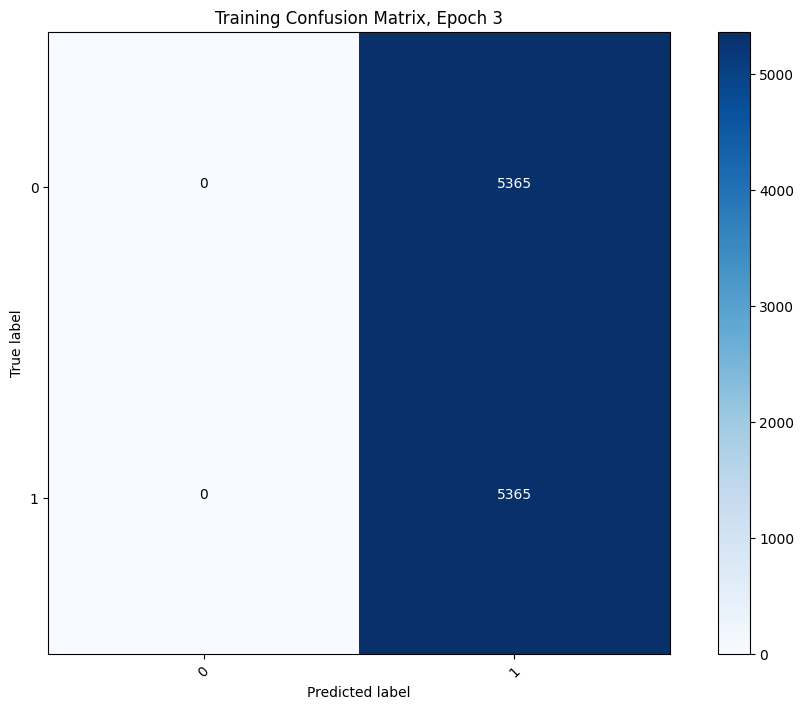

Validation Epoch 3:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6931


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5000
[[  0 596]
 [  0 596]]
Confusion matrix, without normalization


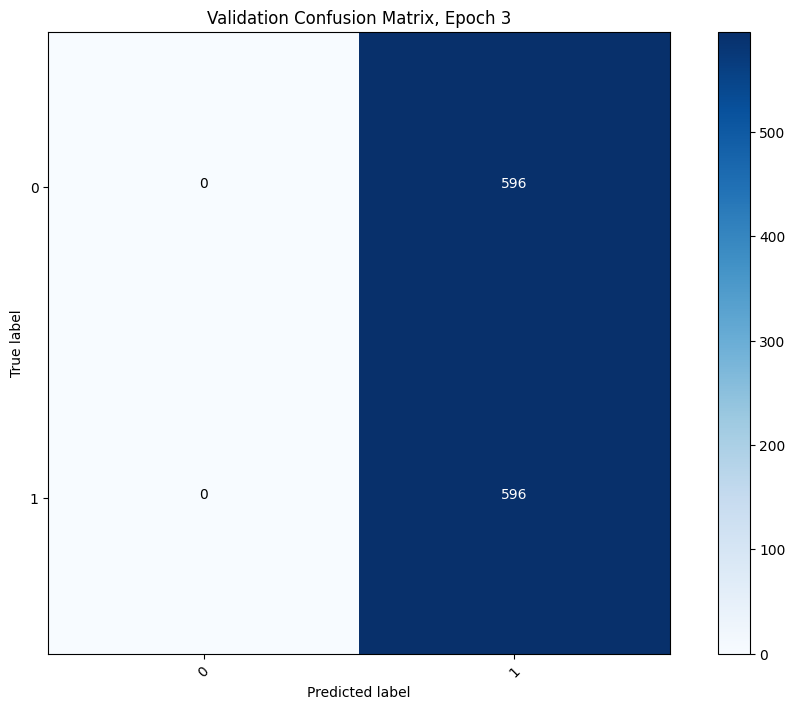

Training Epoch 4:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6933


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.5000
[[5365    0]
 [5365    0]]
Confusion matrix, without normalization


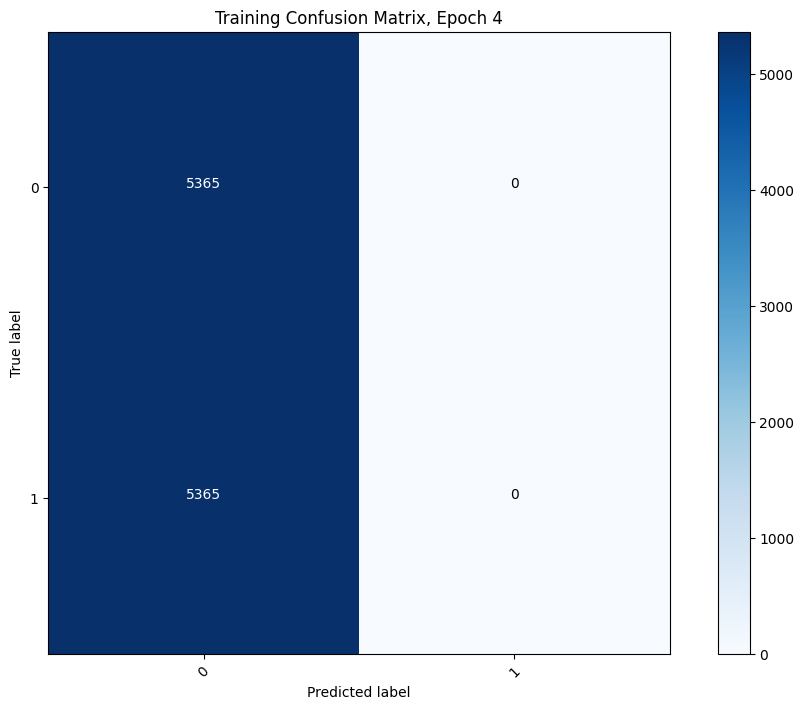

Validation Epoch 4:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6934


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5000
[[596   0]
 [596   0]]
Confusion matrix, without normalization


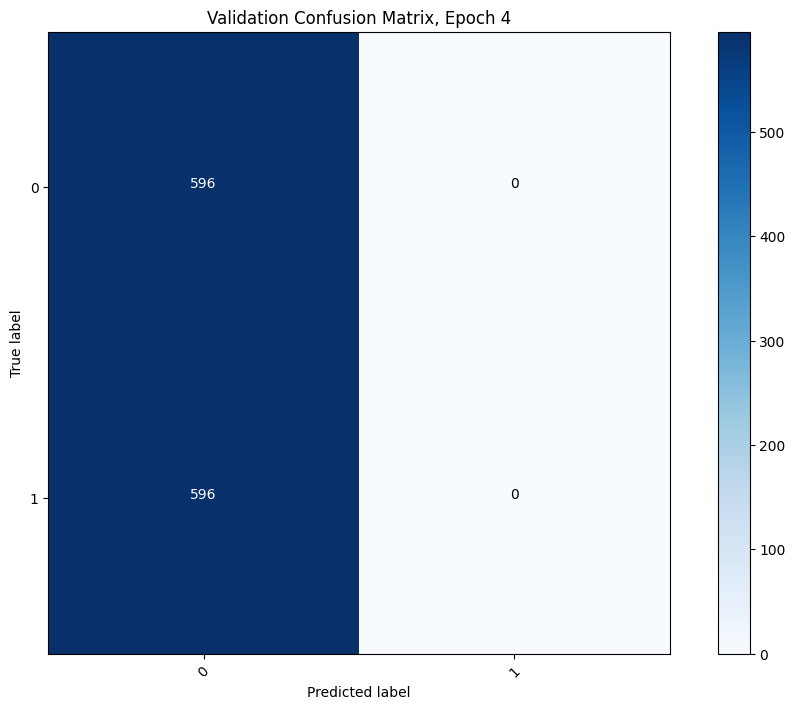

Training Epoch 5:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6934


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.5000
[[5365    0]
 [5365    0]]
Confusion matrix, without normalization


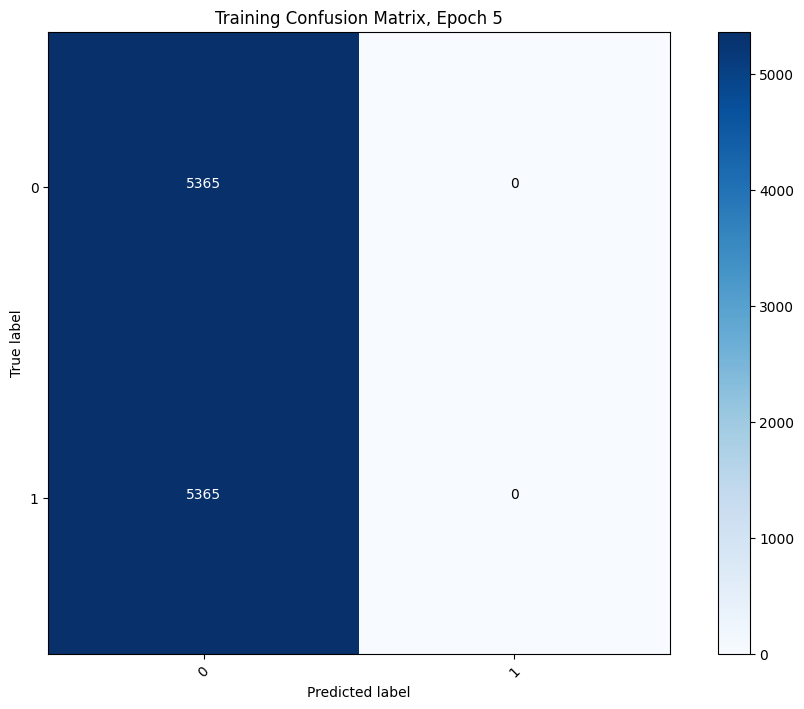

Validation Epoch 5:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6931


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5000
[[596   0]
 [596   0]]
Confusion matrix, without normalization


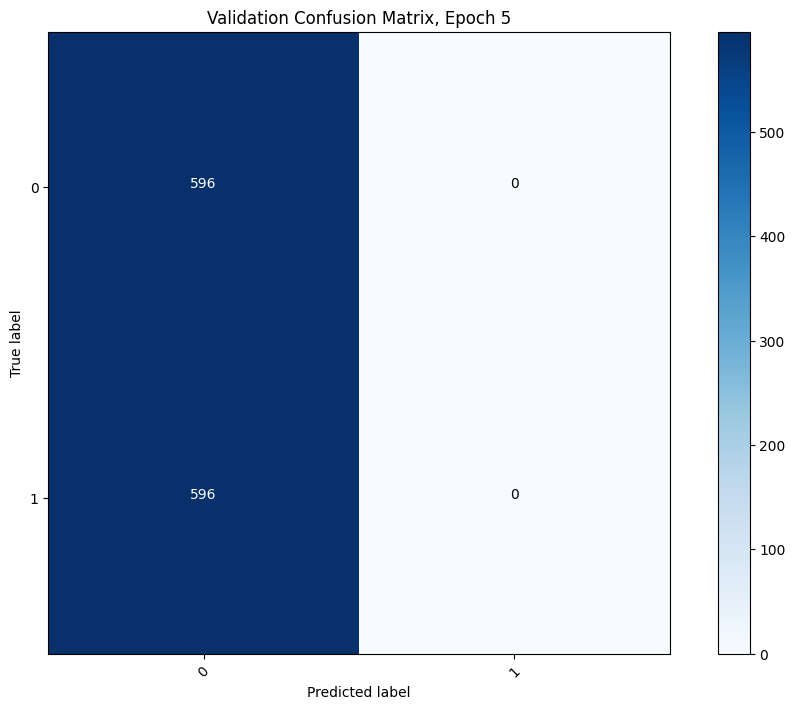

Early stopping triggered.
Fold 9/10


Training Epoch 1:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6862


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.6214
[[3956 1409]
 [2653 2712]]
Confusion matrix, without normalization


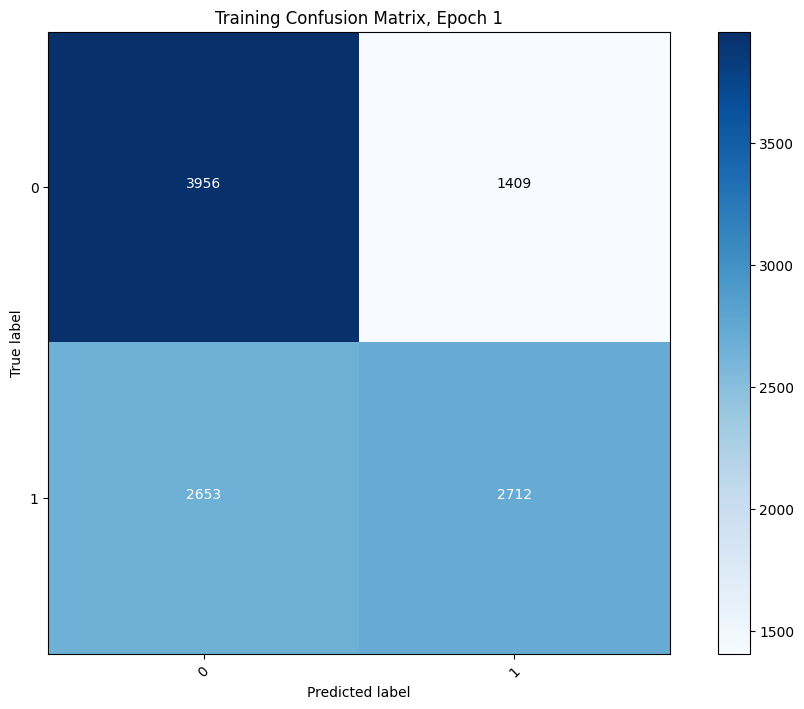

Validation Epoch 1:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6726


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5831
[[414 182]
 [315 281]]
Confusion matrix, without normalization


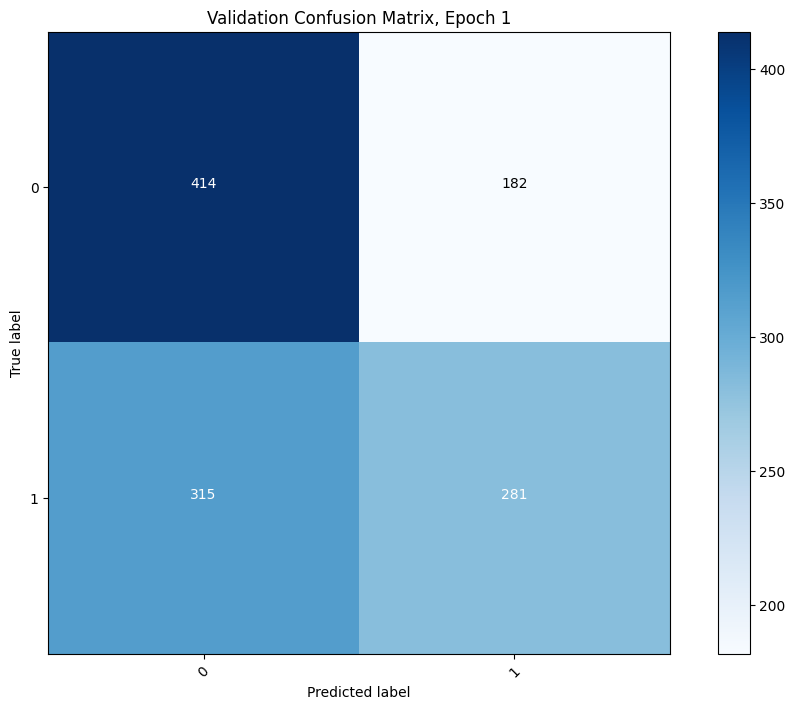

Training Epoch 2:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6900


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.5000
[[   0 5365]
 [   0 5365]]
Confusion matrix, without normalization


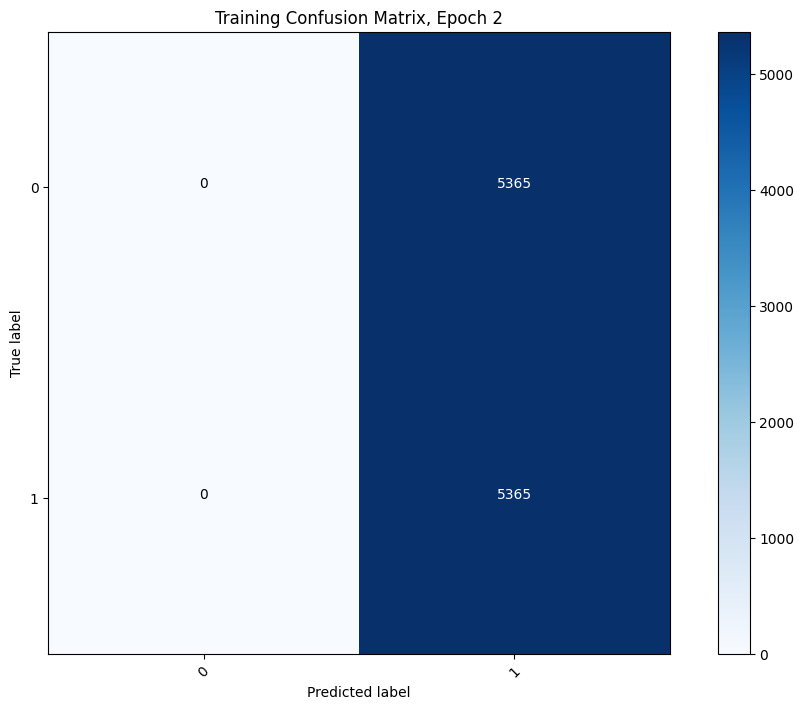

Validation Epoch 2:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6931


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5000
[[  0 596]
 [  0 596]]
Confusion matrix, without normalization


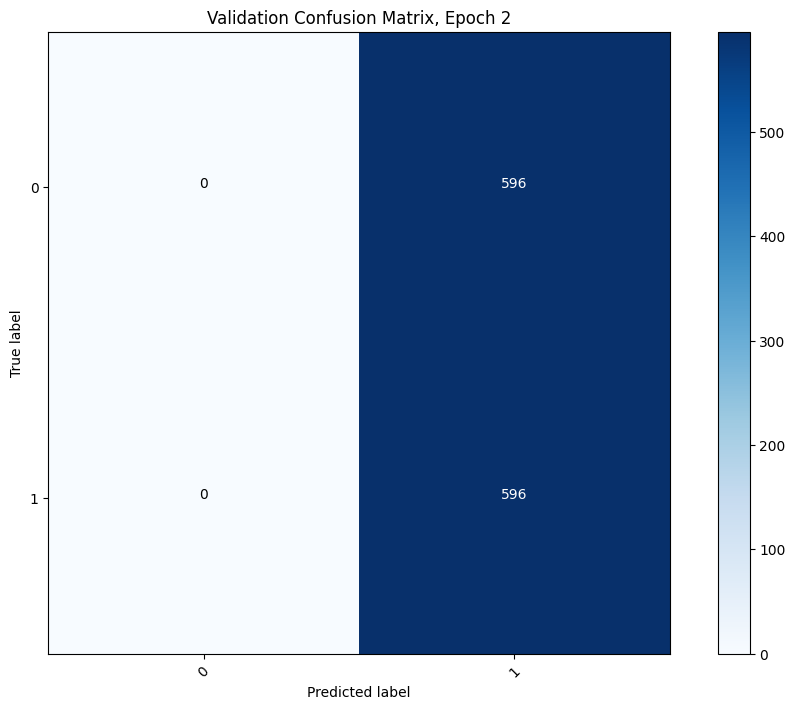

Training Epoch 3:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6904


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.5260
[[ 705 4660]
 [ 426 4939]]
Confusion matrix, without normalization


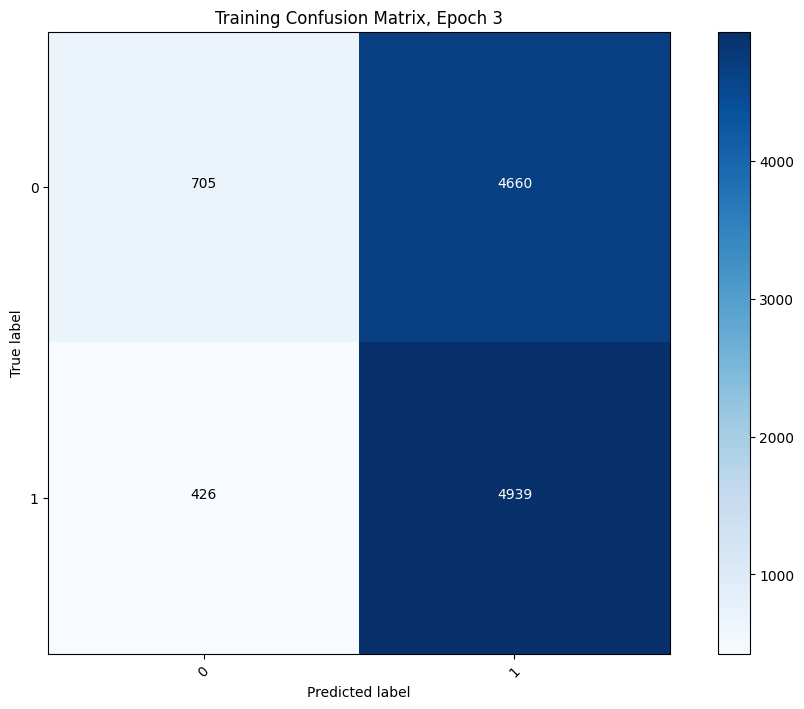

Validation Epoch 3:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6977


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5201
[[ 60 536]
 [ 36 560]]
Confusion matrix, without normalization


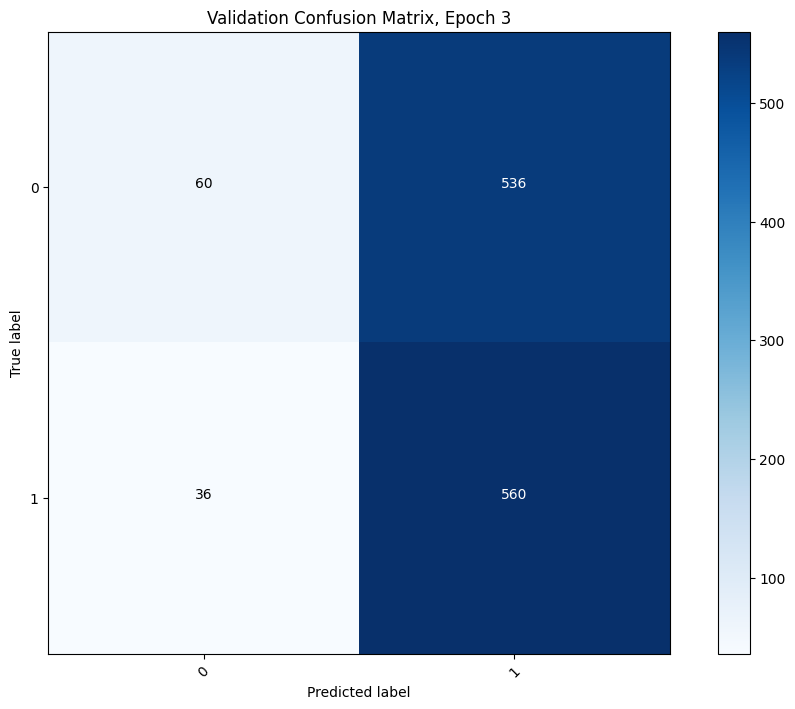

Training Epoch 4:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6876


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.5868
[[3777 1588]
 [2846 2519]]
Confusion matrix, without normalization


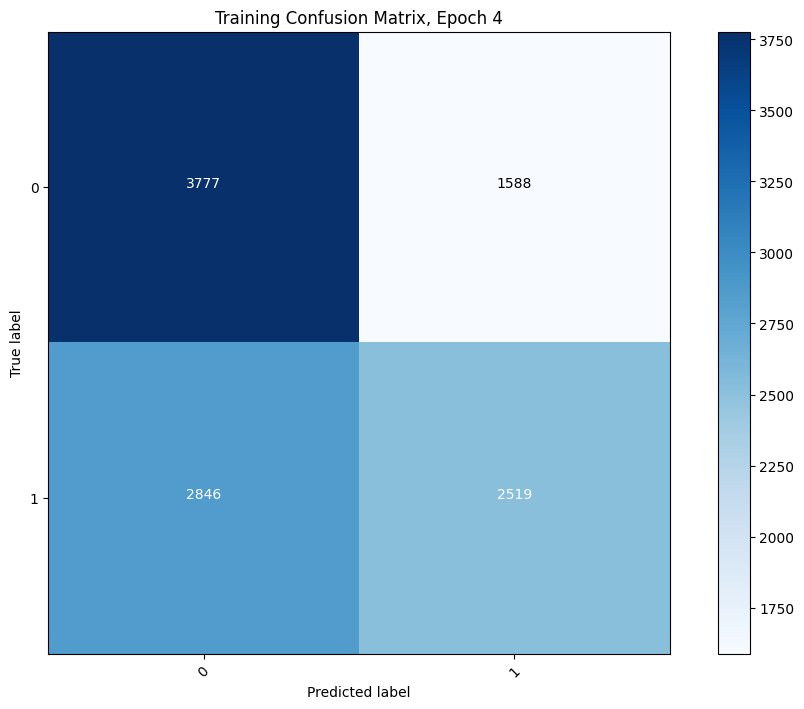

Validation Epoch 4:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6850


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5621
[[404 192]
 [330 266]]
Confusion matrix, without normalization


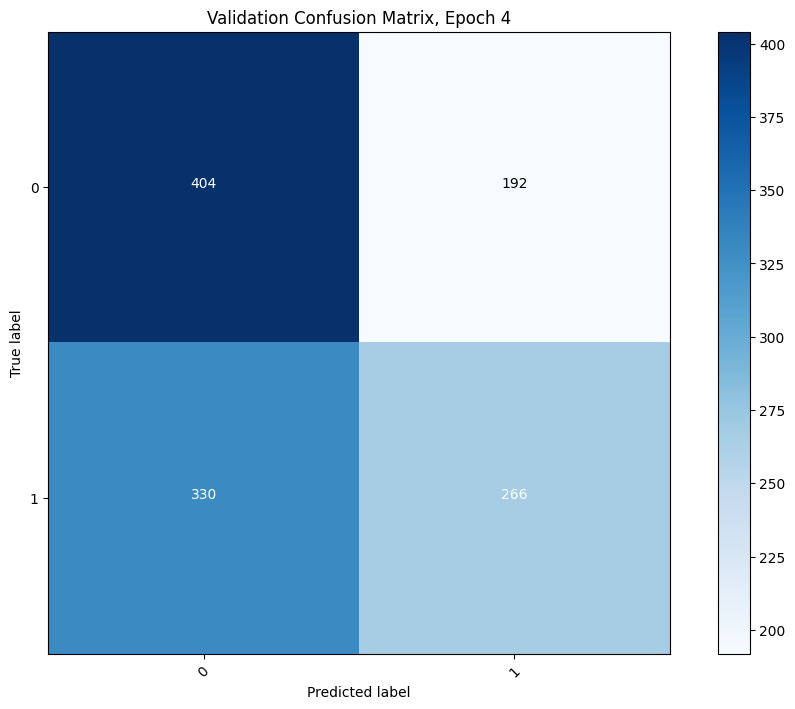

Early stopping triggered.
Fold 10/10


Training Epoch 1:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6929


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.5000
[[5365    0]
 [5365    0]]
Confusion matrix, without normalization


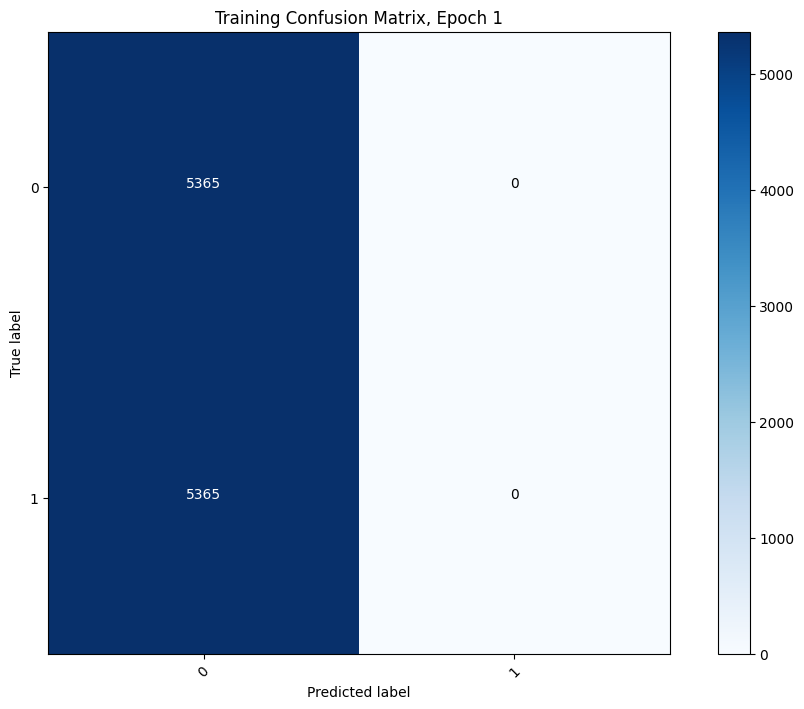

Validation Epoch 1:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6937


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5000
[[596   0]
 [596   0]]
Confusion matrix, without normalization


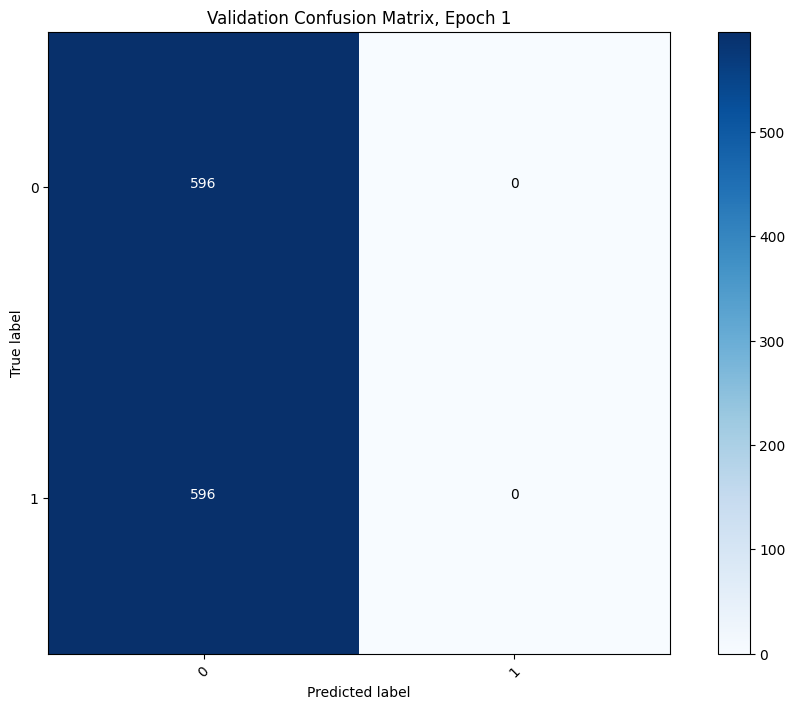

Training Epoch 2:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6936


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.5000
[[   0 5365]
 [   0 5365]]
Confusion matrix, without normalization


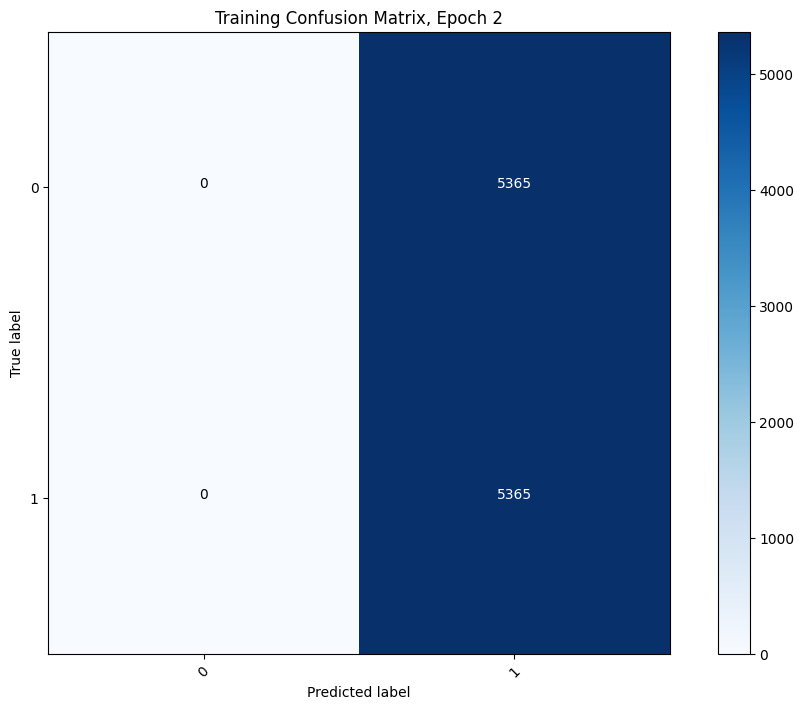

Validation Epoch 2:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6931


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5000
[[  0 596]
 [  0 596]]
Confusion matrix, without normalization


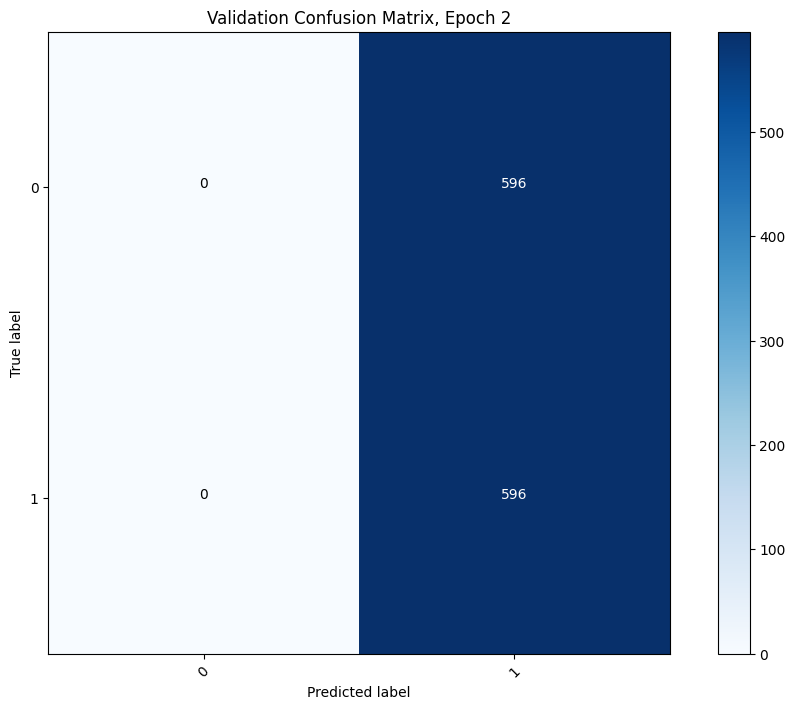

Training Epoch 3:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6932


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.5000
[[   0 5365]
 [   0 5365]]
Confusion matrix, without normalization


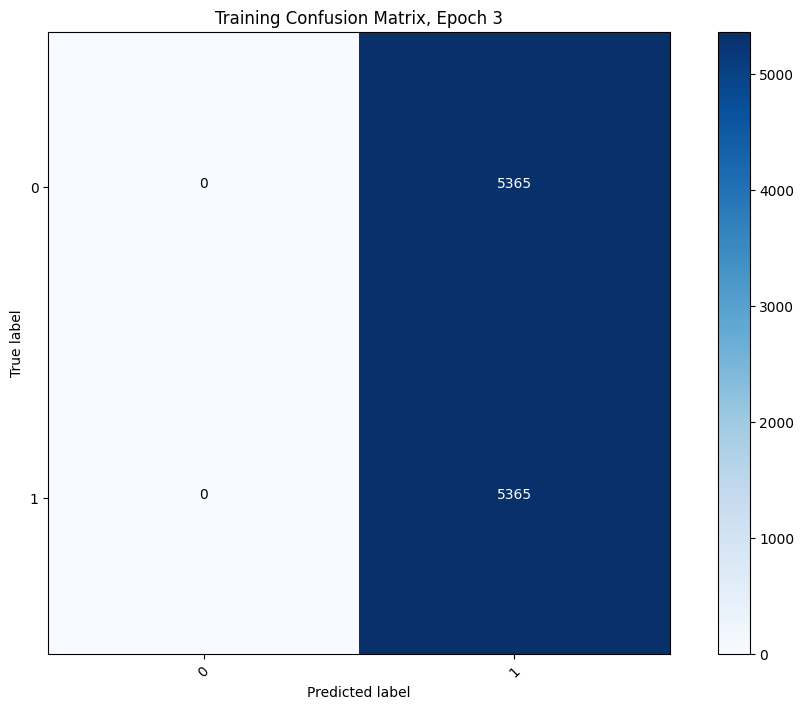

Validation Epoch 3:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6931


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5000
[[  0 596]
 [  0 596]]
Confusion matrix, without normalization


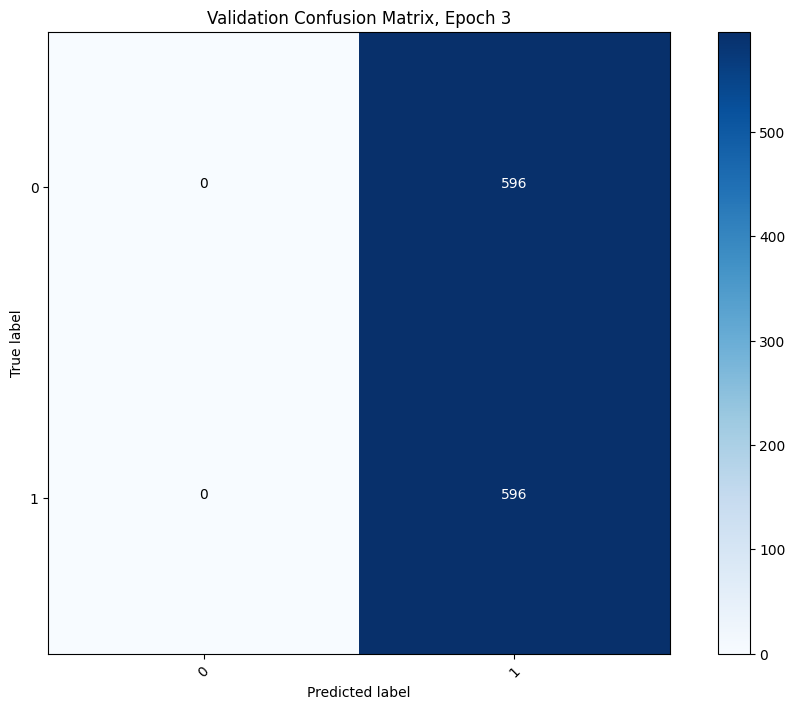

Training Epoch 4:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6933


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.5000
[[5365    0]
 [5365    0]]
Confusion matrix, without normalization


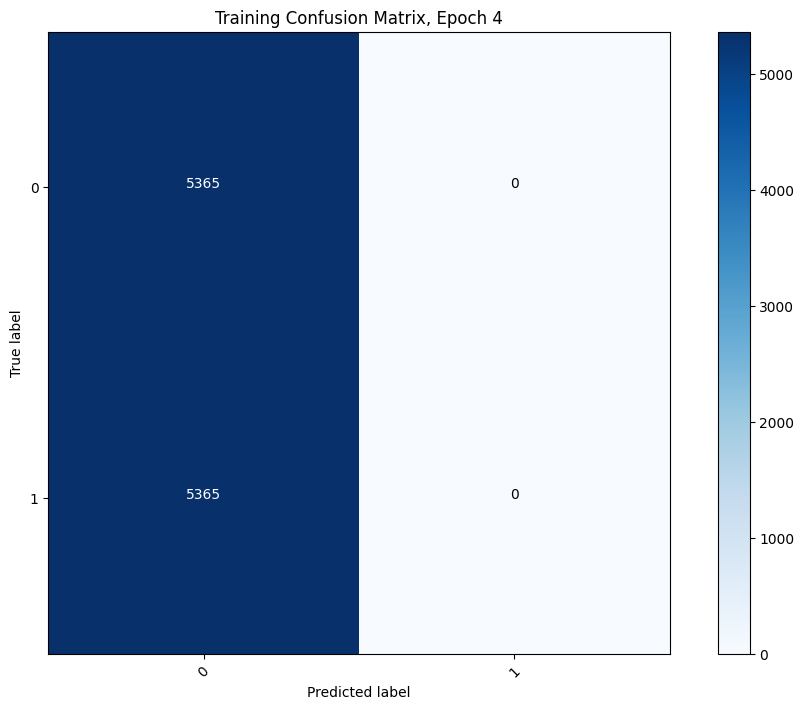

Validation Epoch 4:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6931


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5000
[[596   0]
 [596   0]]
Confusion matrix, without normalization


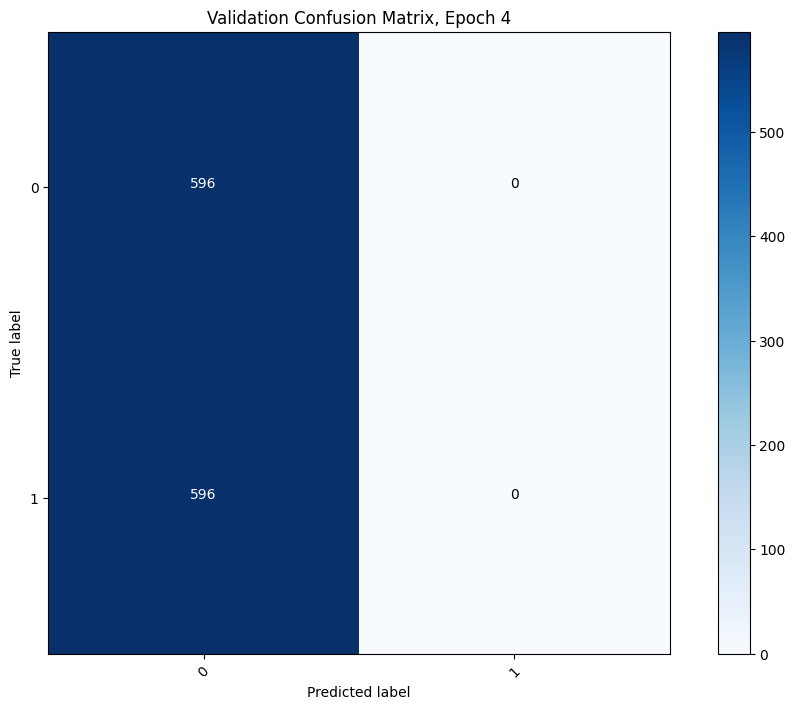

Training Epoch 5:   0%|          | 0/671 [00:00<?, ?it/s]

Training Loss: 0.6933


Calculating Balanced Accuracy:   0%|          | 0/671 [00:00<?, ?it/s]

Balanced training accuracy: 0.5000
[[   0 5365]
 [   0 5365]]
Confusion matrix, without normalization


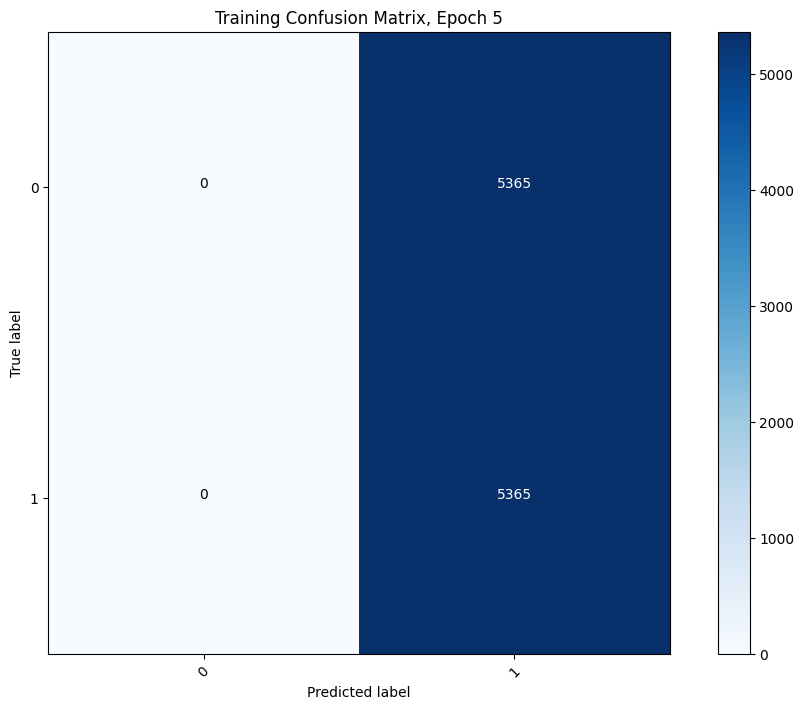

Validation Epoch 5:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss: 0.6932


Calculating Balanced Accuracy:   0%|          | 0/75 [00:00<?, ?it/s]

Balanced validation accuracy: 0.5000
[[  0 596]
 [  0 596]]
Confusion matrix, without normalization


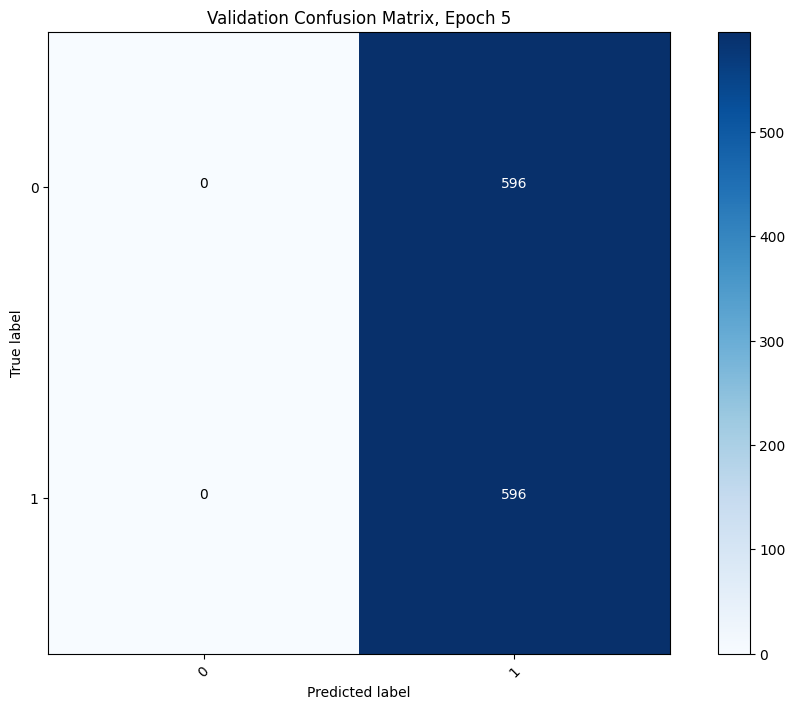

Early stopping triggered.


In [40]:
# Assume binary_dataset is already loaded and available
dataset_indices = list(range(len(binary_dataset)))
targets = [binary_dataset[i]['labels'].item() for i in dataset_indices]

k = 10
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
epochs = 12
batch_size = 16
early_stopping_patience = 3

hidden_dim = 64
dropout_rate = 0.2  # Adjust dropout rate if needed
class_names = range(0, 2)

for fold, (train_idx, val_idx) in enumerate(skf.split(dataset_indices, targets)):
    print(f'Fold {fold + 1}/{k}')
    
    binary_model = BinarySciBertClassifier(hidden_dim, dropout_rate, device)
    optimizer = AdamW(binary_model.parameters(), lr=5e-5, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3, verbose=True)
    loss_fn = torch.nn.BCELoss()  # Binary Cross Entropy Loss

    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(binary_dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(binary_dataset, batch_size=batch_size, sampler=val_sampler)
    
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        binary_model.train()
        total_loss = 0
        train_loader_tqdm = tqdm(train_loader, desc=f"Training Epoch {epoch+1}")
        for batch in train_loader_tqdm:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device).float()  
            
            optimizer.zero_grad()
            outputs = binary_model(input_ids, attention_mask)
            outputs = outputs.squeeze()
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        print(f"Training Loss: {avg_train_loss:.4f}")
        
        train_balanced_accuracy, train_preds, train_true = calculate_binary_balanced_accuracy(binary_model, train_loader, device)
        print(f"Balanced training accuracy: {train_balanced_accuracy:.4f}")
        
        # Calculate and plot training confusion matrix
        train_cm = confusion_matrix(train_true, train_preds)
        print(train_cm)
        plt.figure(figsize=(10, 7))
        plot_confusion_matrix(train_cm, classes=list(class_names), title=f'Training Confusion Matrix, Epoch {epoch+1}')
        plt.show()

        binary_model.eval()
        total_val_loss = 0
        val_loader_tqdm = tqdm(val_loader, desc=f"Validation Epoch {epoch+1}")
        with torch.no_grad():
            for batch in val_loader_tqdm:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device).float()
                
                outputs = binary_model(input_ids, attention_mask)
                outputs = outputs.squeeze()
                loss = loss_fn(outputs, labels)
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        print(f"Validation Loss: {avg_val_loss:.4f}")
        
        val_balanced_accuracy, val_preds, val_true = calculate_binary_balanced_accuracy(binary_model, val_loader, device)
        print(f"Balanced validation accuracy: {val_balanced_accuracy:.4f}")
        
        # Calculate and plot validation confusion matrix
        val_cm = confusion_matrix(val_true, val_preds)
        print(val_cm)
        plt.figure(figsize=(10, 7))
        plot_confusion_matrix(val_cm, classes=list(class_names), title=f'Validation Confusion Matrix, Epoch {epoch+1}')
        plt.show()
        
        scheduler.step(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            model_dir = f'/kaggle/working/binary_model_checkpoints/fold_{fold + 1}'
            if not os.path.exists(model_dir):
                os.makedirs(model_dir)
            model_save_path = os.path.join(model_dir, f'model_epoch_{epoch+1}.pth')
            torch.save(binary_model.state_dict(), model_save_path)
        else:
            patience_counter += 1

        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

### Multi Class

In [41]:
# from sklearn.utils.class_weight import compute_class_weight

# targets =  train_df["Label"]
# class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(targets), y=targets)
# class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [42]:
# class_weights

In [43]:
# k = 10
# skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
# epochs = 12
# batch_size = 16
# early_stopping_patience = 3
# hidden_dim = 128
# output_dim = 8
# dropout_rate = 0.2
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# class_names = range(1, 8)


# dataset_indices = list(range(len(train_dataset)))
# targets = [train_dataset[i]['labels'].item() for i in dataset_indices]

# class_weights = torch.tensor([0.9723, 0.9637, 1.0841, 1.1081, 1.0157, 0.9538, 0.9196, 0.9249], device=device)
# loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# for fold, (train_idx, val_idx) in enumerate(skf.split(dataset_indices, targets)):
#     print(f'Fold {fold + 1}/{k}')
    
#     model = SciBertClassifier(hidden_dim, output_dim, dropout_rate, device)
#     optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)
#     scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3, verbose=True)

#     train_sampler = SubsetRandomSampler(train_idx)
#     val_sampler = SubsetRandomSampler(val_idx)
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
#     val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)

#     best_val_loss = float('inf')
#     patience_counter = 0

#     for epoch in range(epochs):
#         model.train()
#         total_loss = 0
#         train_loader_tqdm = tqdm(train_loader, desc=f"Training Epoch {epoch+1}")
#         for batch in train_loader_tqdm:
#             input_ids = batch['input_ids'].to(device)
#             attention_mask = batch['attention_mask'].to(device)
#             labels = batch['labels'].to(device)
            
#             optimizer.zero_grad()
#             outputs = model(input_ids, attention_mask)
#             loss = loss_fn(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item()

#         avg_train_loss = total_loss / len(train_loader)
#         print(f"Training Loss: {avg_train_loss:.4f}")
        
#         train_balanced_accuracy, train_preds, train_true = calculate_balanced_accuracy(model, train_loader, device)
#         print(f"Balanced training accuracy: {train_balanced_accuracy:.4f}")
        
#         # Calculate and plot training confusion matrix
#         train_cm = confusion_matrix(train_true, train_preds)
#         print(train_cm)
#         plt.figure(figsize=(10, 7))
#         plot_confusion_matrix(train_cm, classes=list(class_names), title=f'Training Confusion Matrix, Epoch {epoch+1}')
#         plt.show()

#         model.eval()
#         total_val_loss = 0
#         val_loader_tqdm = tqdm(val_loader, desc=f"Validation Epoch {epoch+1}")
#         with torch.no_grad():
#             for batch in val_loader_tqdm:
#                 input_ids = batch['input_ids'].to(device)
#                 attention_mask = batch['attention_mask'].to(device)
#                 labels = batch['labels'].to(device)
                
#                 outputs = model(input_ids, attention_mask)
#                 loss = loss_fn(outputs, labels)
#                 total_val_loss += loss.item()
        
#         avg_val_loss = total_val_loss / len(val_loader)
#         print(f"Validation Loss: {avg_val_loss:.4f}")
        
#         val_balanced_accuracy, val_preds, val_true = calculate_balanced_accuracy(model, val_loader, device)
#         print(f"Balanced validation accuracy: {val_balanced_accuracy:.4f}")
        
#         # Calculate and plot validation confusion matrix
#         val_cm = confusion_matrix(val_true, val_preds)
#         print(val_cm)
#         plt.figure(figsize=(10, 7))
#         plot_confusion_matrix(val_cm, classes=list(class_names), title=f'Validation Confusion Matrix, Epoch {epoch+1}')
#         plt.show()
        
#         scheduler.step(avg_val_loss)

#         if avg_val_loss < best_val_loss:
#             best_val_loss = avg_val_loss
#             patience_counter = 0
#             model_dir = f'/kaggle/working/model_checkpoints/fold_{fold + 1}'
#             if not os.path.exists(model_dir):
#                 os.makedirs(model_dir)
#             model_save_path = os.path.join(model_dir, f'model_epoch_{epoch+1}.pth')
#             torch.save(model.state_dict(), model_save_path)
#         else:
#             patience_counter += 1

#         if patience_counter >= early_stopping_patience:
#             print("Early stopping triggered.")
#             break

## Inference

In [44]:
# hidden_dim = 128
# output_dim = 8
# dropout_rate = 0.2
# model = SciBertClassifier(hidden_dim, output_dim, dropout_rate, device)

In [45]:
# state_dict = torch.load("/kaggle/input/document-emb/pytorch/k1-e2/1/model_epoch_2(3).pth")
# model.load_state_dict(state_dict)

In [46]:
# train_balanced_accuracy, train_preds, train_true = calculate_balanced_accuracy(model, train_loader, device)

In [47]:
# class_names = range(1, 10)
# train_cm = confusion_matrix(train_true, train_preds)
# plt.figure(figsize=(10, 7))
# plot_confusion_matrix(train_cm, classes=list(class_names), title=f'Confusion Matrix')
# plt.show()

In [48]:
# train_cm